In [1]:
import numpy as np
import xarray as xr
import os
import sys
import pandas as pd
import datetime
import matplotlib.pyplot as plt
# import seawater as sw
from shapely.geometry import Point
from scipy.interpolate import RegularGridInterpolator
from proj_viz.argo_viz import plot_single_ts_profile, compare_profiles
# # git clone https://github.com/garrettdreyfus/python-holteandtalley.git
# # cd python-holteandtalley & pip install -e .
# from holteandtalley import HolteAndTalley
sys.path.append("/home/jmiranda/SubsurfaceFields/GEM_SubsurfaceFields/eoas_pyutils/")
from io_utils.coaps_io_data import get_aviso_by_date, get_sst_by_date, get_sss_by_date
# from io_utils.io_netcdf import read_netcdf_xr, read_multiple_netcdf_xarr # read_multiple not working, using my own
from viz_utils.eoa_viz import select_colormap, EOAImageVisualizer
from viz_utils.eoas_viz_3d import ImageVisualizer3D
from viz_utils.constants import PlotMode

processed =  True

def load_join_clean(path, files, variables, num_files=None):
    """Load, joins and remove NaNs from multiple NetCDF files.

    Parameters:
    path (str): The path to the directory containing the files.
    files (list of str): The list of files to load.
    variables (list of str): The variables to extract from each file.
    num_files (int, optional): The maximum number of files to load.

    Returns:
    pandas.DataFrame: The concatenated clean dataset as a DataFrame.
    """
    # Initialize an empty list to store the datasets
    datasets = [xr.open_dataset(os.path.join(path, file), decode_times=False)[variables] for file in files[:num_files] if file.endswith('.nc')]
    ds_combined = xr.concat(datasets, dim='time')
    df_clean = ds_combined.to_dataframe().dropna()
    df_clean.index = pd.to_datetime(df_clean.index, unit='s')
    df_clean['date'] = df_clean.index.date
    return df_clean

def get_prof_ssh_from_aviso(grid_lats, grid_lons, aviso_data, grid_grid_lats, grid_grid_lons):
    """Interpolates AVISO altimetry to profile locations.

    Parameters:
    grid_lats (array-like): Latitudes of the profile locations.
    grid_lons (array-like): Longitudes of the profile locations.
    aviso_data (array-like): AVISO altimetry data on a regular grid.
    grid_grid_lats (array-like): Latitudes of the regular grid.
    grid_grid_lons (array-like): Longitudes of the regular grid.

    Returns:
    numpy.ndarray: Interpolated altimetry values at the profile locations.
    """
    interpolator = RegularGridInterpolator((grid_grid_lats, grid_grid_lons), aviso_data.values, bounds_error=False, fill_value=None)
    coordinates = np.array([grid_lats, grid_lons]).T
    return interpolator(coordinates)

def calculate_MLD(df):
    """
    Calculate Mixed Layer Depth based on density, temperature differences, and maximum curvature of T profiles.
    
    Parameters:
    df (pandas.DataFrame): The DataFrame containing the data.
    
    Returns:
    pandas.DataFrame: A DataFrame with columns: profile_id, MLD_density, MLD_temperature, MLD_curvature.
    """
    
    results = []

    for profile_id in df['profile_id'].unique():
        # Filter the DataFrame for the specific profile ID and sort by pressure
        tdf = df[df['profile_id'] == profile_id]
        tdf = tdf.sort_values(by='pressure')

        # Get lists of temperature, pressure, salinity, and density
        temp = tdf['temperature'].tolist()
        pres = tdf['pressure'].tolist()
        sal = tdf['salinity'].tolist()
        den = tdf['density'].tolist()

        # Find the reference density and temperature (values below 3m)
        reference_density = None
        reference_temperature = None
        for p, d, t in zip(pres, den, temp):
            if p > 3:
                reference_density = d
                reference_temperature = t
                break

        # Calculate MLD for density
        mld_density = None
        for p, d in zip(pres, den):
            if abs(d - reference_density) > 0.125:
                mld_density = p
                break
        
        # Calculate MLD for temperature
        mld_temperature = None
        for p, t in zip(pres, temp):
            if abs(t - reference_temperature) > 0.8:
                mld_temperature = p
                break

        # Calculate MLD based on the maximum curvature of T profiles
        interp_pres = np.linspace(min(pres), max(pres), 1000)
        interp_temp = np.interp(interp_pres, pres, temp)
        curvature = np.gradient(np.gradient(interp_temp, interp_pres), interp_pres)
        mld_curvature = interp_pres[np.argmax(curvature)]
        
        results.append([profile_id, mld_density, mld_temperature, mld_curvature])

    # Convert results to a DataFrame
    result_df = pd.DataFrame(results, columns=['profile_id', 'MLD_T', 'MLD_c', 'MLD_d'])
    
    return result_df

def plot_MLD_profile(df, profileNumber):
    """Plot temperature, salinity, and density profiles for a specific day.

    Parameters:
    df (pandas.DataFrame): Processed data, including.
    day (datetime.date): The day to plot profiles for.
    """
    # Filter the DataFrame for the chosen profile
    tdf = df[df['profile_id'] == profileNumber]
    temp = tdf['temperature'].tolist()
    pres = tdf['pressure'].tolist()
    sal = tdf['salinity'].tolist()
    den = tdf['density'].tolist()

    mld_names = ['MLD_T', 'MLD_c', 'MLD_d']
    if all(mld in df.columns for mld in mld_names):
        mld_tsd = [tdf['MLD_T'].iloc[0], tdf['MLD_c'].iloc[0], tdf['MLD_d'].iloc[0]]
        # print("processed")
    else:
        mld_tsd = calculate_MLD(tdf)
        mld_tsd.drop('profile_id', axis=1, inplace=True)
        mld_tsd = mld_tsd.values.tolist()[0]       
        # print("unprocessed")

    fig, axs = plt.subplots(1, 3, figsize=(20, 6))
    variables, titles, ylabels, colormaps = ['temperature', 'salinity', 'density'], ['Temperature Profile', 'Salinity Profile', 'Density Profile'], ['Temperature (°C)', 'Salinity (psu)', 'Density (kg/m³)'], ['RdBu_r', 'Blues', 'viridis']
    for i, var in enumerate(variables):
        axs[i].scatter(tdf[var], tdf['depth'], alpha=0.5, s=1)
        # Add the MLD
        axs[i].axhline(y=mld_tsd[i], linestyle='--', label=f'{var} MLD')
        axs[i].set_title(f'{titles[i]} #{profileNumber}')
        axs[i].set_xlabel(ylabels[i])
        axs[i].set_ylabel('Depth (m)')
        axs[i].invert_yaxis()
        axs[i].grid(True)
    plt.tight_layout()
    plt.show()

def plot_profiles(df, day):
    """Plot temperature, salinity, and density profiles for a specific day.

    Parameters:
    df (pandas.DataFrame): The DataFrame containing the data.
    day (datetime.date): The day to plot profiles for.
    """
    # Filter the DataFrame for the chosen day
    df_day = df[df['date'] == day]
    
    mld_names = ['MLD_T', 'MLD_c', 'MLD_d']
    plot_mld = False
    if all(mld in df_day.columns for mld in mld_names):
        mld_tsd = [df_day['MLD_T'].tolist(), df_day['MLD_c'].tolist(), df_day['MLD_d'].tolist()]
        plot_mld = True
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6))
    variables, titles, ylabels, colormaps = ['temperature', 'salinity', 'density'], ['Temperature Profile', 'Salinity Profile', 'Density Profile'], ['Temperature (°C)', 'Salinity (psu)', 'Density (kg/m³)'], ['RdBu_r', 'Blues', 'viridis']
    for i, var in enumerate(variables):
        axs[i].scatter(df_day[var], df_day['depth'], alpha=0.5, s=1)
        if plot_mld:
            max_mld = max(mld_tsd[i])
            min_mld = min(mld_tsd[i])
            axs[i].axhline(y=max_mld, linestyle='--', label=f'{var} MLD')            
            axs[i].axhline(y=min_mld, linestyle='--', label=f'{var} MLD')            
        axs[i].set_title(f'{titles[i]} on {day}')
        axs[i].set_xlabel(ylabels[i])
        axs[i].set_ylabel('Depth (m)')
        axs[i].invert_yaxis()
        axs[i].grid(True)
    plt.tight_layout()
    plt.show()

In [2]:
# Data Loading and Cleaning
# path = "/home/jmiranda/SubsurfaceFields/Data/subset/"
path = "/home/jmiranda/SubsurfaceFields/Data/LCE_Poseidon/"
pickle_folder = "/home/jmiranda/SubsurfaceFields/Data/glider_processed.pkl"
nc_files = [file for file in os.listdir(path) if file.endswith('.nc')]
variables = ['pressure', 'depth', 'time', 'lat', 'lon', 'salinity', 'temperature', 'density']
if processed:
    ds = pd.read_pickle(pickle_folder)
else:
    ds = load_join_clean(path, nc_files, variables, num_files=len(nc_files))
    # Separate profiles, get position for each profile
    pres_diff = ds['pressure'].diff()
    direction = np.where(pres_diff > 0, 'descent', 'ascent')
    profile_id = (direction != np.roll(direction, shift=1)).cumsum()
    cols = ['profile_id'] + [col for col in ds.columns if col not in ['direction', 'pres_diff']]
    ds = pd.DataFrame({'profile_id': profile_id, **ds}, columns=cols)

/conda/jmiranda/miniconda/envs/aieoastorch/lib/python3.10/site-packages/numpy/lib/function_base.py:1236: RuntimeWarning: invalid value encountered in divide
  out[tuple(slice1)] = (f[tuple(slice4)] - f[tuple(slice2)]) / (2. * ax_dx)
/conda/jmiranda/miniconda/envs/aieoastorch/lib/python3.10/site-packages/numpy/lib/function_base.py:1257: RuntimeWarning: invalid value encountered in scalar divide
  out[tuple(slice1)] = (f[tuple(slice2)] - f[tuple(slice3)]) / dx_0
/conda/jmiranda/miniconda/envs/aieoastorch/lib/python3.10/site-packages/numpy/lib/function_base.py:1264: RuntimeWarning: invalid value encountered in scalar divide
  out[tuple(slice1)] = (f[tuple(slice2)] - f[tuple(slice3)]) / dx_n


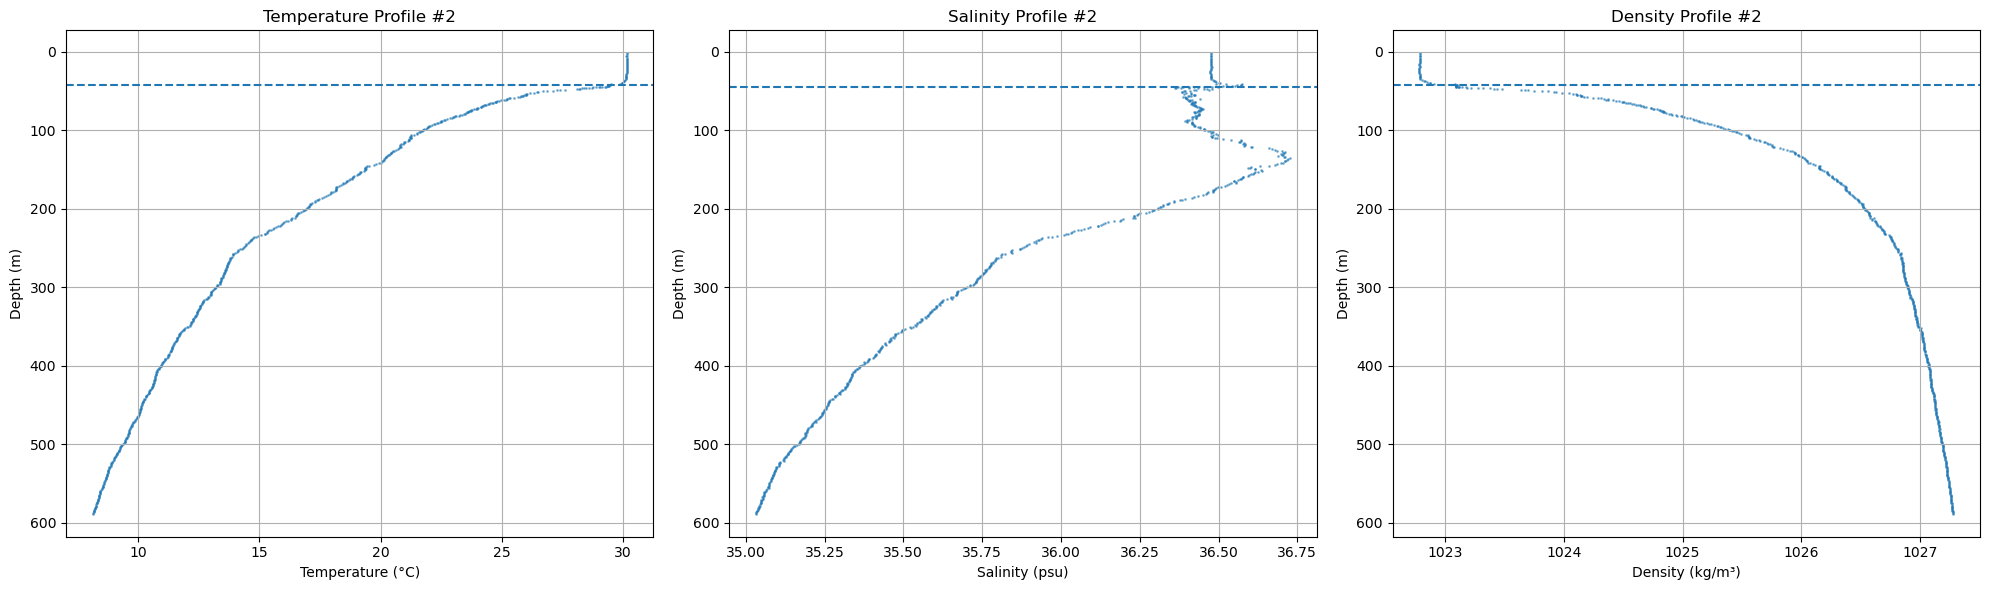

In [3]:
mld_table = calculate_MLD(ds)# %% MLD
plot_MLD_profile(ds,2)

In [4]:
# AVISO Data
aviso_folder = "/unity/f1/ozavala/DATA/GOFFISH/AVISO/GoM/"
bbox = [17.5, 32.5, -110, -80]
start_date = datetime.datetime(2016, 8, 6)
end_date = datetime.datetime(2016, 9, 5)
delta = datetime.timedelta(days=1)
position = ds.groupby('profile_id')[['lat', 'lon']].first()

Closest time index: 5
_show_var_names = True


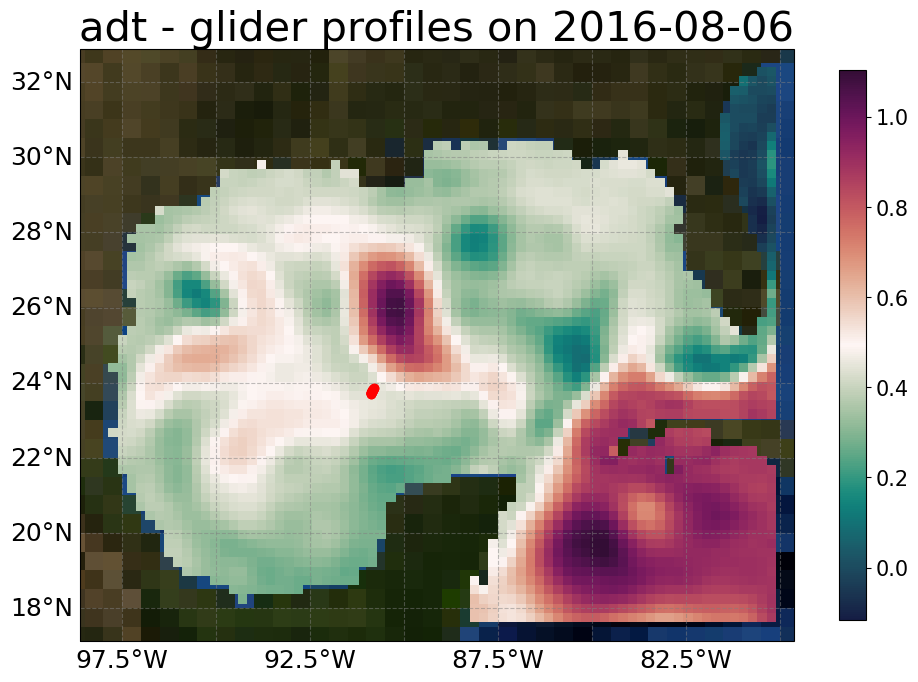

date		lat			lon			AVISO SSH
2016-08-06	23.711061629784933	-90.88256967420153	0.44261836984726677
2016-08-06	23.711062423620486	-90.88253795093267	0.4426191076553331
2016-08-06	23.723188814076742	-90.87933976849853	0.4421190842871137
2016-08-06	23.745341140088442	-90.86776676262377	0.44132589597928246
2016-08-06	23.756822415384647	-90.86154026834095	0.44096151983122733
2016-08-06	23.718567530806904	-90.88298160442234	0.4422498660276226
2016-08-06	23.719821573277702	-90.88257784624237	0.4421999221862424
2016-08-06	23.728104660292722	-90.87675867511042	0.44194863888763214
2016-08-06	23.739379616491632	-90.87109420137149	0.4415313085183391
2016-08-06	23.76359470277311	-90.85713540488638	0.44078792135202477
2016-08-06	23.775117843282366	-90.85091120099256	0.44049723405419455
2016-08-06	23.782521846768606	-90.84617832435946	0.4403590412164335
2016-08-06	23.794182250251417	-90.84094227492345	0.4401049600381223
2016-08-06	23.802068969048978	-90.83598268476594	0.44001122110198015
2016-08-06	23.

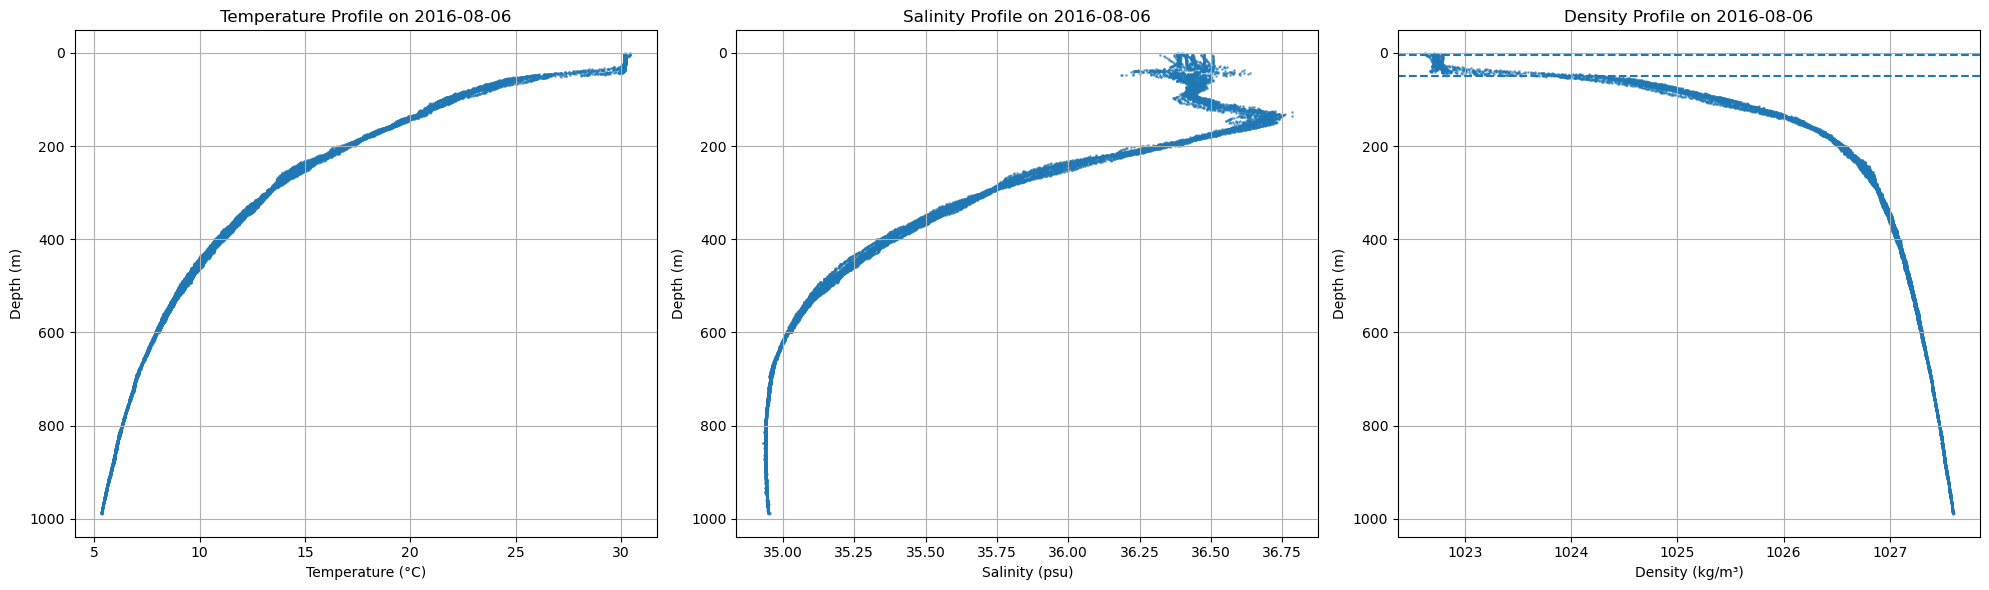

Closest time index: 6
_show_var_names = True


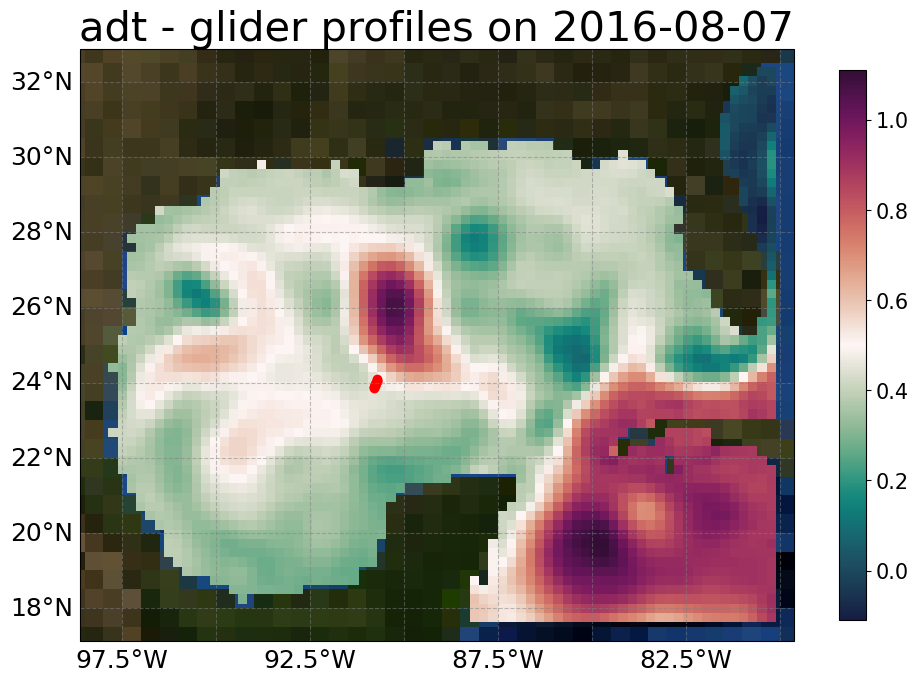

date		lat			lon			AVISO SSH
2016-08-07	23.868816220319488	-90.80554212847508	0.4507455716662647
2016-08-07	23.878922727326135	-90.7990171284277	0.4517388919960849
2016-08-07	23.89818389810049	-90.79272165912585	0.4538328565083027
2016-08-07	23.909814705152186	-90.78573796225298	0.4555481042240046
2016-08-07	23.929778224658854	-90.77790311442824	0.4581849166540958
2016-08-07	23.944359771859737	-90.77233799104427	0.46021246062704324
2016-08-07	23.96483068882248	-90.7631721301523	0.4634372503400329
2016-08-07	23.97939009710103	-90.7559787361893	0.4659829883336813
2016-08-07	23.999868833565667	-90.74588635393562	0.4697810403621083
2016-08-07	24.01541456836257	-90.73795349214471	0.47288700815534246
2016-08-07	24.03613348273271	-90.7299367792196	0.47676134360648353
2016-08-07	24.051431357651175	-90.72293415648352	0.4799798083470691
2016-08-07	24.071809549771274	-90.71432849532184	0.4843164055595609
2016-08-07	24.08597040032919	-90.70712581564804	0.4877388392873035


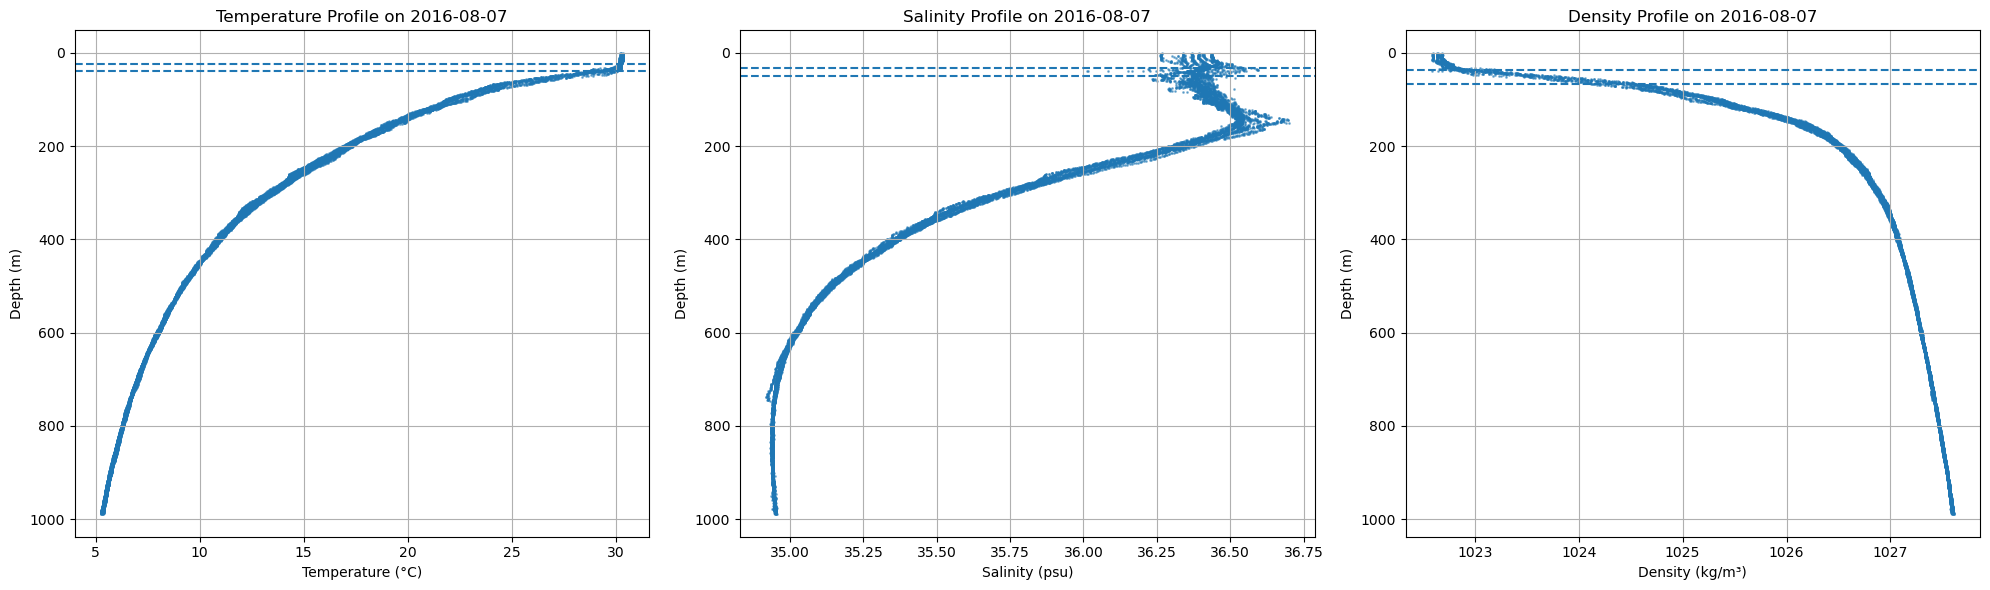

Closest time index: 7
_show_var_names = True


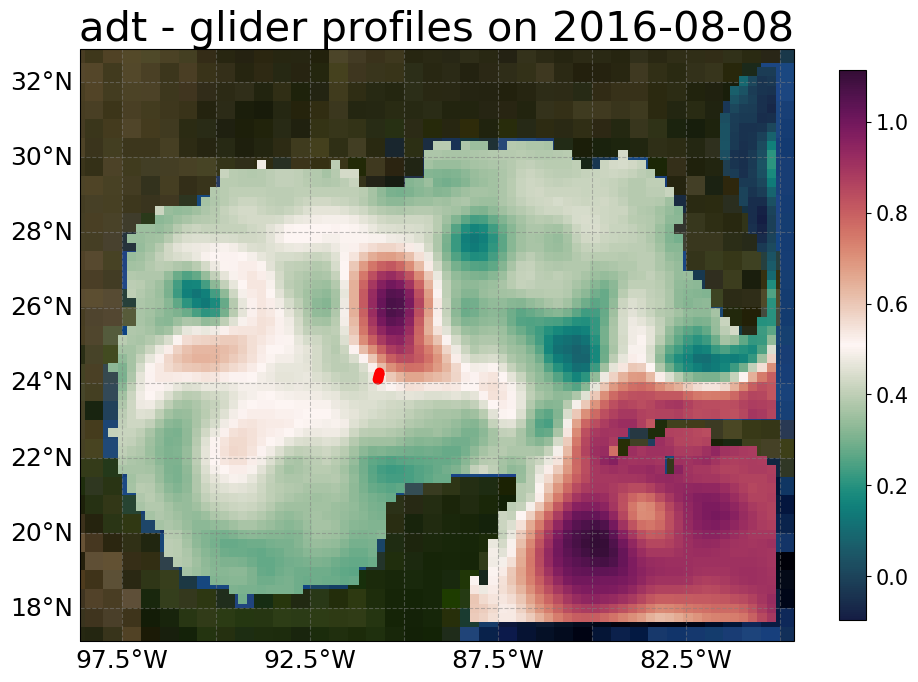

date		lat			lon			AVISO SSH
2016-08-08	24.08597040032919	-90.70712581564804	0.5103280514012253
2016-08-08	24.105776399575344	-90.70022977775066	0.5154754352971457
2016-08-08	24.121269554266437	-90.69851161340888	0.5185877189394789
2016-08-08	24.142724261768933	-90.69138004120494	0.5262933555743948
2016-08-08	24.160371497071925	-90.6901500524614	0.5316449272661044
2016-08-08	24.18155286073711	-90.68072860246228	0.54059917002474
2016-08-08	24.20095337038242	-90.68055860272301	0.5462133814085887
2016-08-08	24.221743013786465	-90.66967253496861	0.5557961274499679
2016-08-08	24.284608497023868	-90.66058416344137	0.5773867125818416
2016-08-08	24.244798615103218	-90.6709336024174	0.5620811072837134
2016-08-08	24.263441308628295	-90.65959650513858	0.5714824674415584


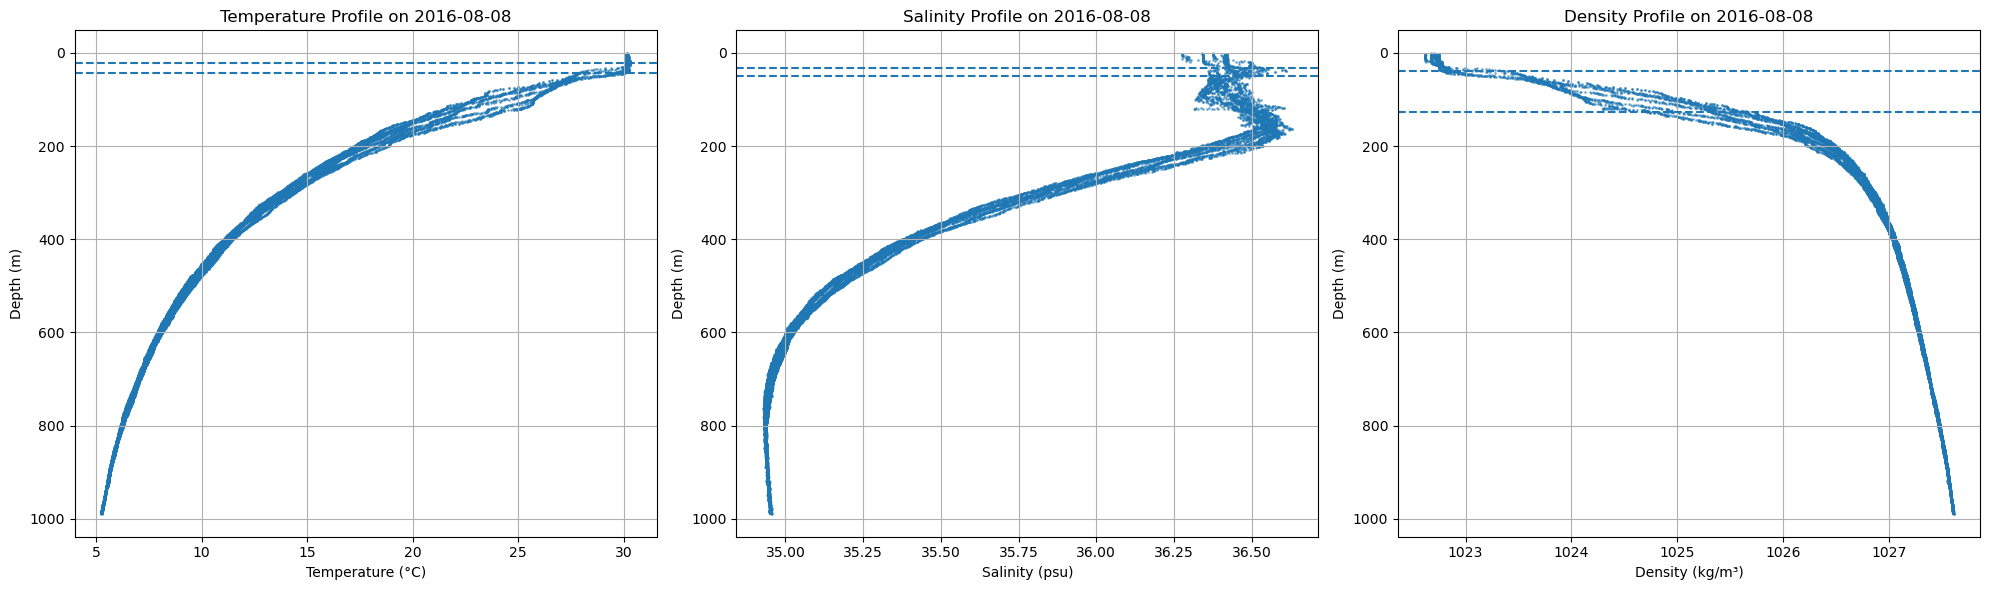

Closest time index: 8
_show_var_names = True


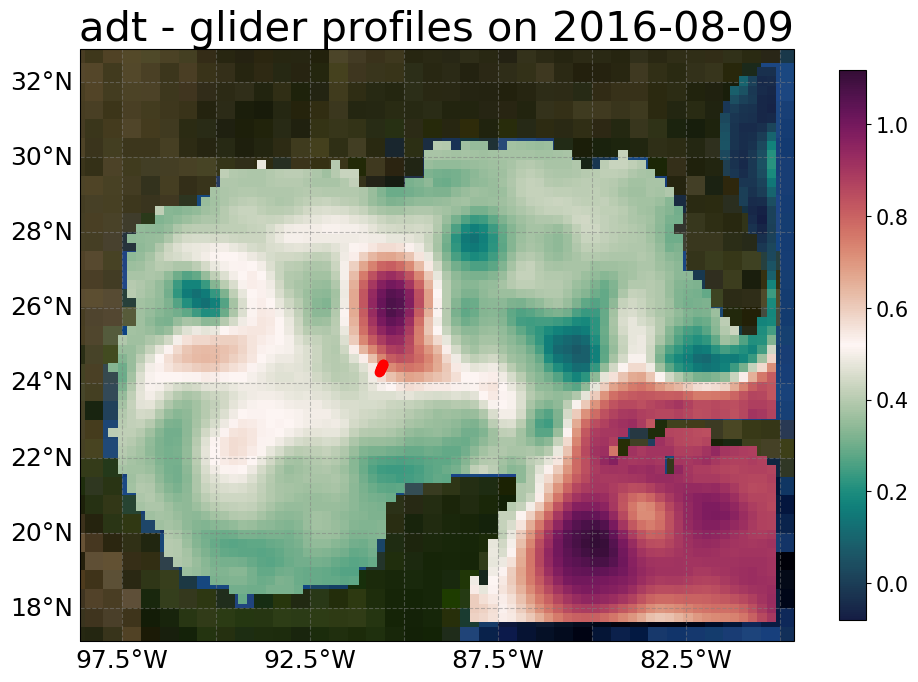

date		lat			lon			AVISO SSH
2016-08-09	24.284608497023868	-90.66058416344137	0.6060132903503963
2016-08-09	24.303735319687938	-90.65176690850032	0.6151439313620557
2016-08-09	24.32161933411749	-90.64756064561291	0.6222492879266823
2016-08-09	24.338131987683255	-90.63738583369866	0.6313977692394037
2016-08-09	24.35471326226255	-90.63334287110632	0.6382281313553918
2016-08-09	24.370251020710846	-90.6240340333728	0.6468790225118811
2016-08-09	24.41374383728427	-90.60763777776053	0.6664725582240661
2016-08-09	24.426828919317472	-90.59768444035069	0.6739274345449701
2016-08-09	24.386572902641678	-90.62075450021118	0.6532998199777681
2016-08-09	24.399945388661557	-90.61166341005385	0.6605815830185356
2016-08-09	24.469505458555453	-90.57929637711173	0.6939831128947691
2016-08-09	24.48222929041113	-90.57012074402485	0.7010958761132169
2016-08-09	24.495474934883017	-90.56782689697816	0.7062876610032627
2016-08-09	24.508522063837297	-90.55943233275599	0.7132786651062178
2016-08-09	24.44154019878

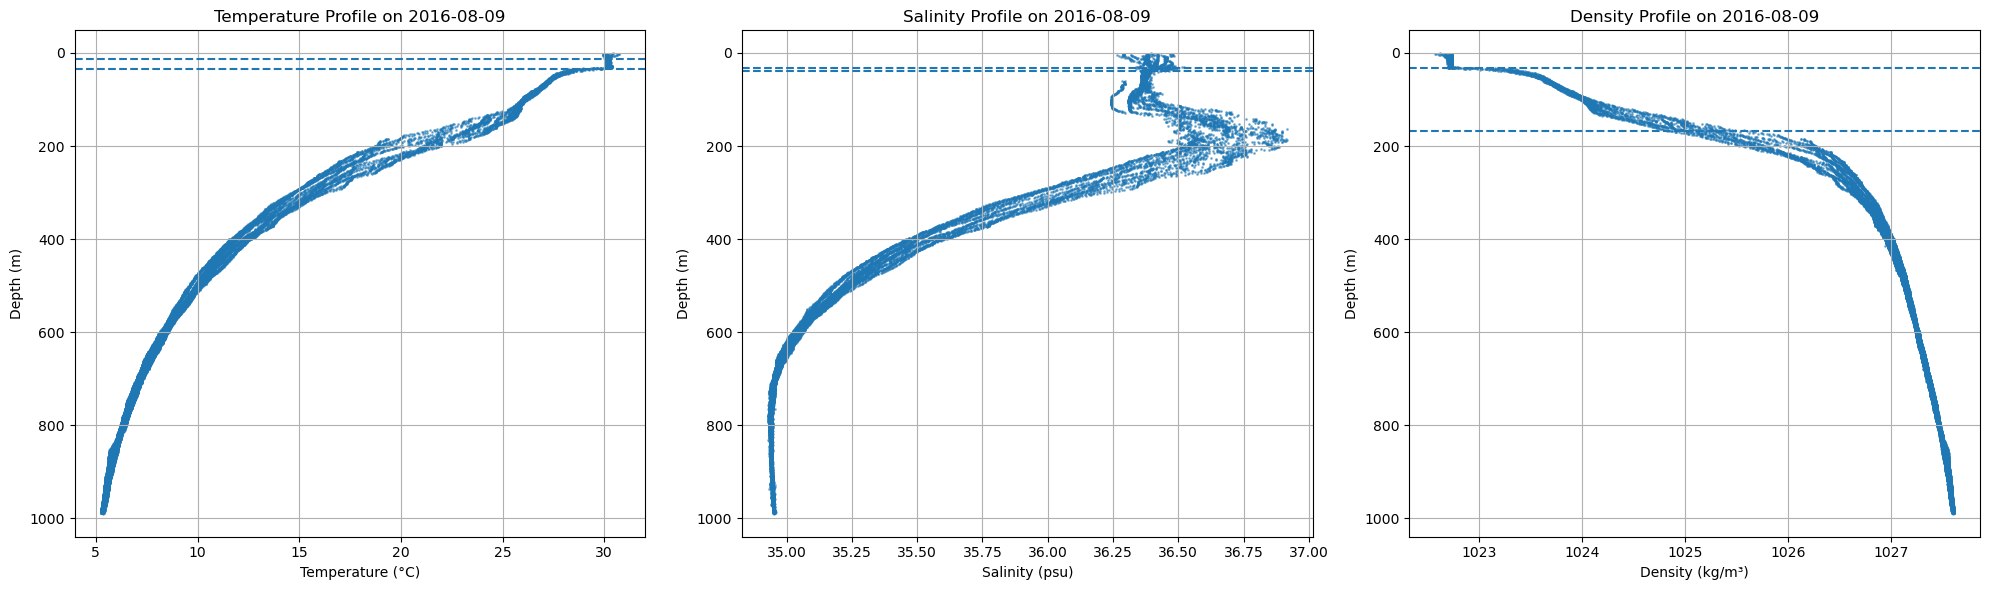

Closest time index: 9
_show_var_names = True


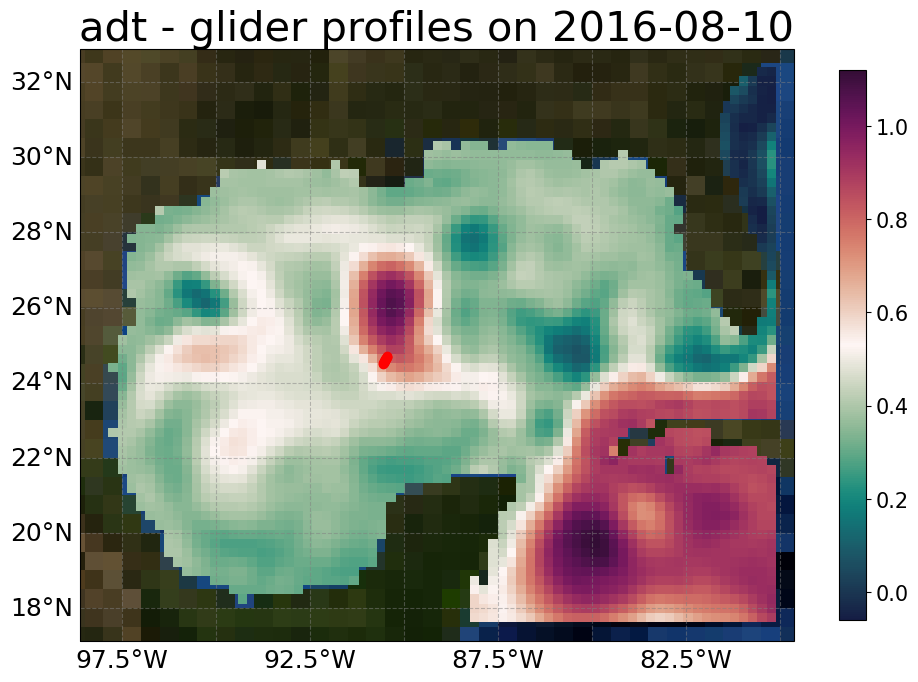

date		lat			lon			AVISO SSH
2016-08-10	24.508522063837297	-90.55943233275599	0.7313851502758274
2016-08-10	24.569101896126245	-90.52869685367305	0.758334532288699
2016-08-10	24.58080903092632	-90.51792645643634	0.7647709875296426
2016-08-10	24.52201329533168	-90.5564186103028	0.7364098446985139
2016-08-10	24.533415007369186	-90.54646322854546	0.7425508709391899
2016-08-10	24.54548917855565	-90.54245831090886	0.7473797079280425
2016-08-10	24.556939055737462	-90.53262835336875	0.7534994504714001
2016-08-10	24.645886016794154	-90.48155844511153	0.793521438528342
2016-08-10	24.65900472749771	-90.47125110484993	0.7995834177585591
2016-08-10	24.61950752363696	-90.49762874444066	0.7821264087222359
2016-08-10	24.63271055409664	-90.48729402284422	0.7885528481933491
2016-08-10	24.593545231354756	-90.51341138290755	0.7699323846775614
2016-08-10	24.60635858586641	-90.50268626076593	0.776700391022581
2016-08-10	24.698500327081874	-90.45019557686307	0.8151263973769263
2016-08-10	24.67266047656335	-9

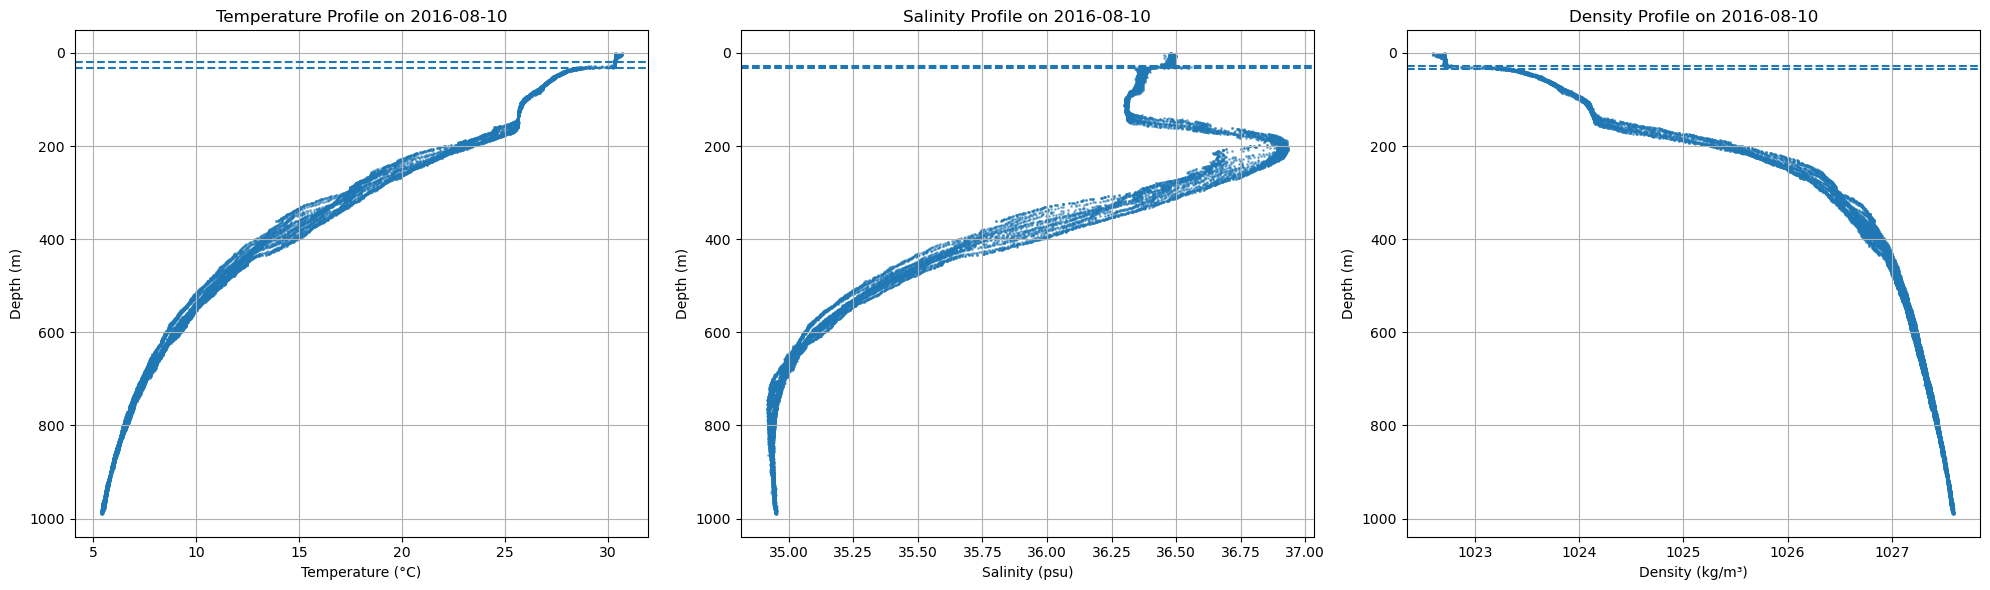

Closest time index: 10
_show_var_names = True


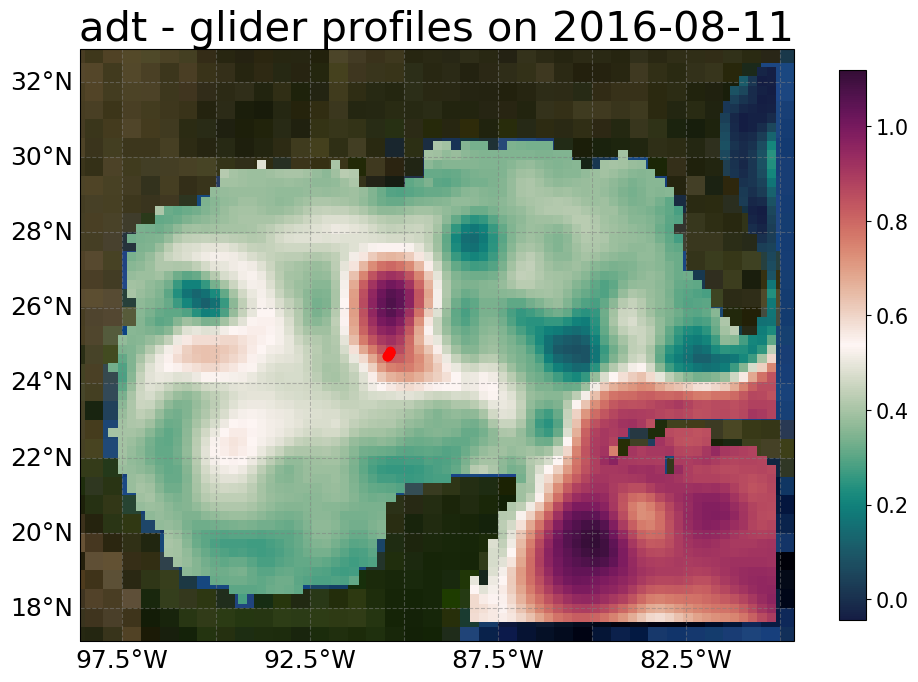

date		lat			lon			AVISO SSH
2016-08-11	24.698500327081874	-90.45019557686307	0.8216968459265975
2016-08-11	24.71018864155778	-90.44116816827567	0.8262376864911121
2016-08-11	24.720465989543687	-90.43559354101363	0.8297409761001023
2016-08-11	24.732347576616792	-90.42551464030355	0.8344580175521897
2016-08-11	24.786368157451495	-90.39481670783758	0.8526003732378971
2016-08-11	24.798617685153808	-90.38493902678907	0.8571475834900734
2016-08-11	24.74258726270113	-90.42146367651395	0.8376108991582805
2016-08-11	24.754967319263017	-90.41187509037348	0.8422775081946088
2016-08-11	24.764763295429287	-90.40855610974307	0.8451494779563768
2016-08-11	24.776999872279315	-90.399478929985	0.849619707379685
2016-08-11	24.82896355207484	-90.36772755115378	0.8652540278415762
2016-08-11	24.84007595714981	-90.36360611566043	0.8674510784165219
2016-08-11	24.808483735206647	-90.37981639795298	0.8602765882981773
2016-08-11	24.819788004983597	-90.3715251020567	0.863446425725591


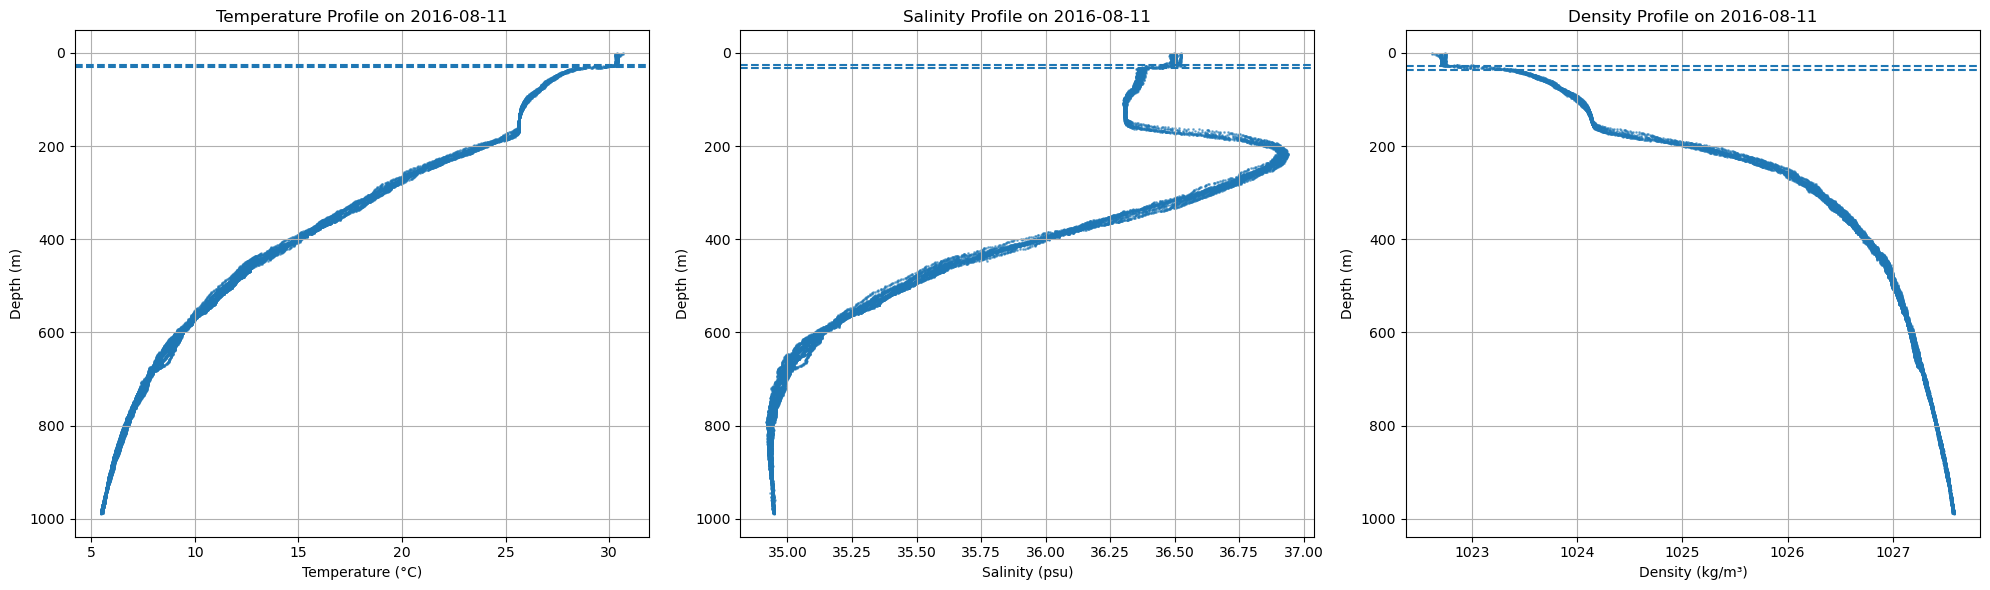

Closest time index: 11
_show_var_names = True


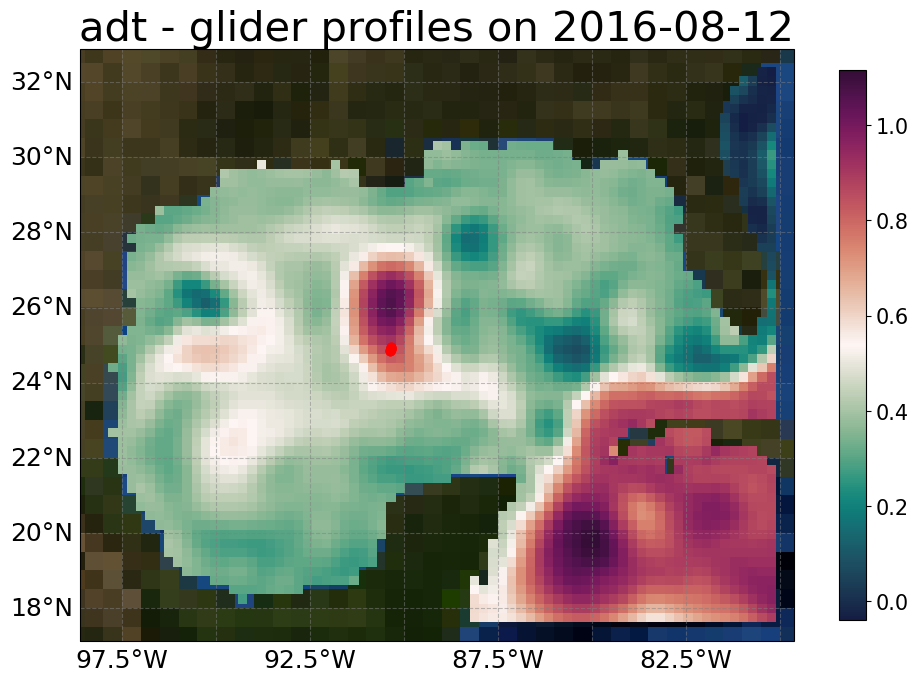

date		lat			lon			AVISO SSH
2016-08-12	24.845976581953668	-90.36514432408256	0.8606835793405391
2016-08-12	24.855446944415583	-90.36226919328502	0.8620257277745899
2016-08-12	24.84007595714981	-90.36360611566043	0.8594178342446084
2016-08-12	24.86029313704107	-90.36478010001403	0.8632339807736432
2016-08-12	24.872816528768457	-90.36106593496508	0.8650000961398325
2016-08-12	24.89798626012484	-90.35602309230107	0.8688265257630788
2016-08-12	24.909803374292128	-90.35048868279038	0.8701456621791778
2016-08-12	24.879904001364654	-90.35995568815076	0.8661257866685869
2016-08-12	24.891231854851725	-90.3552215069868	0.8675025573819483
2016-08-12	24.91704975476903	-90.34965461134529	0.8713143539150794
2016-08-12	24.92921036588011	-90.34495938094533	0.8727786795880598
2016-08-12	24.937323703452922	-90.34273314077141	0.8738780638143202
2016-08-12	24.94789265371312	-90.3384206922184	0.8750817766466041
2016-08-12	24.956780287986653	-90.33717797697022	0.8764479546342989


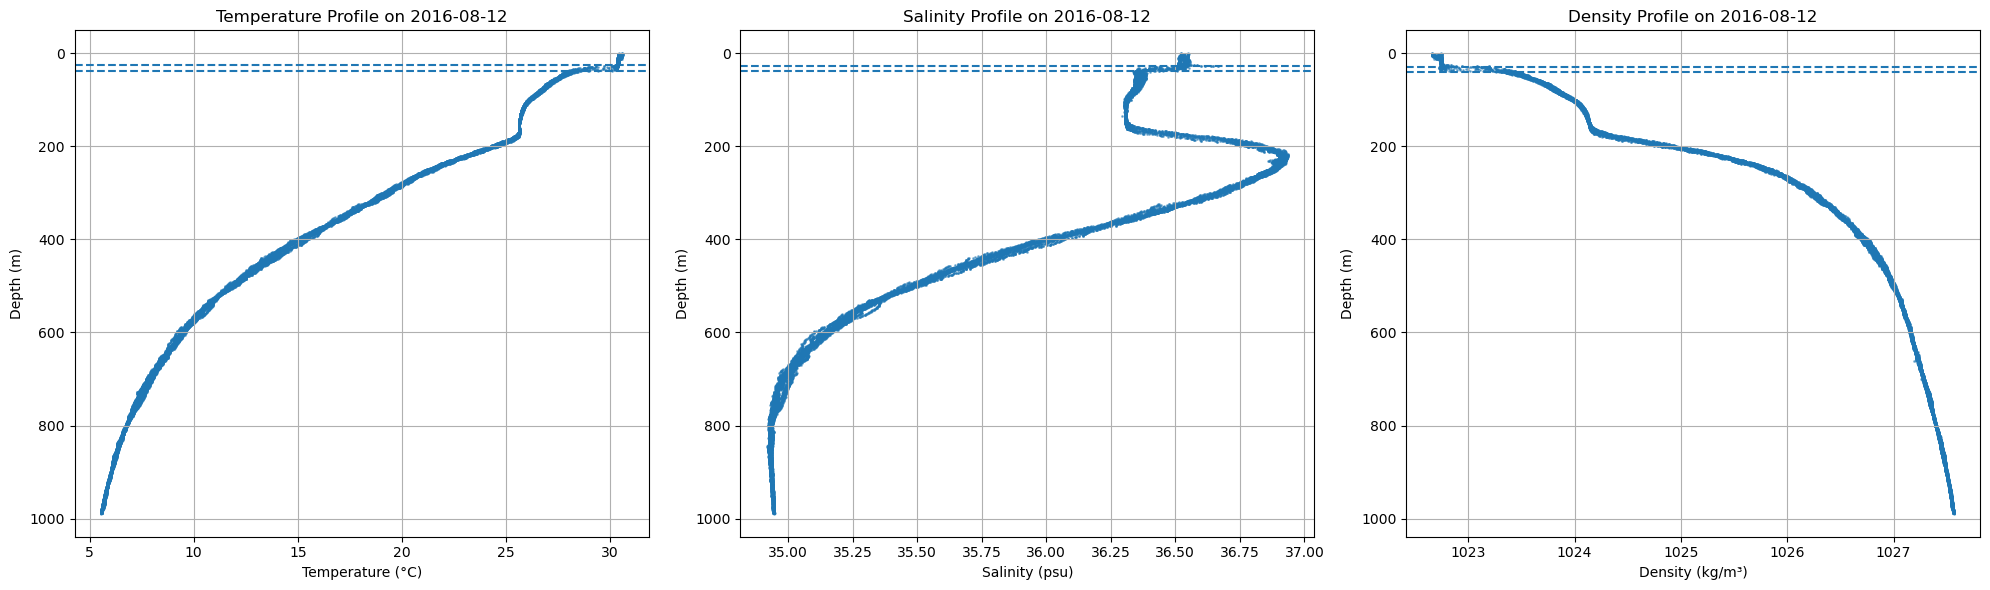

Closest time index: 12
_show_var_names = True


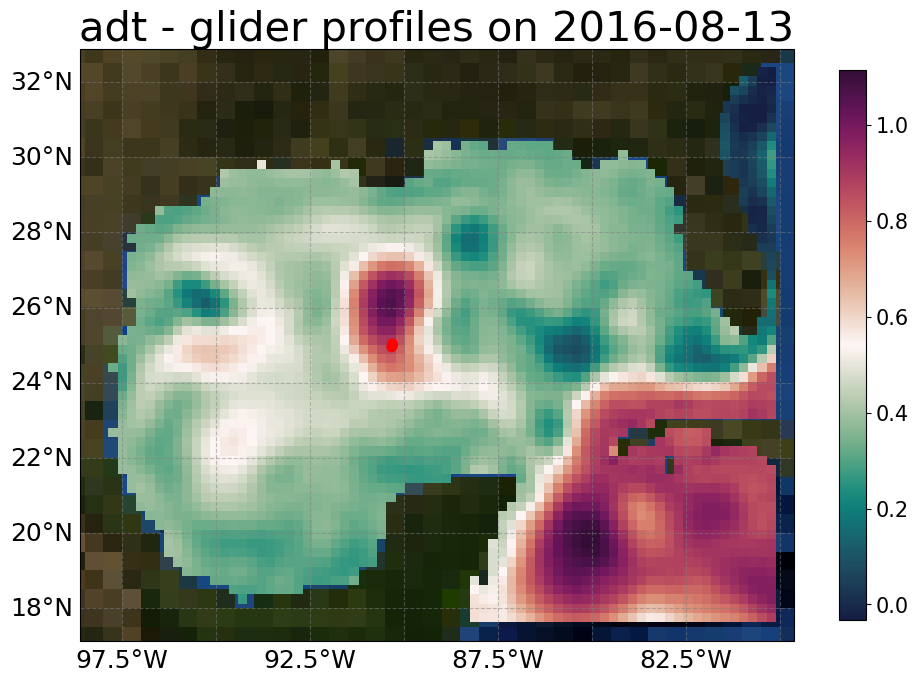

date		lat			lon			AVISO SSH
2016-08-13	24.956780287986653	-90.33717797697022	0.8621044326663986
2016-08-13	24.96571598520322	-90.33432883216854	0.8630618299180717
2016-08-13	24.972893373993973	-90.334308678825	0.8643075077174184
2016-08-13	24.98193743950538	-90.33007104895259	0.8649755687989567
2016-08-13	24.987438109034073	-90.3308159536668	0.8660899870272007
2016-08-13	24.99687471111293	-90.32834619799544	0.8671940495053188
2016-08-13	25.000847787503133	-90.33026347335174	0.868298236290542
2016-08-13	25.009651506855132	-90.32791908636345	0.8693141936498171
2016-08-13	25.02701246674996	-90.32697849422891	0.8721127398057513
2016-08-13	25.036907060923408	-90.32438279098044	0.8732472777358815
2016-08-13	25.01315366362564	-90.32975659126268	0.870322739997156
2016-08-13	25.02333229172924	-90.32534342151426	0.8711156379795294
2016-08-13	25.042486509497746	-90.32514253081015	0.874380100745877
2016-08-13	25.05271851165971	-90.32018427928364	0.8750324974787838
2016-08-13	25.058482893781342	-90

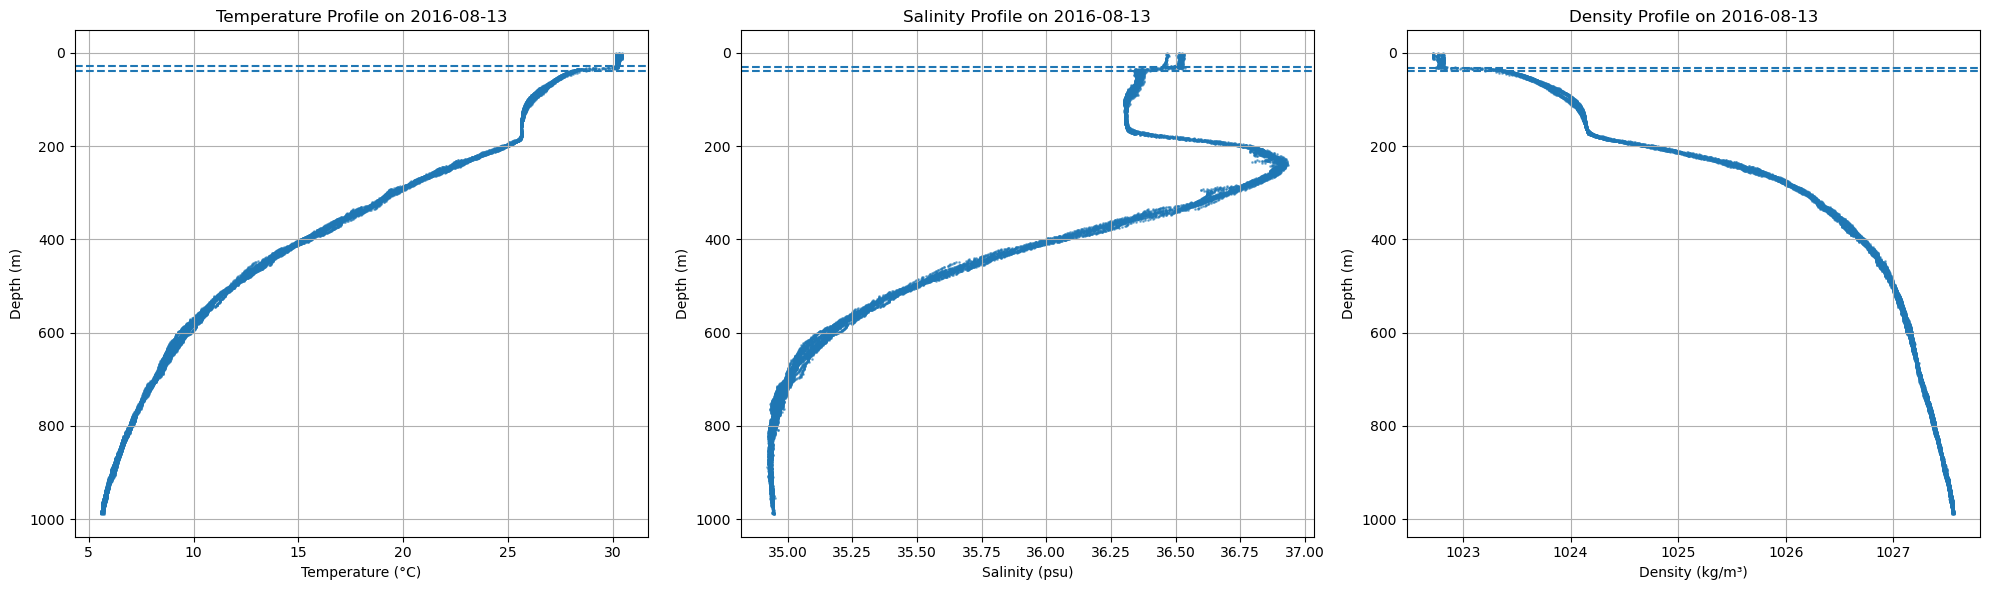

Closest time index: 13
_show_var_names = True


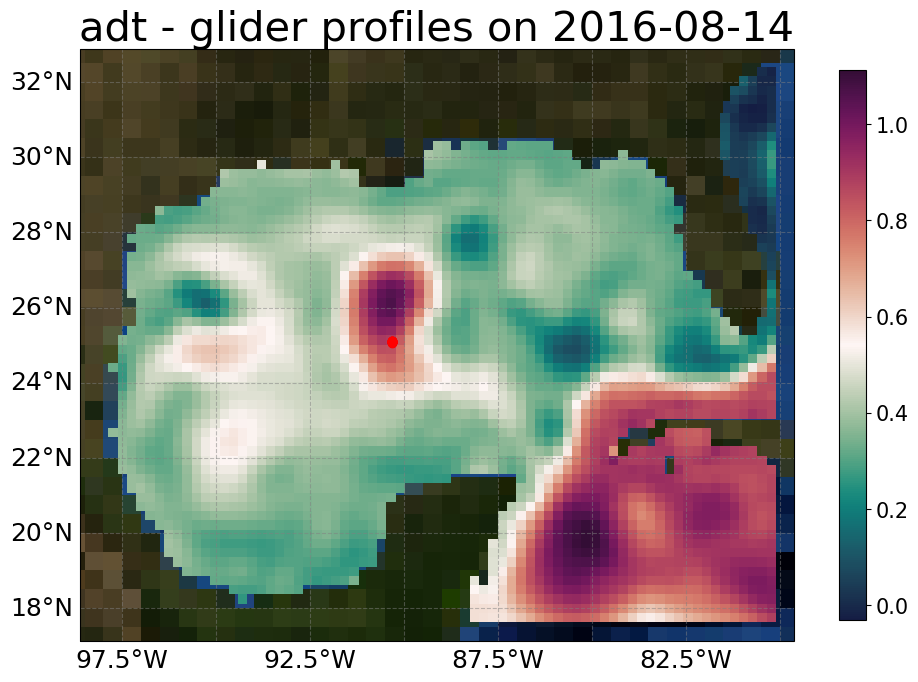

date		lat			lon			AVISO SSH
2016-08-14	25.084029002670274	-90.32111170832061	0.8637588991343697
2016-08-14	25.09010190417526	-90.31811103250563	0.8639703762325541
2016-08-14	25.06773057304042	-90.31987664970684	0.8607285371160956
2016-08-14	25.07246385937476	-90.32239813982665	0.8621793726712363
2016-08-14	25.080319450508057	-90.32086858034386	0.8630789664609642
2016-08-14	25.090299262733506	-90.32013871822207	0.8645412114129764
2016-08-14	25.095611161455434	-90.3178222229624	0.864806618413367
2016-08-14	25.099054212021763	-90.31771071344842	0.8653474657071846
2016-08-14	25.105322607248493	-90.31545692933635	0.8657854085538937
2016-08-14	25.09471434888671	-90.31934333693502	0.8650622105999609
2016-08-14	25.100423150483625	-90.3166600870821	0.8652946615270144
2016-08-14	25.103597806460336	-90.3168506584817	0.8658711917356479
2016-08-14	25.109986202192157	-90.31451351227645	0.8663055671813935


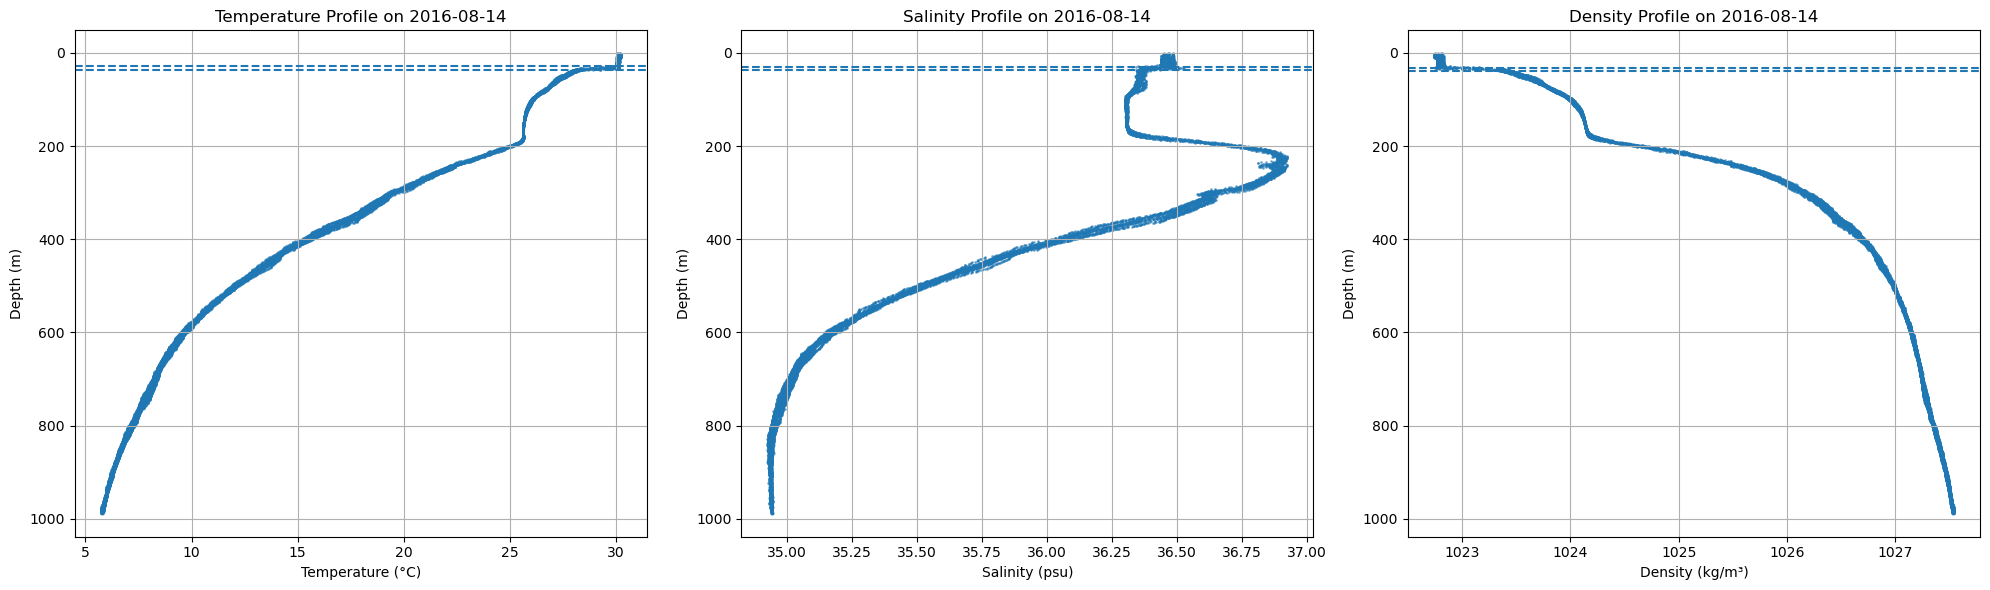

Closest time index: 14
_show_var_names = True


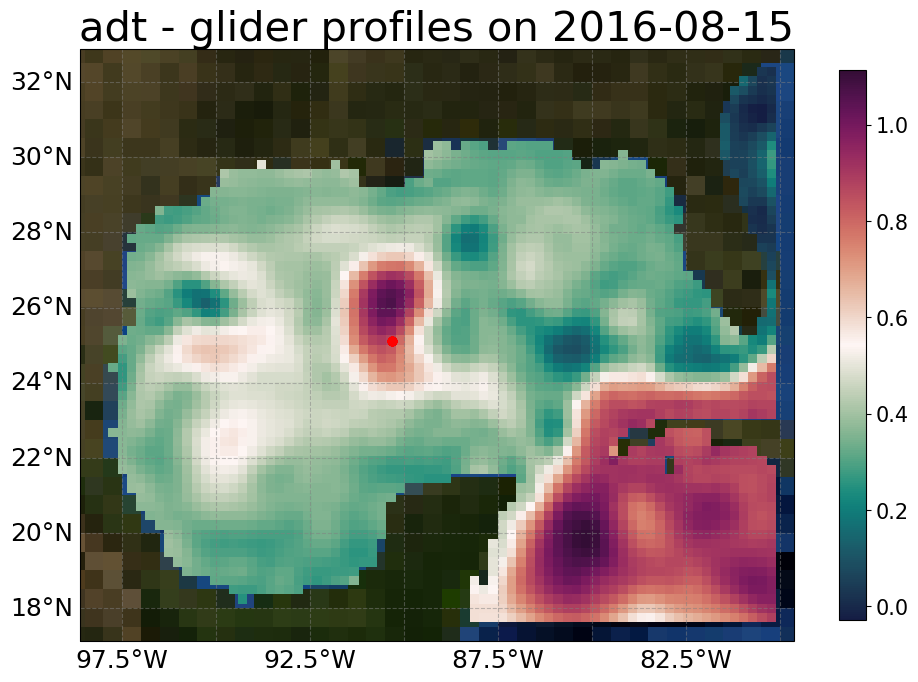

date		lat			lon			AVISO SSH
2016-08-15	25.106816657356923	-90.31606874071566	0.8489117359952734
2016-08-15	25.111658282944035	-90.31577963047096	0.8496540584501502
2016-08-15	25.10959141420097	-90.31823967582626	0.8500400075518106
2016-08-15	25.11403881099978	-90.31656913583238	0.8502994369135748
2016-08-15	25.112772736295838	-90.32256093714146	0.8518857984858572
2016-08-15	25.11746825173054	-90.32294524406814	0.8528074496559417
2016-08-15	25.11275076679111	-90.32474754809002	0.8525400954836643
2016-08-15	25.11764467687448	-90.32177500731046	0.8524852443663794
2016-08-15	25.11003505068538	-90.32048159130981	0.850790438462332
2016-08-15	25.114516048746474	-90.32026787278237	0.8514946864453049
2016-08-15	25.113521605744094	-90.32328038313126	0.8522308767446467
2016-08-15	25.118575441551776	-90.32360571555472	0.8531964746167857


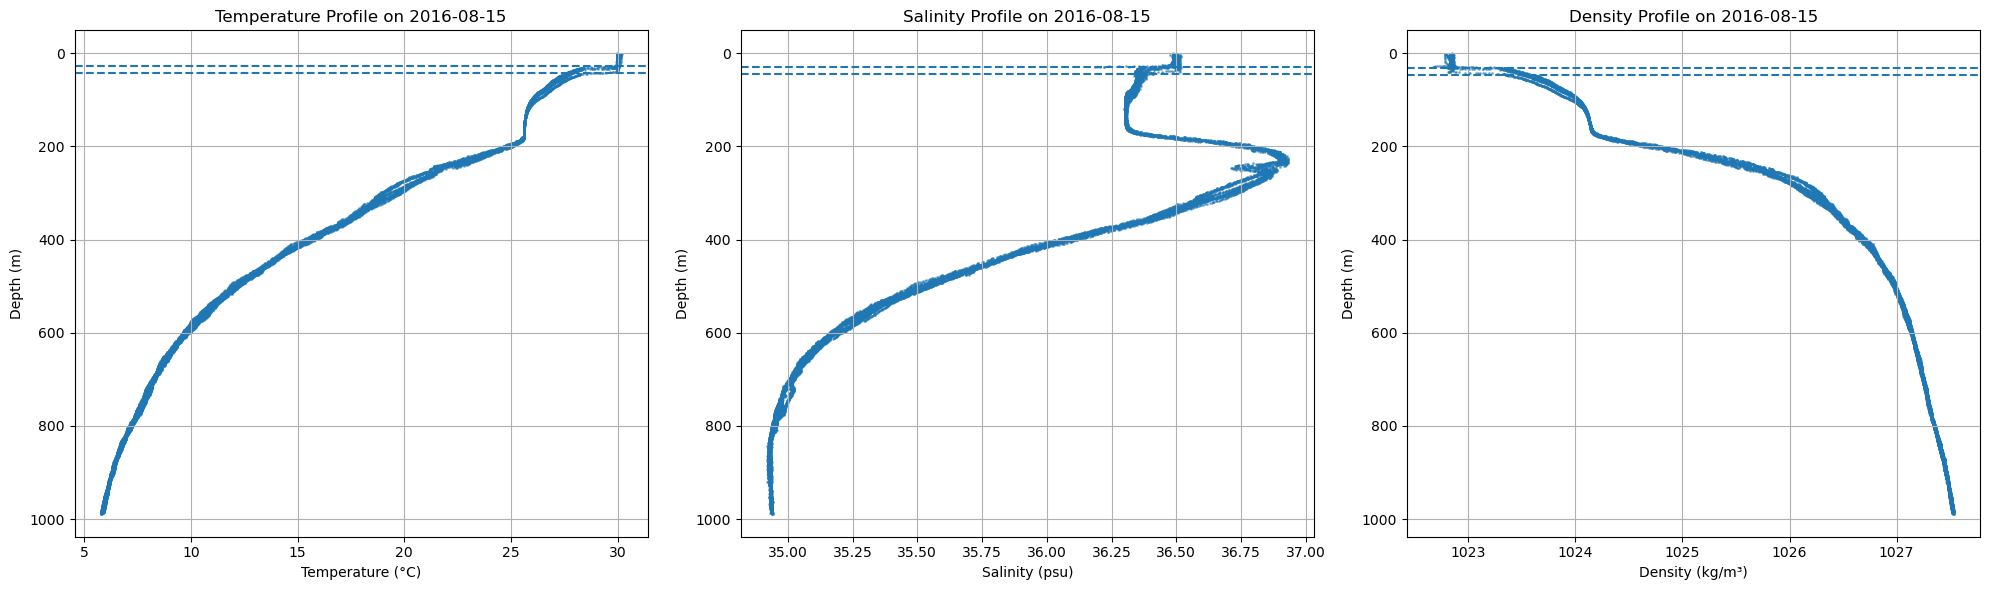

Closest time index: 15
_show_var_names = True


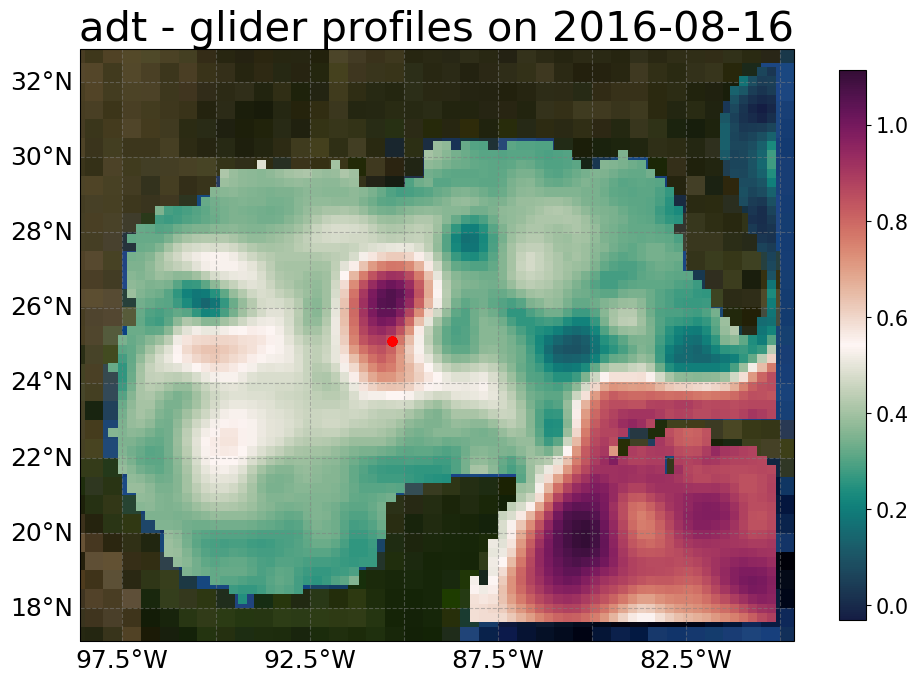

date		lat			lon			AVISO SSH
2016-08-16	25.114139547746642	-90.32696138256354	0.8360357449905236
2016-08-16	25.118583611476964	-90.32608199630525	0.8365849456507468
2016-08-16	25.110977276006835	-90.3297541449304	0.8363591742066722
2016-08-16	25.113819719141517	-90.32682188710952	0.8359294170714013
2016-08-16	25.118575441551776	-90.32360571555472	0.8357678299417034
2016-08-16	25.101219726141334	-90.3245686412832	0.832808034818029
2016-08-16	25.104084105550623	-90.32151438955515	0.8323418664576685
2016-08-16	25.104642959111448	-90.32587903024395	0.8338863969034619
2016-08-16	25.10773287654213	-90.32318790668528	0.8335826750206117
2016-08-16	25.107875824209955	-90.3263937440654	0.8346663489584101
2016-08-16	25.111050700754078	-90.32493212555929	0.8347840053132656
2016-08-16	25.09726696435935	-90.32187079077569	0.8311717844150998
2016-08-16	25.098562537695507	-90.32155187140377	0.831311295348558


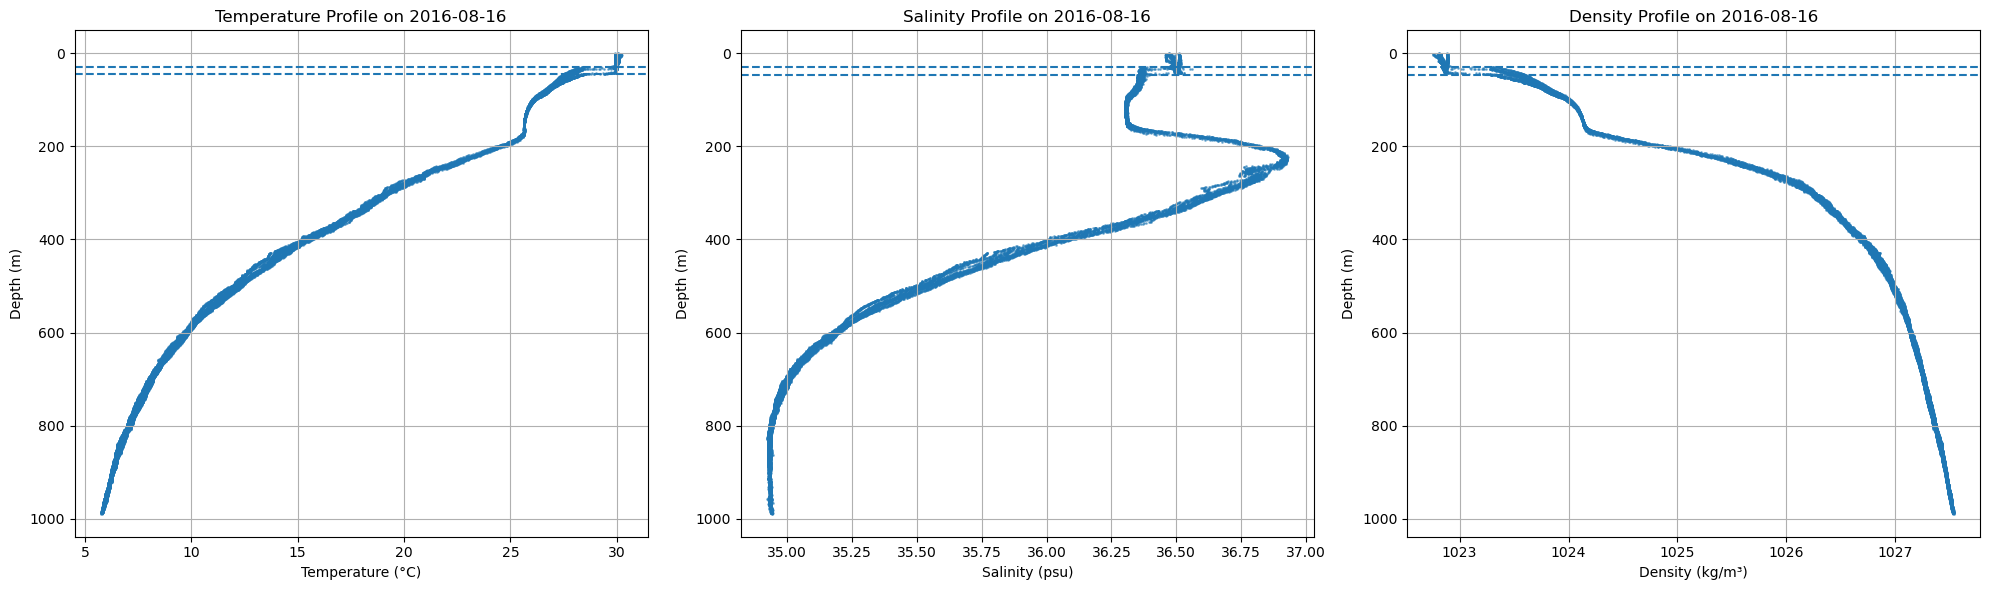

Closest time index: 16
_show_var_names = True


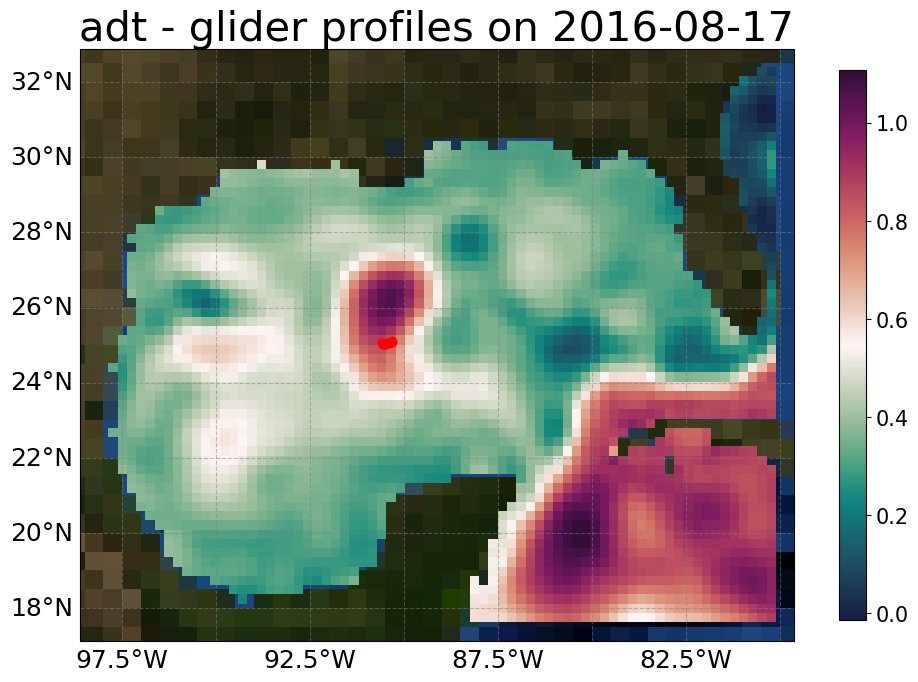

date		lat			lon			AVISO SSH
2016-08-17	25.098562537695507	-90.32155187140377	0.8182477905933493
2016-08-17	25.076231488836488	-90.36445364775294	0.8296349936001286
2016-08-17	25.070290981331485	-90.38513471366201	0.8341039358681803
2016-08-17	25.090081971725144	-90.32592848706064	0.8180929318950779
2016-08-17	25.084899308699363	-90.34685098481052	0.8248406591206133
2016-08-17	25.05262675242599	-90.44214937505213	0.8403444616724671
2016-08-17	25.049663113469723	-90.4615864524778	0.8431244055627896
2016-08-17	25.043447956180714	-90.48036567142438	0.8451601716875535
2016-08-17	25.04091715466088	-90.50054852220752	0.8481827303306984
2016-08-17	25.062523531101856	-90.40400276794706	0.8357548873215379
2016-08-17	25.05900743846753	-90.42423149006243	0.8385303567620384
2016-08-17	25.03269796475615	-90.55872421301139	0.8567747067458836
2016-08-17	25.042385989254974	-90.56731920162409	0.8601095651404659
2016-08-17	25.036550518897066	-90.5187974606542	0.8505221708030939
2016-08-17	25.036136534911

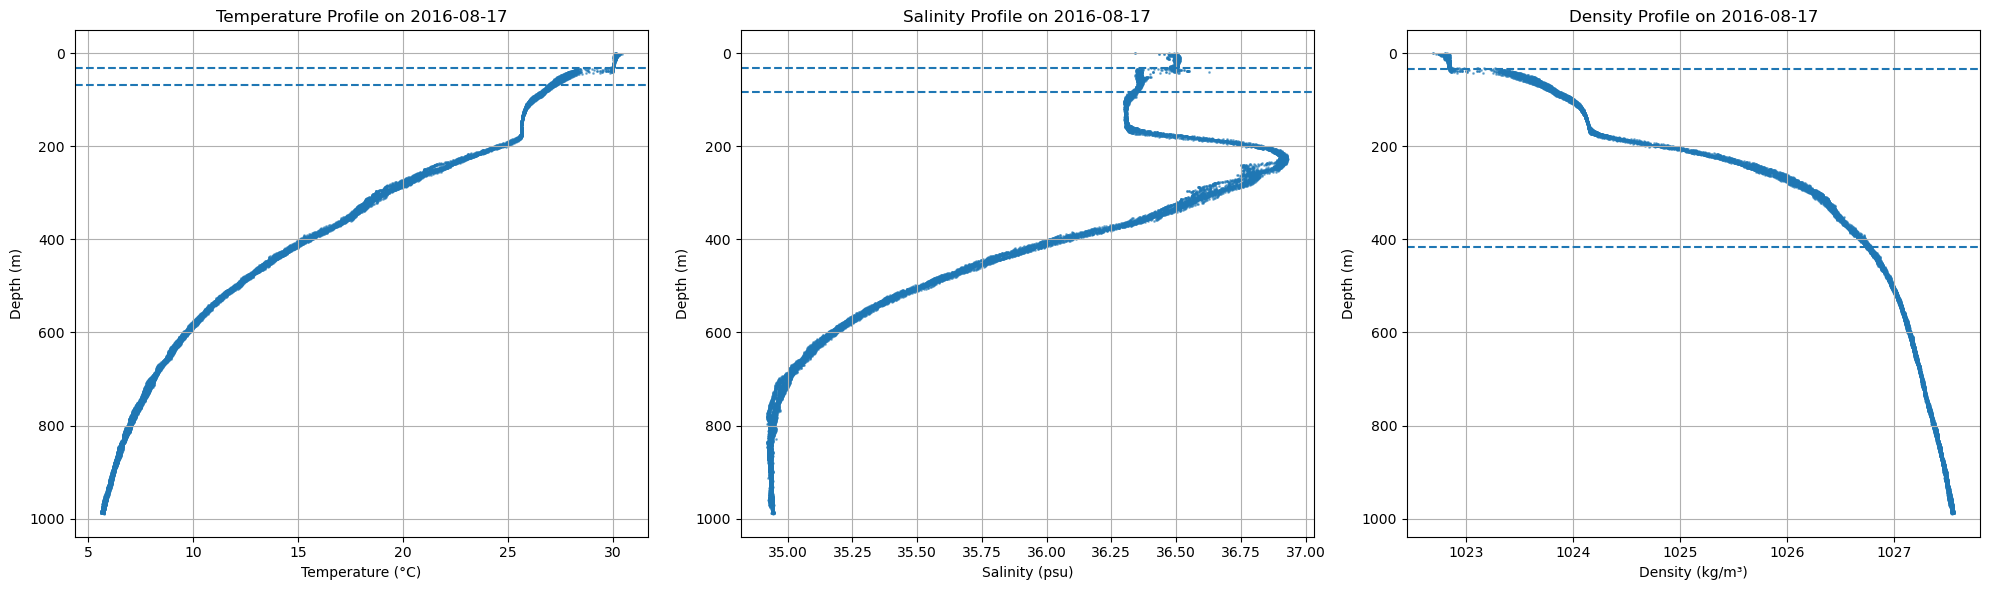

Closest time index: 17
_show_var_names = True


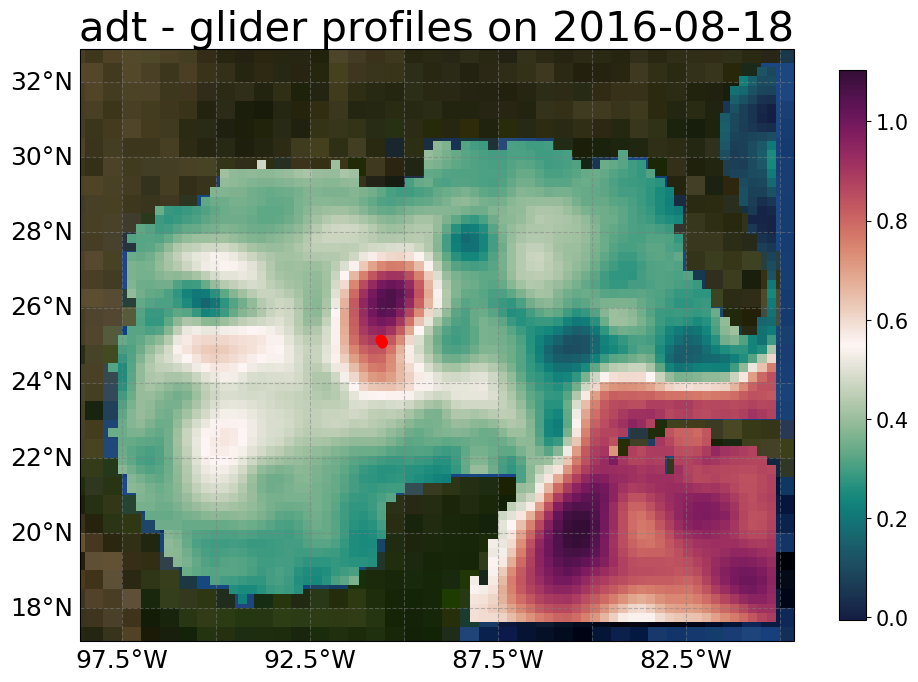

date		lat			lon			AVISO SSH
2016-08-18	25.05839810649038	-90.57864471949516	0.8570491126137787
2016-08-18	25.07990906798772	-90.58707878113198	0.8629059500515093
2016-08-18	25.08928431917979	-90.58913397228153	0.8651099507189814
2016-08-18	25.06441139633865	-90.58147900288336	0.8587917618519662
2016-08-18	25.074660409532267	-90.58416932641036	0.8613091992925541
2016-08-18	25.092674346136093	-90.59147433348575	0.8662261322080818
2016-08-18	25.10163231071586	-90.59446846721528	0.8685251669976438
2016-08-18	25.104679472759226	-90.59748482796566	0.8697018441081554
2016-08-18	25.11288897270029	-90.60134304966381	0.8720130315477845
2016-08-18	25.11311083088434	-90.60639997939003	0.873051405887751
2016-08-18	25.122035806128416	-90.61061631995933	0.8755456470181397
2016-08-18	25.13935760306323	-90.62424859280641	0.8823681047062927
2016-08-18	25.149402562866946	-90.6265774760019	0.8850856489932981
2016-08-18	25.125222011883757	-90.61615354780565	0.8772329526787135
2016-08-18	25.13491851152226	-

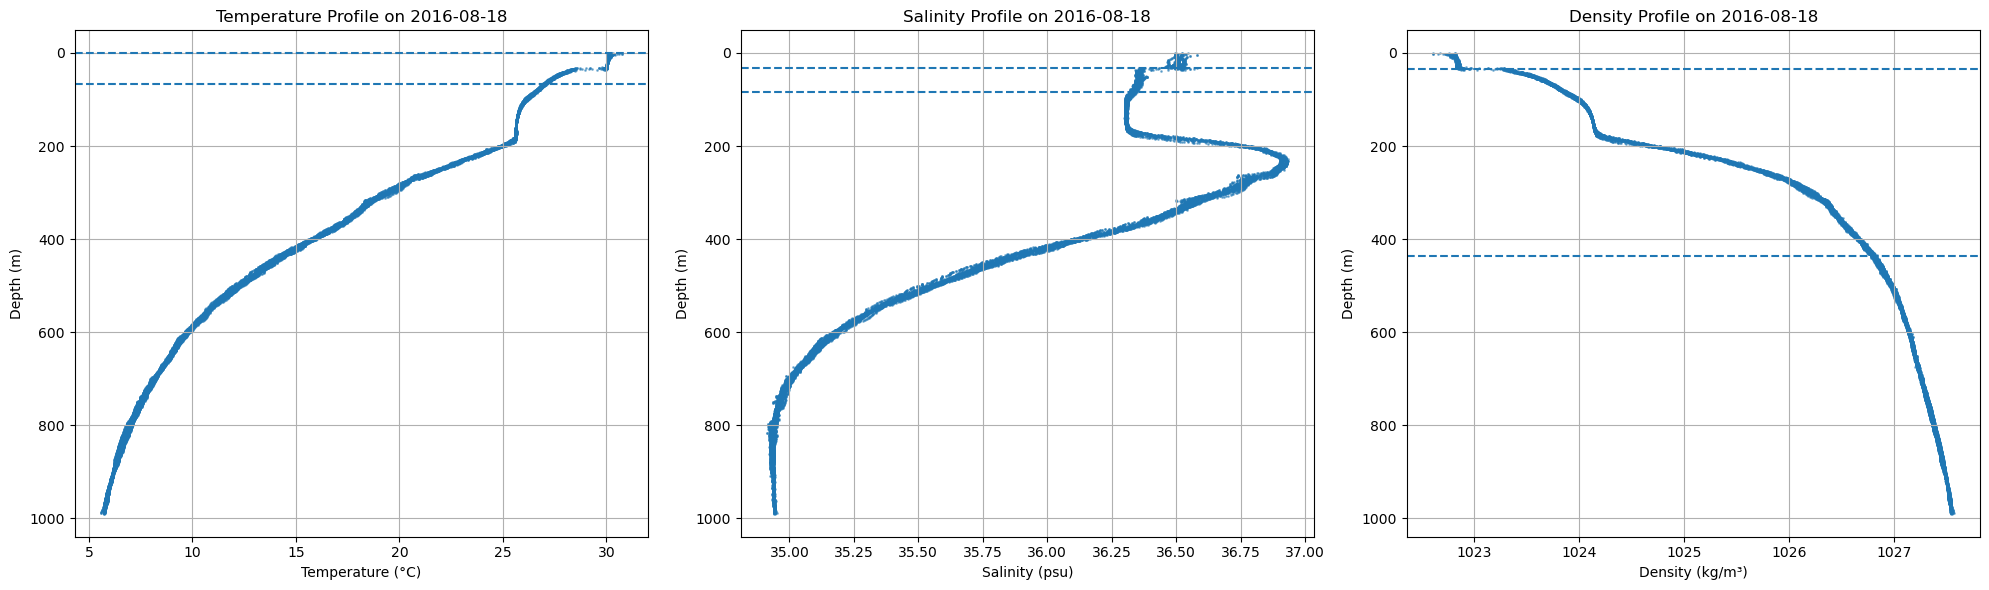

Closest time index: 18
_show_var_names = True


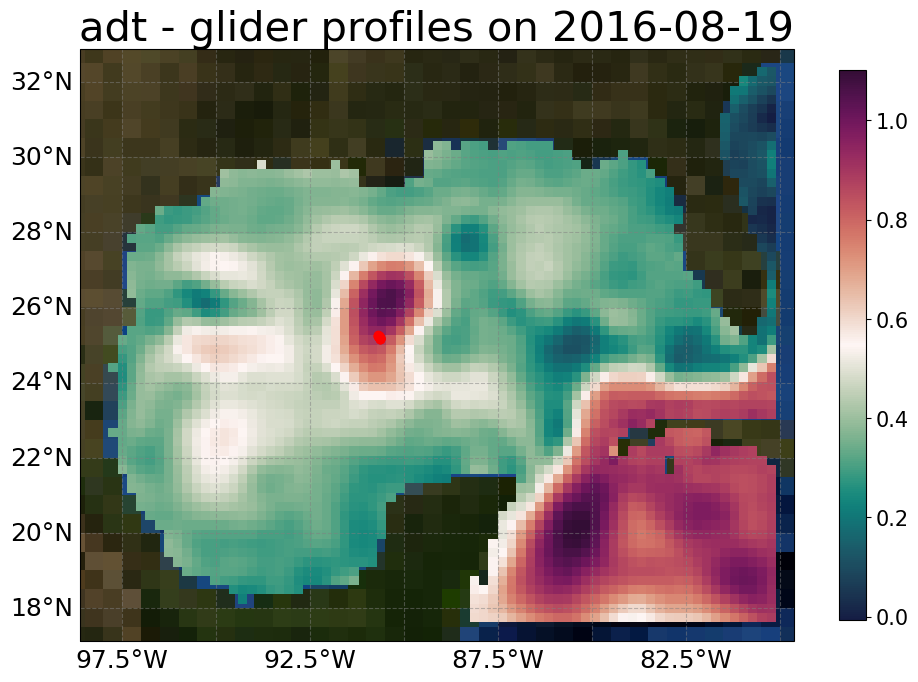

date		lat			lon			AVISO SSH
2016-08-19	25.17030711111717	-90.63591224250389	0.8901744303160861
2016-08-19	25.18087844504419	-90.63790884361443	0.8929066411572224
2016-08-19	25.154739723294394	-90.63071044396236	0.8860198823709375
2016-08-19	25.164379438786938	-90.63188332254165	0.8885034360035267
2016-08-19	25.185699874337647	-90.64183419676465	0.8942700968275867
2016-08-19	25.195351120934493	-90.64358248352812	0.8967388524512128
2016-08-19	25.199841196241994	-90.64820143837021	0.8980224836235664
2016-08-19	25.20947909418733	-90.65169742076337	0.9005232414798712
2016-08-19	25.214113873367392	-90.65827093013402	0.9018778700795558
2016-08-19	25.222544892753398	-90.66165594260391	0.90404115818488
2016-08-19	25.256569036655446	-90.68849469605532	0.9128867695441525
2016-08-19	25.26823264280229	-90.69114992240948	0.915688800809844
2016-08-19	25.23964374035954	-90.67738331840884	0.908605942250599
2016-08-19	25.250080100119103	-90.6816549014297	0.9111994725481088
2016-08-19	25.22630886260623	-

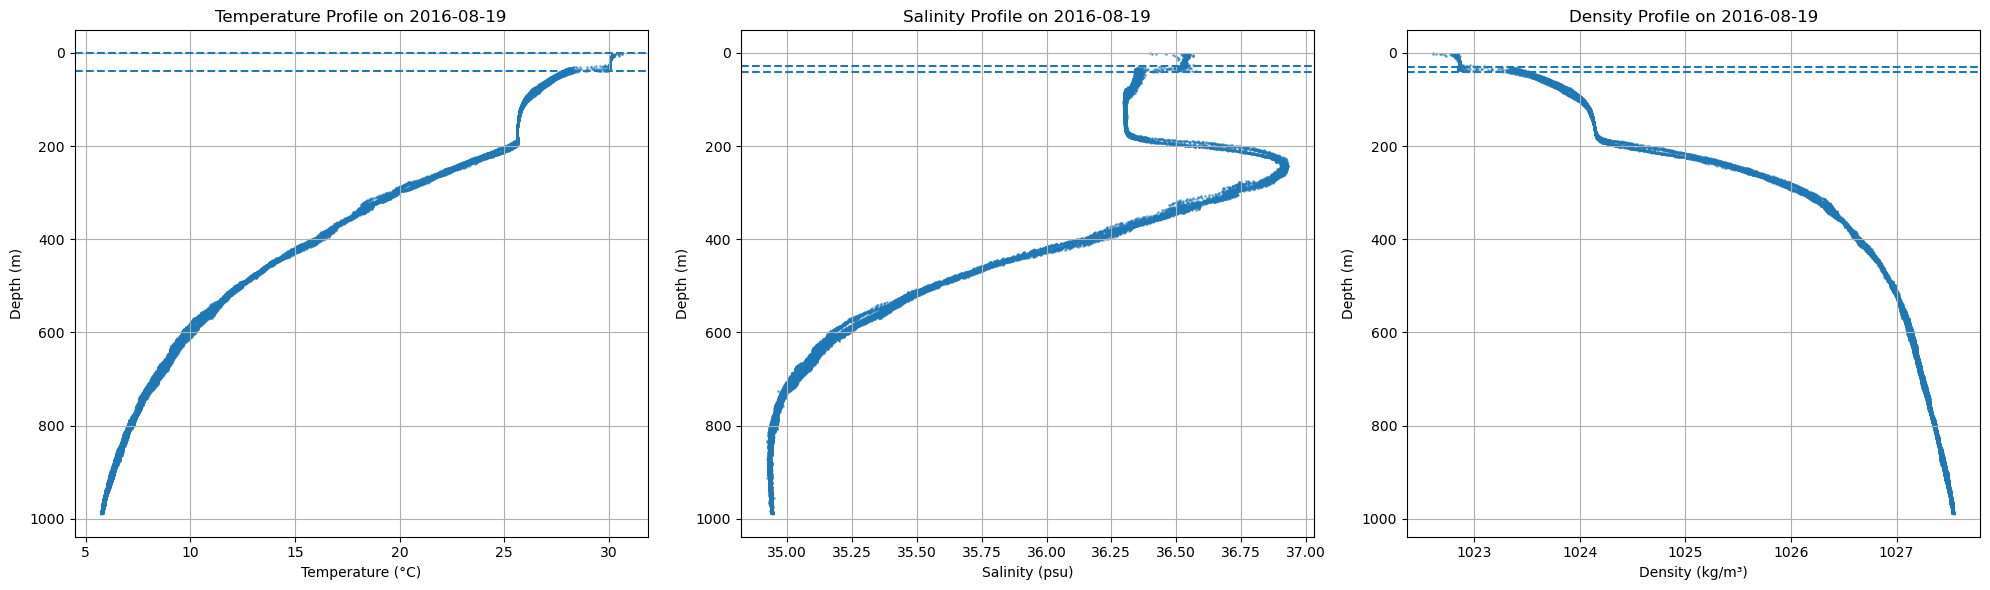

Closest time index: 19
_show_var_names = True


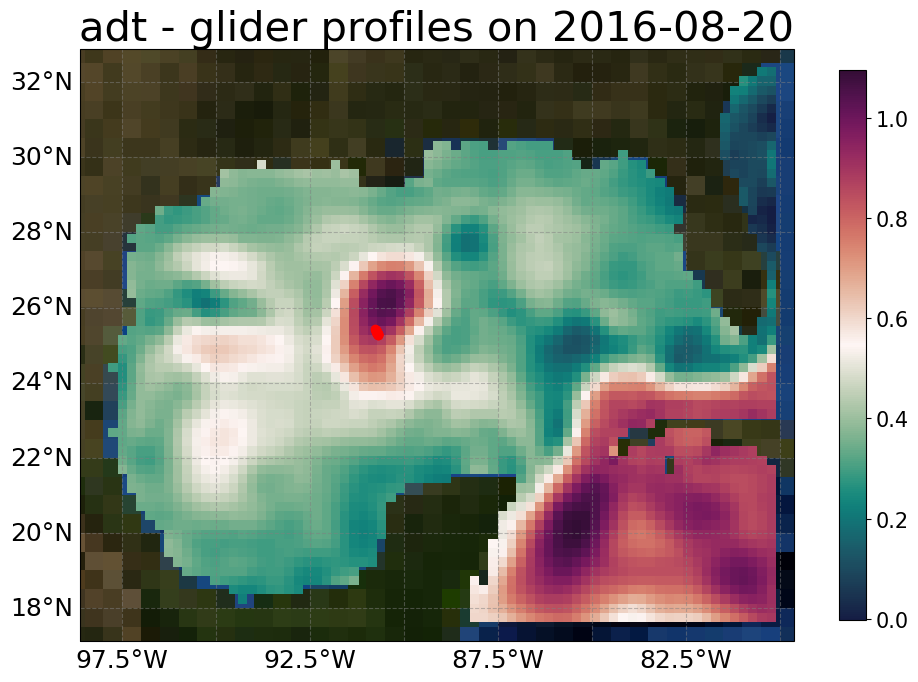

date		lat			lon			AVISO SSH
2016-08-20	25.26823264280229	-90.69114992240948	0.9157660515335846
2016-08-20	25.307674944667795	-90.71097069300795	0.9267805071340389
2016-08-20	25.319353946145416	-90.71434602919224	0.929885920321916
2016-08-20	25.290808543736272	-90.70101574726112	0.922086802471275
2016-08-20	25.301910532812272	-90.70413856891889	0.9250917680999242
2016-08-20	25.273544125437745	-90.69458976285371	0.917308731772986
2016-08-20	25.28495887725534	-90.69584660312606	0.9203745101006475
2016-08-20	25.360747201889833	-90.741347006691	0.9408124545591872
2016-08-20	25.37447041127	-90.74381890971218	0.9442436955763573
2016-08-20	25.343010471931937	-90.7296792150419	0.9362201597318405
2016-08-20	25.354688224747573	-90.73239967180866	0.939205803291592
2016-08-20	25.32695734902336	-90.72130957748963	0.9319888095850779
2016-08-20	25.337226007630484	-90.72339174433691	0.9346515579620625
2016-08-20	25.385473821998804	-90.75008676052454	0.9463754059970141
2016-08-20	25.39914785874609	-90.7

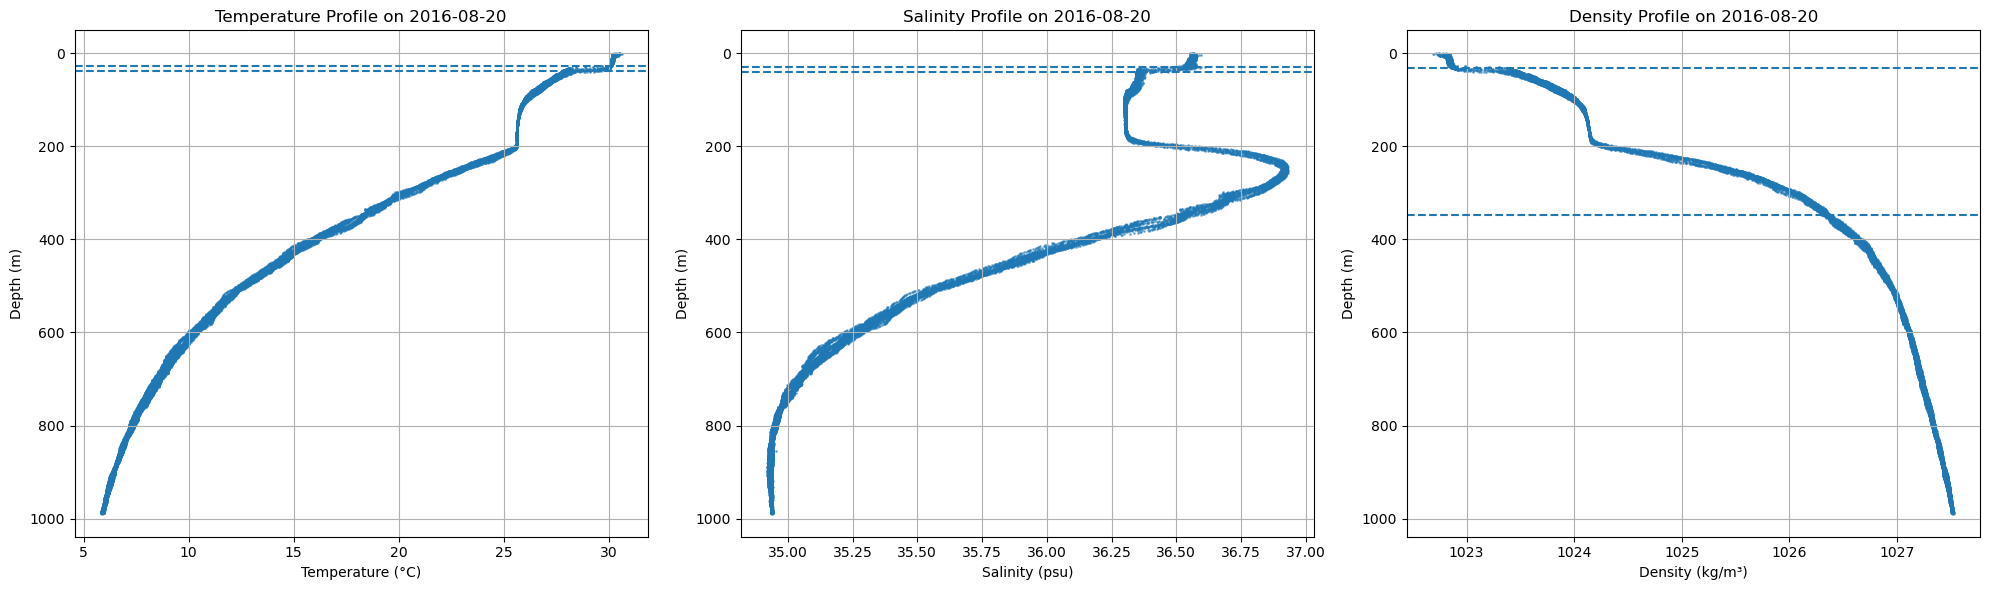

Closest time index: 20
_show_var_names = True


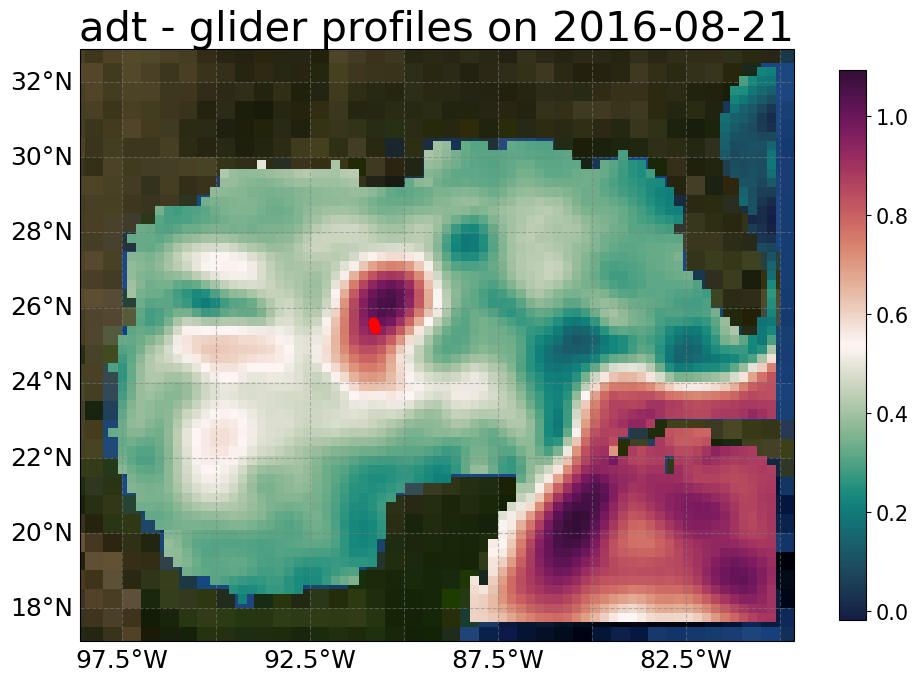

date		lat			lon			AVISO SSH
2016-08-21	25.432623546340484	-90.76361416390449	0.9585385347008658
2016-08-21	25.445394524093047	-90.76513038734014	0.9609167168472899
2016-08-21	25.42300615183336	-90.75983478419425	0.9567375564833525
2016-08-21	25.50240849922063	-90.78690548904251	0.970901906860728
2016-08-21	25.518496124426992	-90.7900735119905	0.9736562570535785
2016-08-21	25.455246243998424	-90.76877390292175	0.9627111285569299
2016-08-21	25.46791585069452	-90.77051020608788	0.965028698053347
2016-08-21	25.476766475789443	-90.77547161022964	0.9665614545631235
2016-08-21	25.491919653754106	-90.77995115219167	0.9692129273093029
2016-08-21	25.591835857690505	-90.81897990920938	0.9847927027396898
2016-08-21	25.610240250522	-90.81995540403756	0.9877808344002653
2016-08-21	25.560013532093173	-90.80893228899434	0.9800289921178217
2016-08-21	25.57662864772497	-90.81179480857834	0.9826857592149456
2016-08-21	25.52946619859963	-90.79969898354959	0.9752104274934257
2016-08-21	25.54577522253754	-9

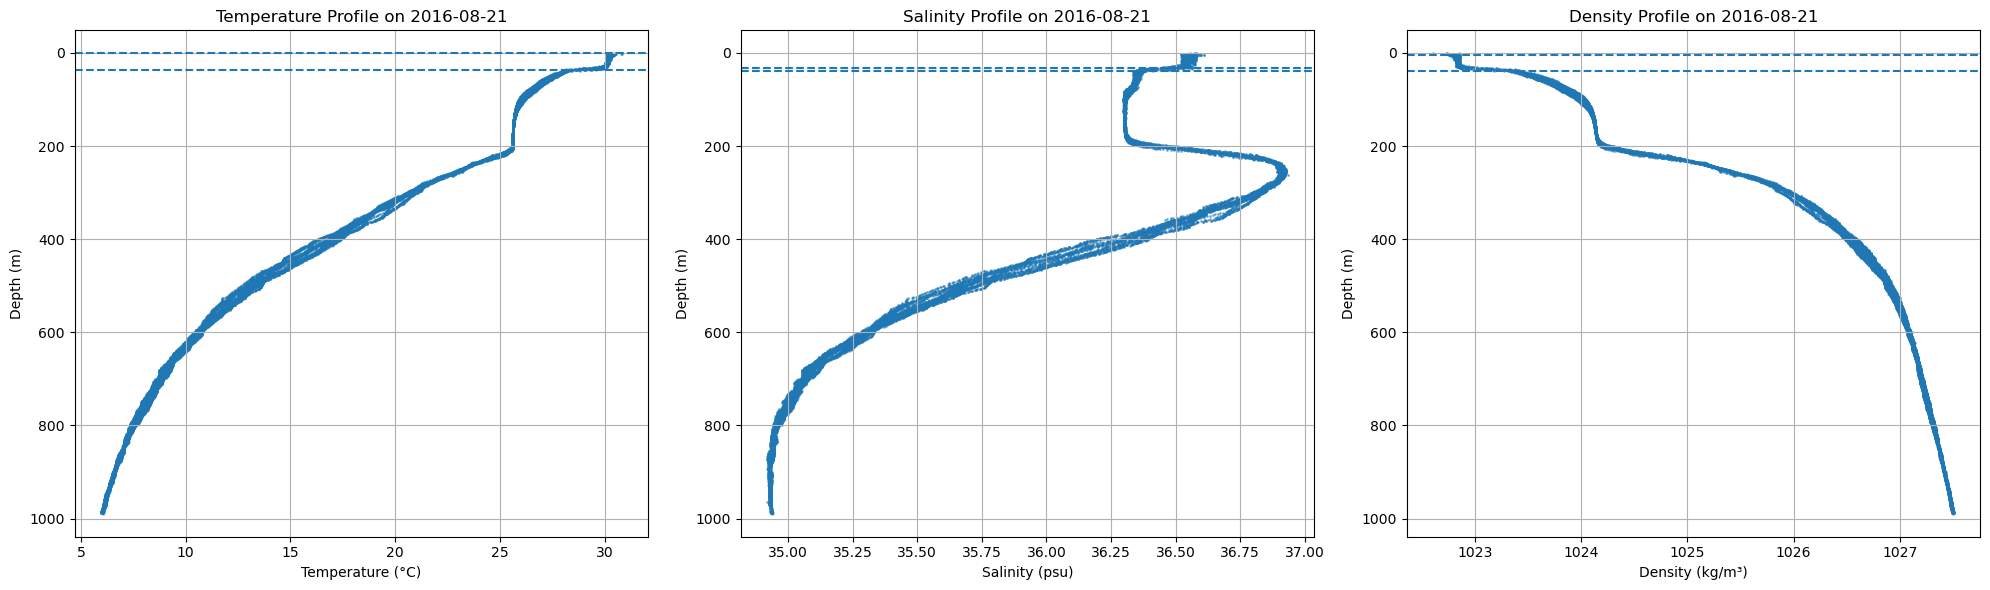

Closest time index: 21
_show_var_names = True


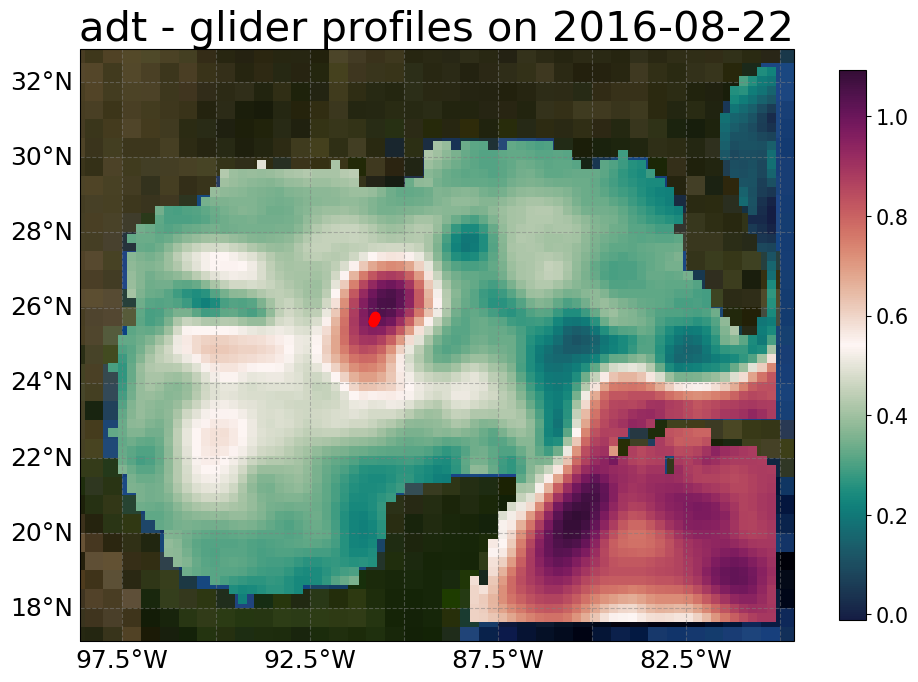

date		lat			lon			AVISO SSH
2016-08-22	25.64747476116058	-90.81444335399233	1.0004920457909867
2016-08-22	25.6585223170529	-90.80671060497528	1.002020179448616
2016-08-22	25.627312755438023	-90.82508142197648	0.9980094119331433
2016-08-22	25.637089771727354	-90.81748076698757	0.9993335486512456
2016-08-22	25.669496010520277	-90.80667916772911	1.00309237175489
2016-08-22	25.680090397520864	-90.80107442531748	1.0045035420520678
2016-08-22	25.718108282551604	-90.78805526427593	1.009287492615346
2016-08-22	25.728147332728646	-90.783799337073	1.0106631747928507
2016-08-22	25.702666873637355	-90.79484945505071	1.0071999230595636
2016-08-22	25.711556717763305	-90.78929841577978	1.0085195824465154
2016-08-22	25.687885671134627	-90.8003679372979	1.0053252243357949
2016-08-22	25.6967882074155	-90.79617559650123	1.0065114899790881
2016-08-22	25.753527409568395	-90.780379230429	1.013602010401066
2016-08-22	25.763900747960697	-90.77716092489852	1.0149826283445813
2016-08-22	25.73557485939633	-90.78

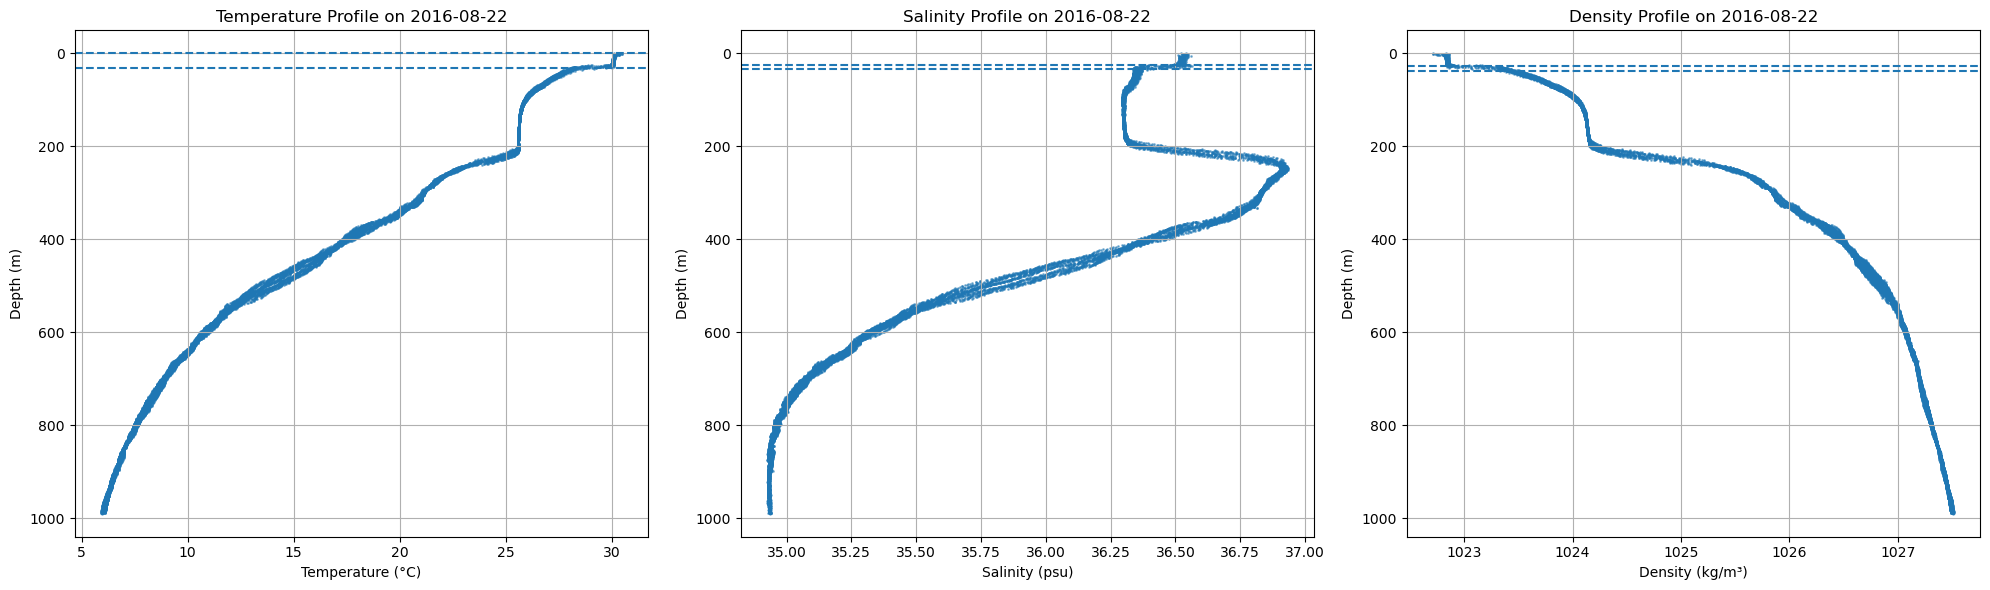

Closest time index: 22
_show_var_names = True


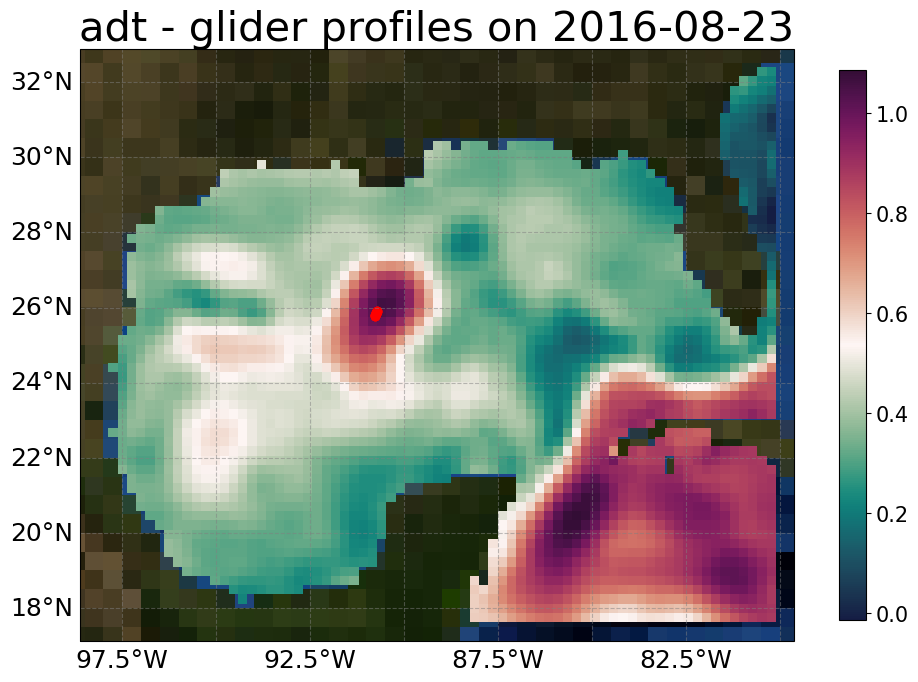

date		lat			lon			AVISO SSH
2016-08-23	25.763900747960697	-90.77716092489852	1.0189249149925876
2016-08-23	25.773144629803507	-90.77872126273937	1.01966655071627
2016-08-23	25.78197079589198	-90.77090035719765	1.021191747027404
2016-08-23	25.832323967882957	-90.75319998682701	1.027861074585188
2016-08-23	25.843372934653004	-90.74717129355531	1.0296157091924059
2016-08-23	25.81327851494814	-90.7613894880662	1.0251359968538811
2016-08-23	25.823014449106132	-90.7558171333012	1.026656662024482
2016-08-23	25.79203136282038	-90.76951034961925	1.0222893146353538
2016-08-23	25.803021043709	-90.76333853417626	1.0239358394260167
2016-08-23	25.89746157498662	-90.72667492895883	1.035728102210403
2016-08-23	25.907777992363478	-90.71896434530277	1.0368835131682892
2016-08-23	25.8761451296302	-90.73491053598055	1.0342952422595795
2016-08-23	25.888087273844576	-90.73016821688752	1.0351063692562297
2016-08-23	25.85357538121461	-90.74406204158463	1.031002524239141
2016-08-23	25.8656818860404	-90.7383250

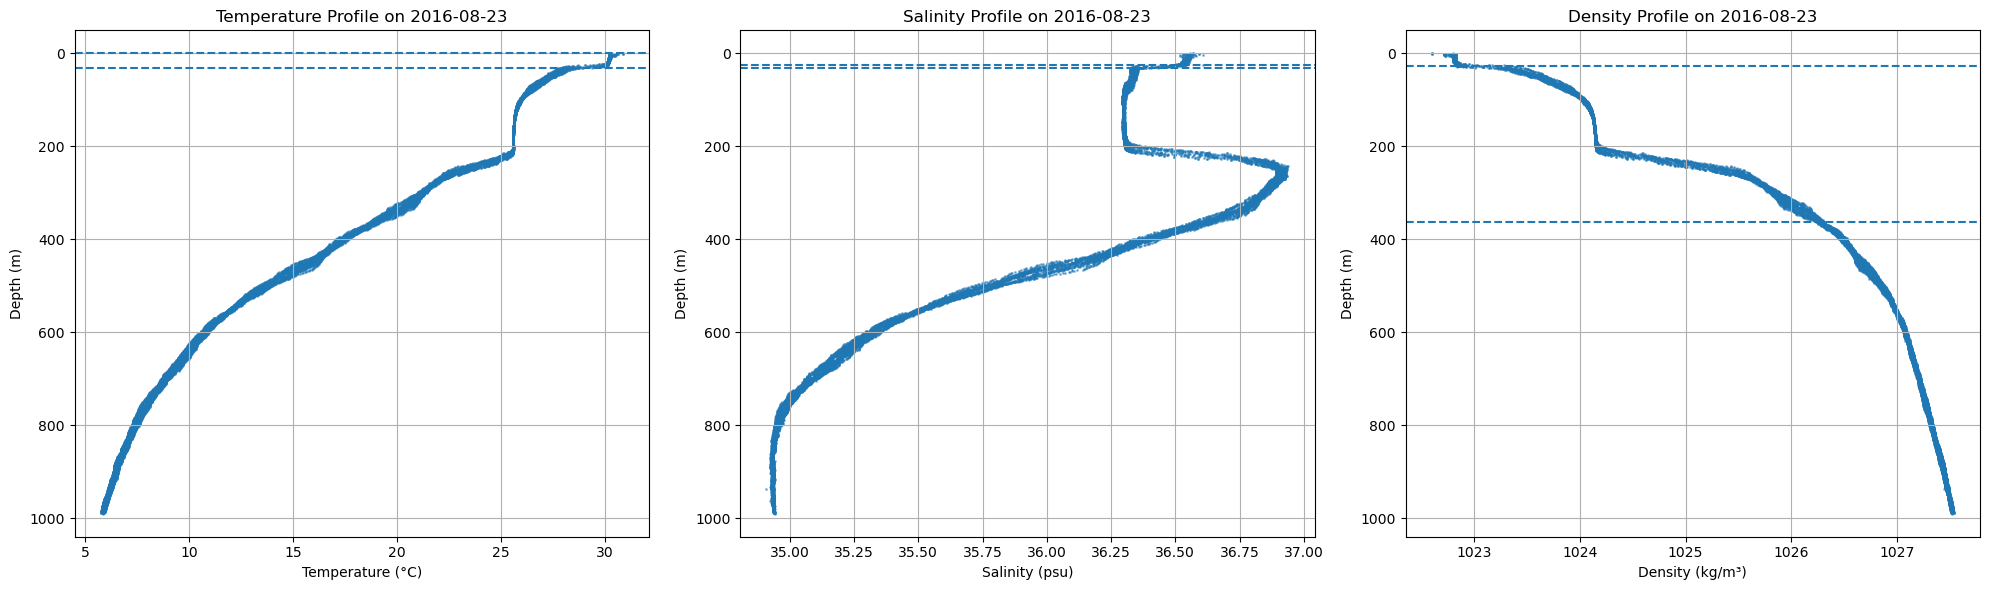

Closest time index: 23
_show_var_names = True


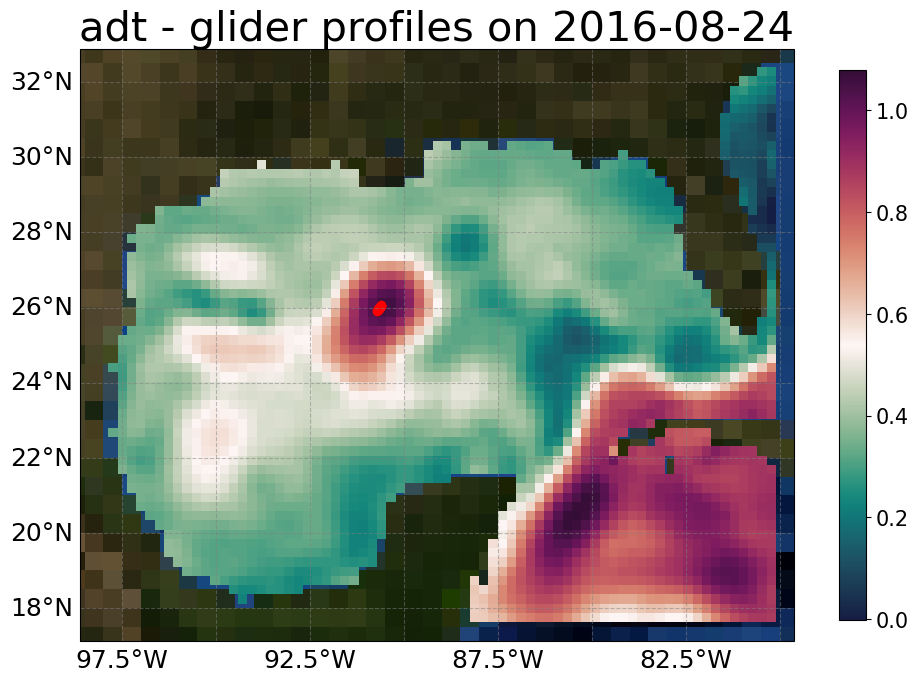

date		lat			lon			AVISO SSH
2016-08-24	25.95702290827234	-90.68304614676548	1.0452015719726724
2016-08-24	25.97049416990598	-90.67452668567726	1.0462656521547906
2016-08-24	25.937344160032563	-90.70364340583629	1.0427801259526743
2016-08-24	25.948959041643427	-90.6913544372022	1.0442114296919984
2016-08-24	25.915348757711715	-90.71542891024092	1.0414388282140188
2016-08-24	25.927099697041832	-90.7062953240214	1.0424638169651532
2016-08-24	26.00318362113641	-90.65303628851366	1.0490740181574643
2016-08-24	26.017151278571827	-90.64217991393481	1.0505379037879676
2016-08-24	25.981925543803694	-90.66978977556442	1.0468959063407295
2016-08-24	25.994162682819173	-90.66003077180746	1.0481520372739623
2016-08-24	26.026522253190837	-90.63368056189613	1.051694481438949
2016-08-24	26.040172329762903	-90.62160755742784	1.052880211243037
2016-08-24	26.049409377755488	-90.61375361721612	1.0528576058664842
2016-08-24	26.064460788366254	-90.60237483935204	1.0529026874597538


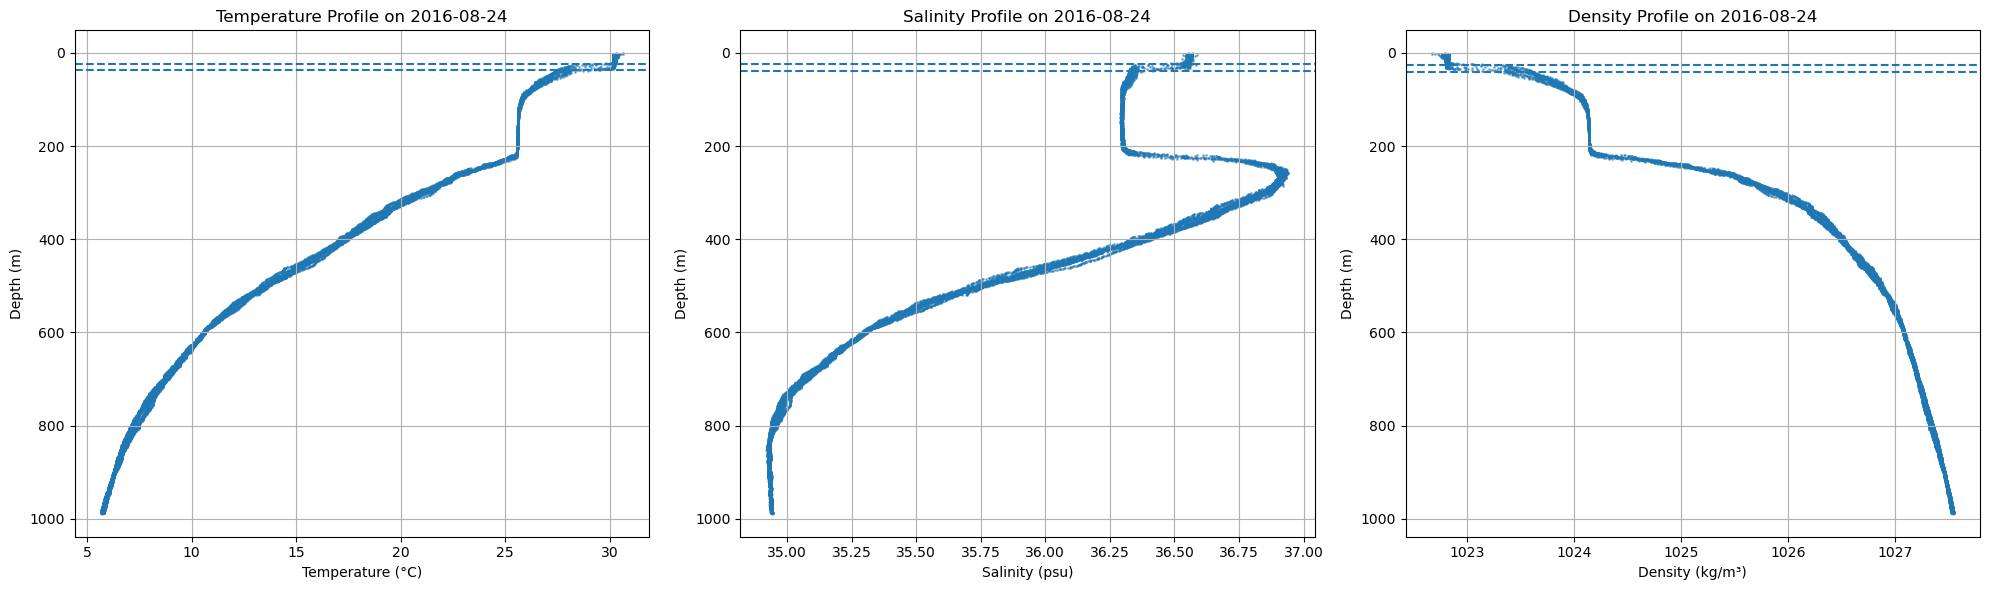

Closest time index: 24
_show_var_names = True


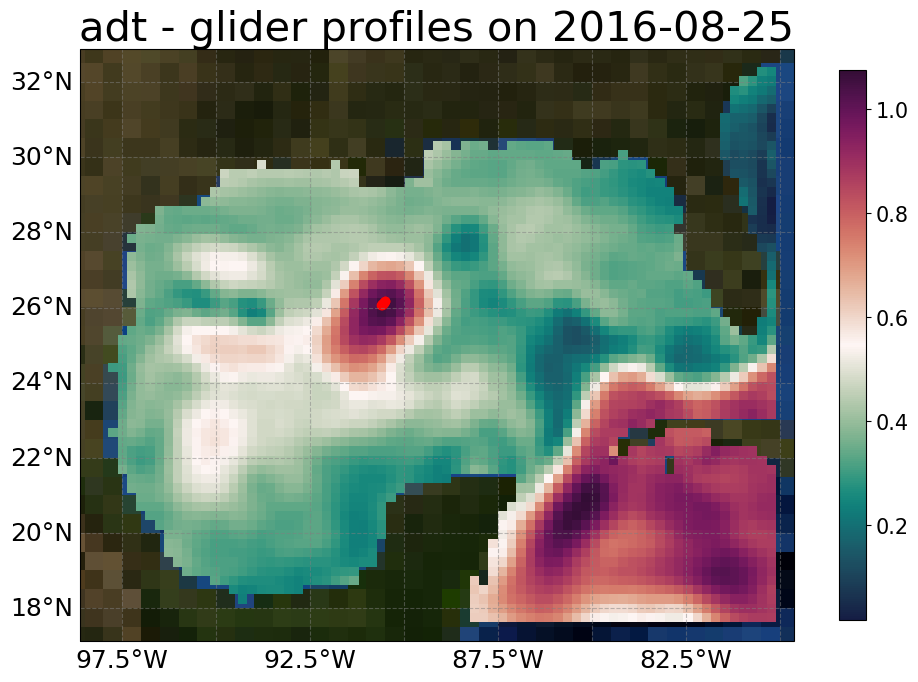

date		lat			lon			AVISO SSH
2016-08-25	26.07206454468106	-90.59459958147228	1.050450152070866
2016-08-25	26.08512734054689	-90.58529092501817	1.0502236508564582
2016-08-25	26.064460788366254	-90.60237483935204	1.05064507974556
2016-08-25	26.090817243409205	-90.57449743187634	1.0500676462915541
2016-08-25	26.106215548701893	-90.56501097795581	1.0499279642113428
2016-08-25	26.162221431673412	-90.51557929341917	1.043977957547887
2016-08-25	26.1757135439759	-90.51952032753877	1.0418863800100036
2016-08-25	26.114956233821136	-90.55350374990766	1.04984131990256
2016-08-25	26.13043115817128	-90.54340735318405	1.0489482001687183
2016-08-25	26.140120228613345	-90.53391664621866	1.0474043850687553
2016-08-25	26.155224072991942	-90.52586263614641	1.045046073581918


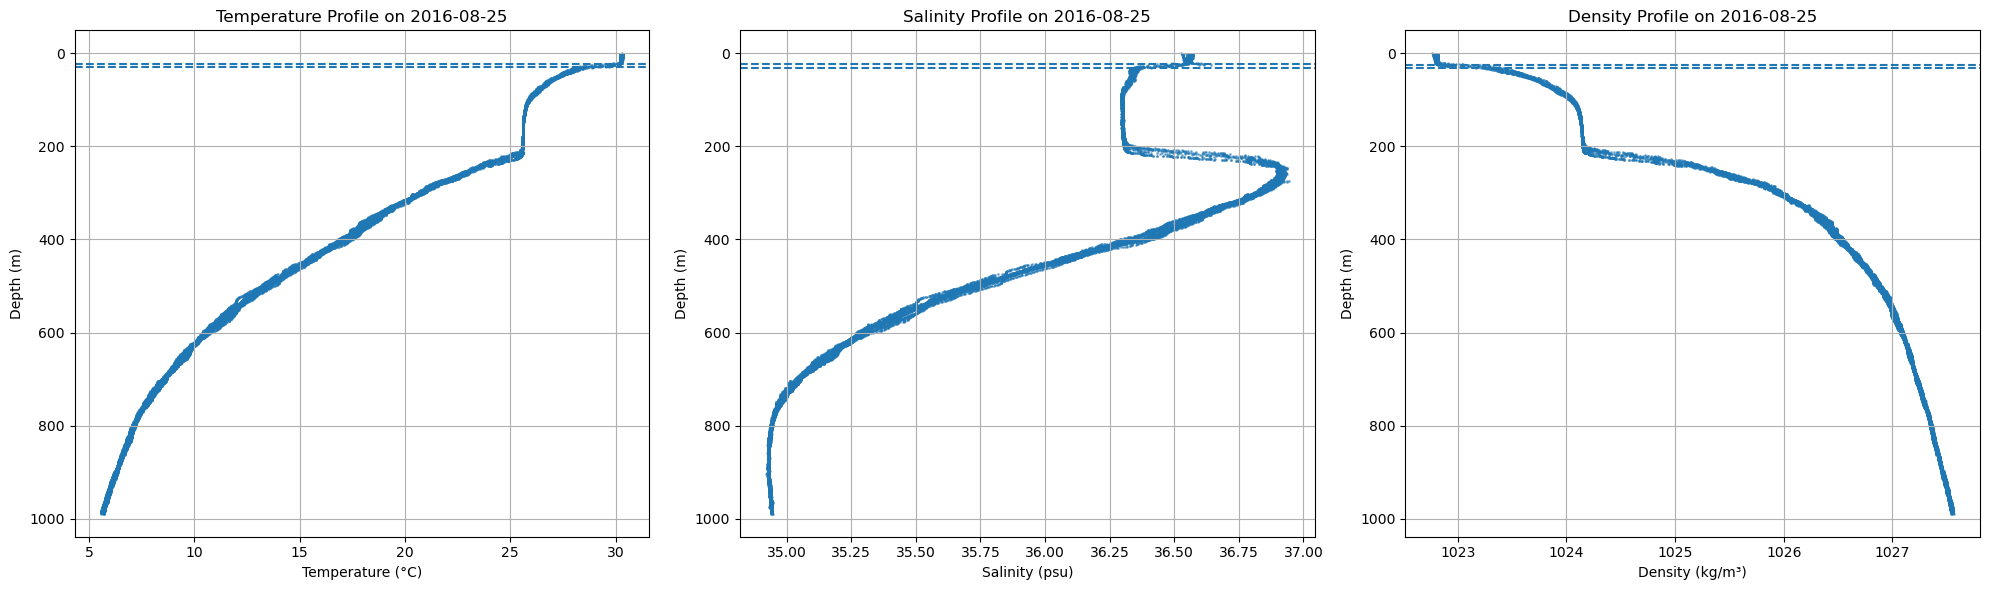

Closest time index: 25
_show_var_names = True


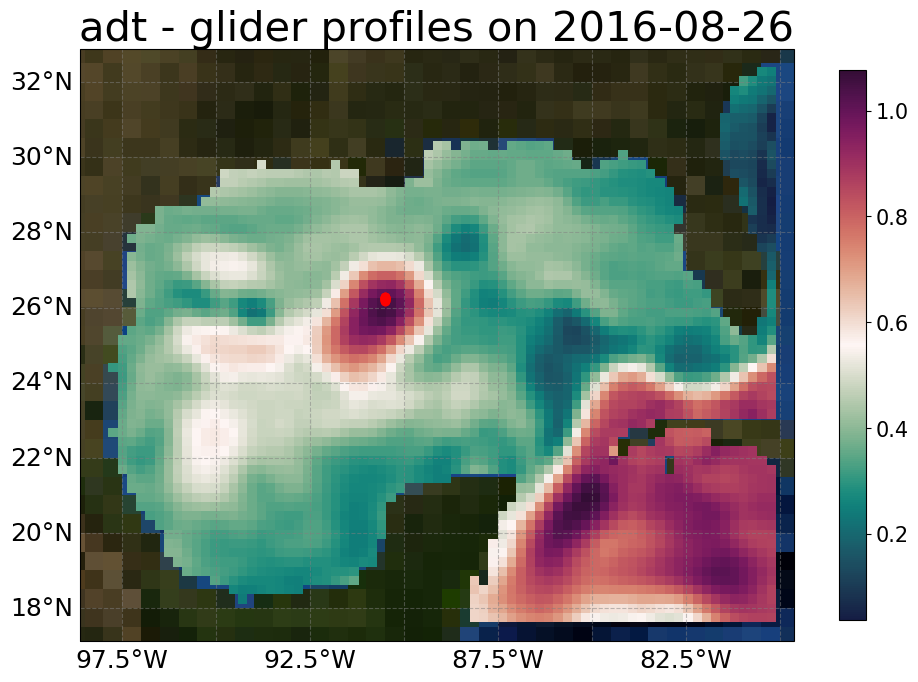

date		lat			lon			AVISO SSH
2016-08-26	26.1757135439759	-90.51952032753877	1.0341121529252384
2016-08-26	26.204320418493776	-90.5112079336633	1.0289292475822391
2016-08-26	26.217295265051945	-90.51129143444231	1.0265997564629998
2016-08-26	26.18419464903933	-90.51629426361175	1.0325668844570872
2016-08-26	26.19810863314473	-90.51779180843323	1.0300663761349764
2016-08-26	26.225920246331654	-90.50526485224228	1.025048280247686
2016-08-26	26.236150725911724	-90.50627317343046	1.0232170605496675
2016-08-26	26.26887373758427	-90.49866448926268	1.017388177338951
2016-08-26	26.277238866259484	-90.50126304367218	1.0158845372148906
2016-08-26	26.255675913912228	-90.49959397787133	1.0197384649878927
2016-08-26	26.263818106106317	-90.50290026107072	1.0182749455542939
2016-08-26	26.24127715827434	-90.50074452043461	1.0223053309427814
2016-08-26	26.250353677840586	-90.50276595714844	1.0206812717853488
2016-08-26	26.282931452603737	-90.49560832255419	1.0148986217405132


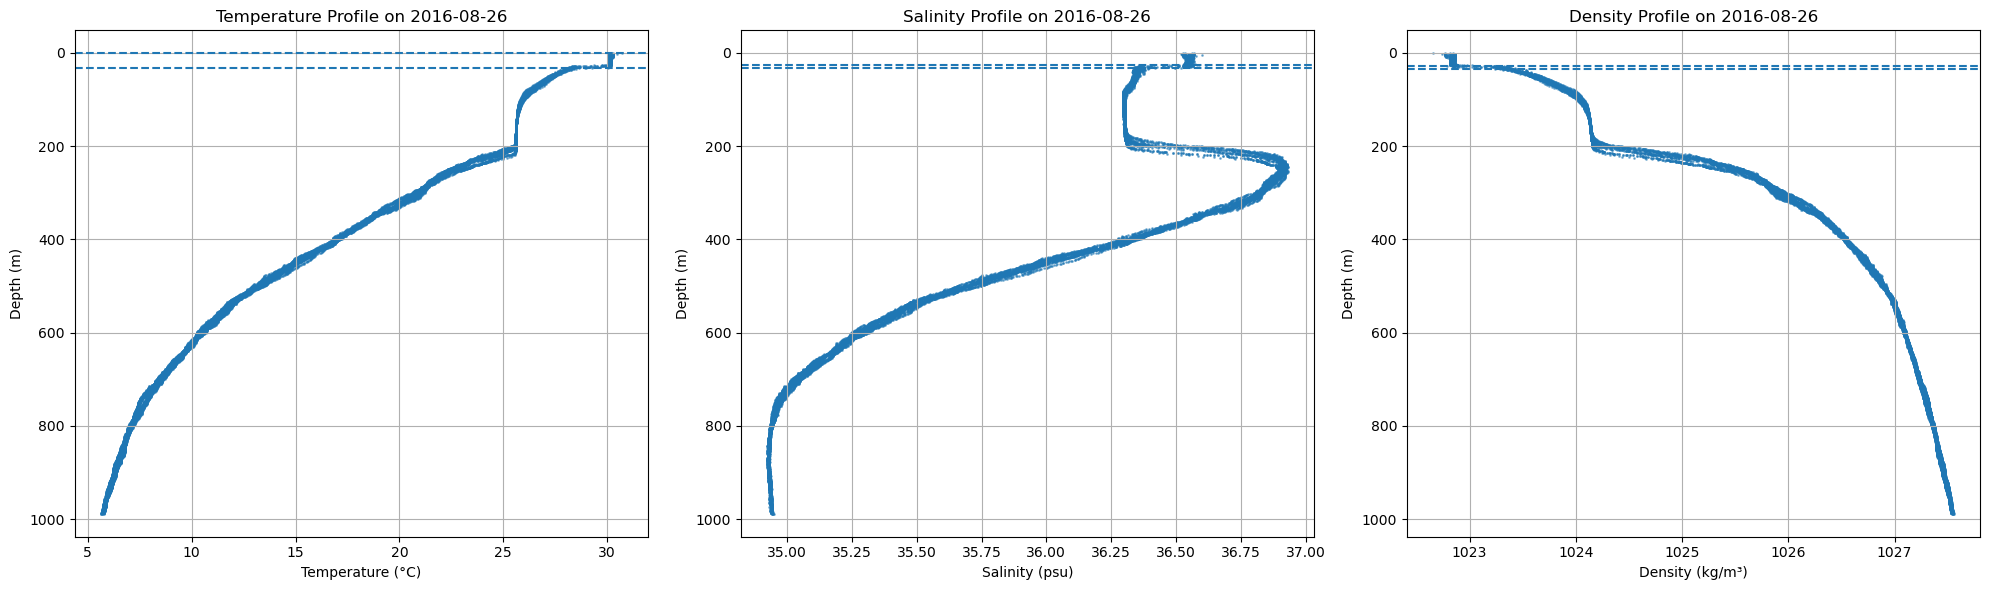

Closest time index: 26
_show_var_names = True


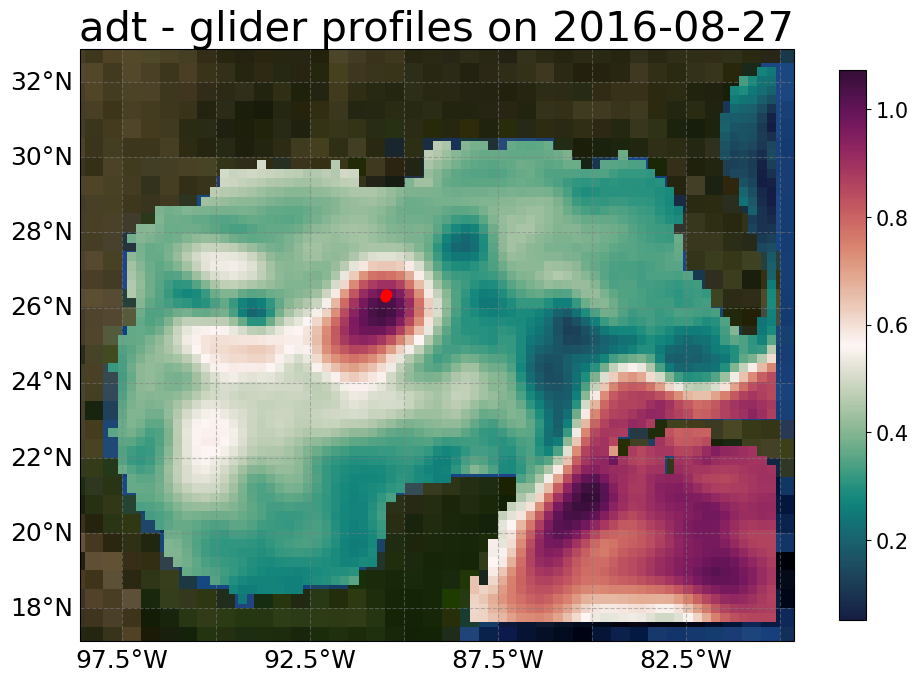

date		lat			lon			AVISO SSH
2016-08-27	26.282931452603737	-90.49560832255419	1.0036197911059213
2016-08-27	26.29097646083801	-90.49907074479852	1.0019444042357406
2016-08-27	26.29580580040792	-90.49498057680935	1.0009435443200105
2016-08-27	26.304906364331867	-90.49591747971195	0.9990501337655978
2016-08-27	26.31166324558932	-90.49127158653985	0.9976545861957702
2016-08-27	26.32103014192825	-90.49207080738125	0.9957073963124746
2016-08-27	26.32690608662755	-90.48700709124891	0.994502117715388
2016-08-27	26.3348562292937	-90.48788757082056	0.9928502663487568
2016-08-27	26.339937076739886	-90.48200498043457	0.9918186989615669
2016-08-27	26.346438934895183	-90.48414642394711	0.9904632808020302
2016-08-27	26.350264249943628	-90.476788106373	0.9897034267149154
2016-08-27	26.3562265164235	-90.47698978097287	0.9884697449199247
2016-08-27	26.368273022370932	-90.46486433125008	0.9860466220869533
2016-08-27	26.370239796343952	-90.46834134976957	0.9856216225213232
2016-08-27	26.361697712292248	-9

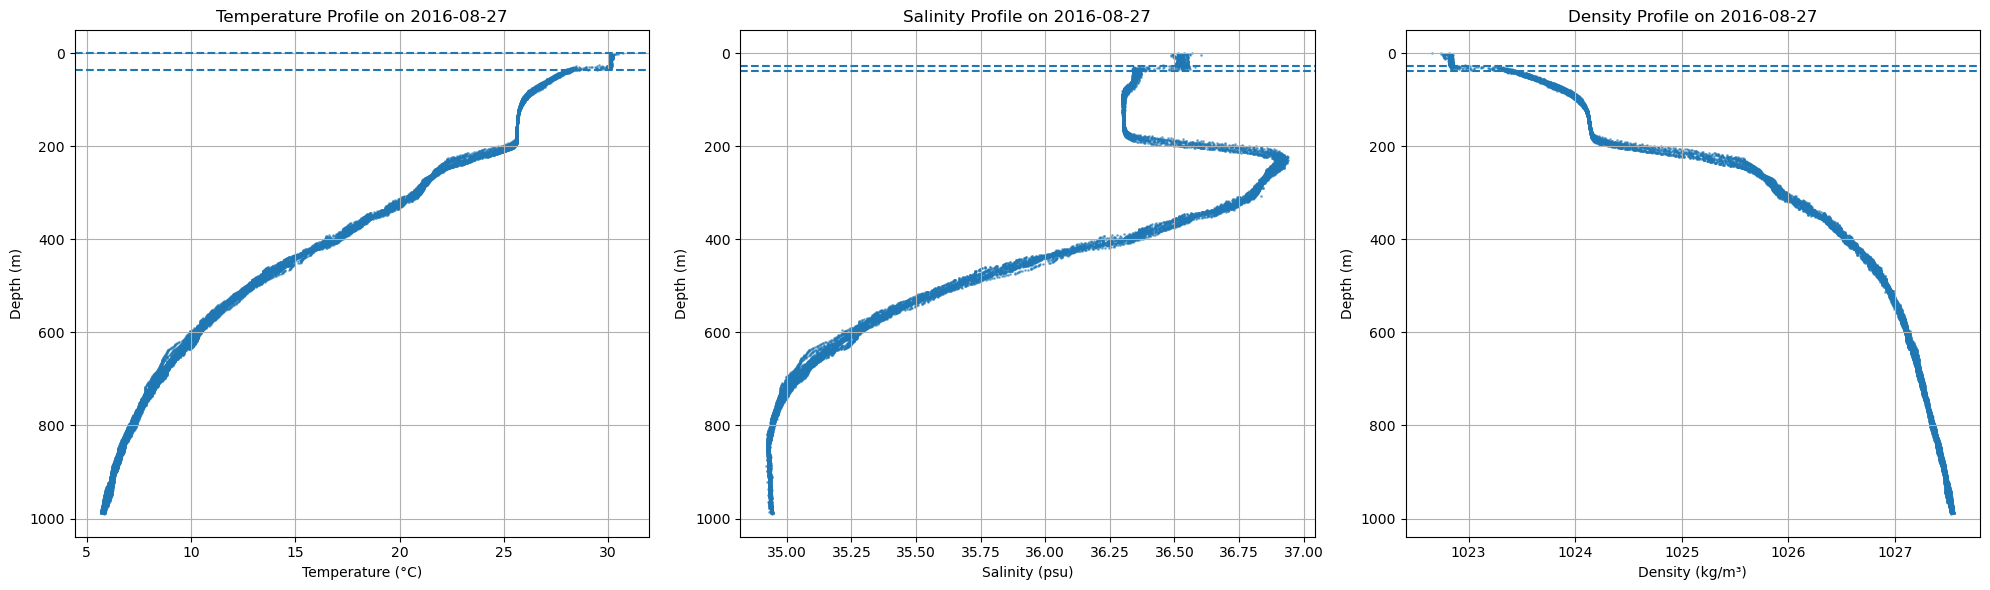

Closest time index: 27
_show_var_names = True


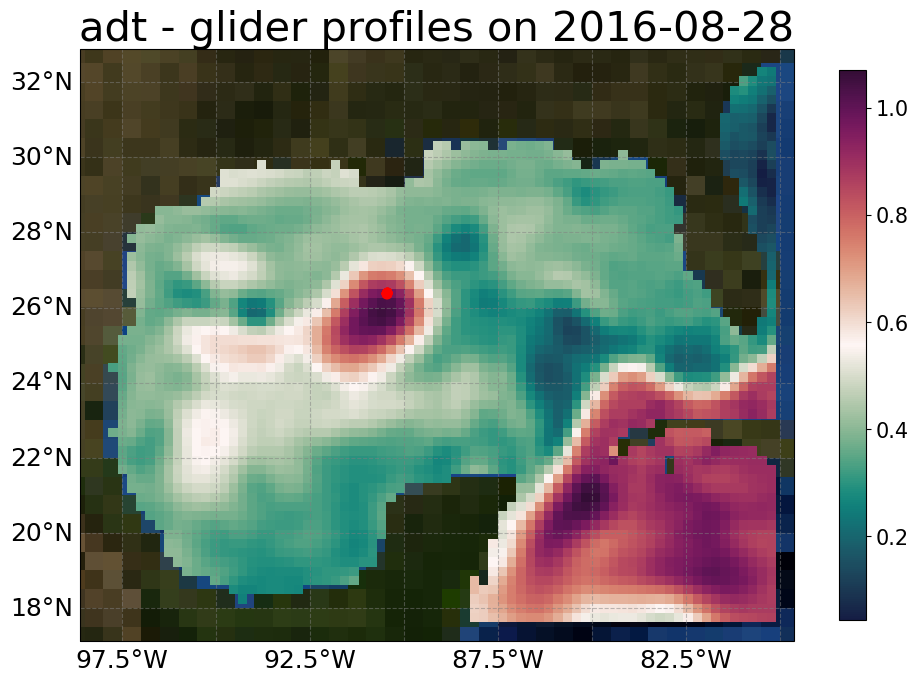

date		lat			lon			AVISO SSH
2016-08-28	26.37287649472282	-90.46352756112013	0.967203781505829
2016-08-28	26.375466181366313	-90.46757396412919	0.9665541154733179
2016-08-28	26.370239796343952	-90.46834134976957	0.9678965039003714
2016-08-28	26.38474047295693	-90.4648263534329	0.9631112055628741
2016-08-28	26.388847796108735	-90.46711983160756	0.9616228854800863
2016-08-28	26.38050537432703	-90.4674027375999	0.9646971905313723
2016-08-28	26.382768657002018	-90.47004200305294	0.963891194932635
2016-08-28	26.375404611937167	-90.46425348247118	0.9665435214859024
2016-08-28	26.379062643710718	-90.4687482370742	0.9652420229228816
2016-08-28	26.397121802964	-90.46231906087294	0.9585242367566016
2016-08-28	26.402348343672404	-90.46464673496634	0.9566248737957549
2016-08-28	26.392685981947974	-90.46414054468802	0.9601778041457041
2016-08-28	26.396560221684357	-90.46618470289974	0.9587732285986201
2016-08-28	26.406033620959803	-90.45978187490105	0.9552127650364731
2016-08-28	26.4104579564046	-90

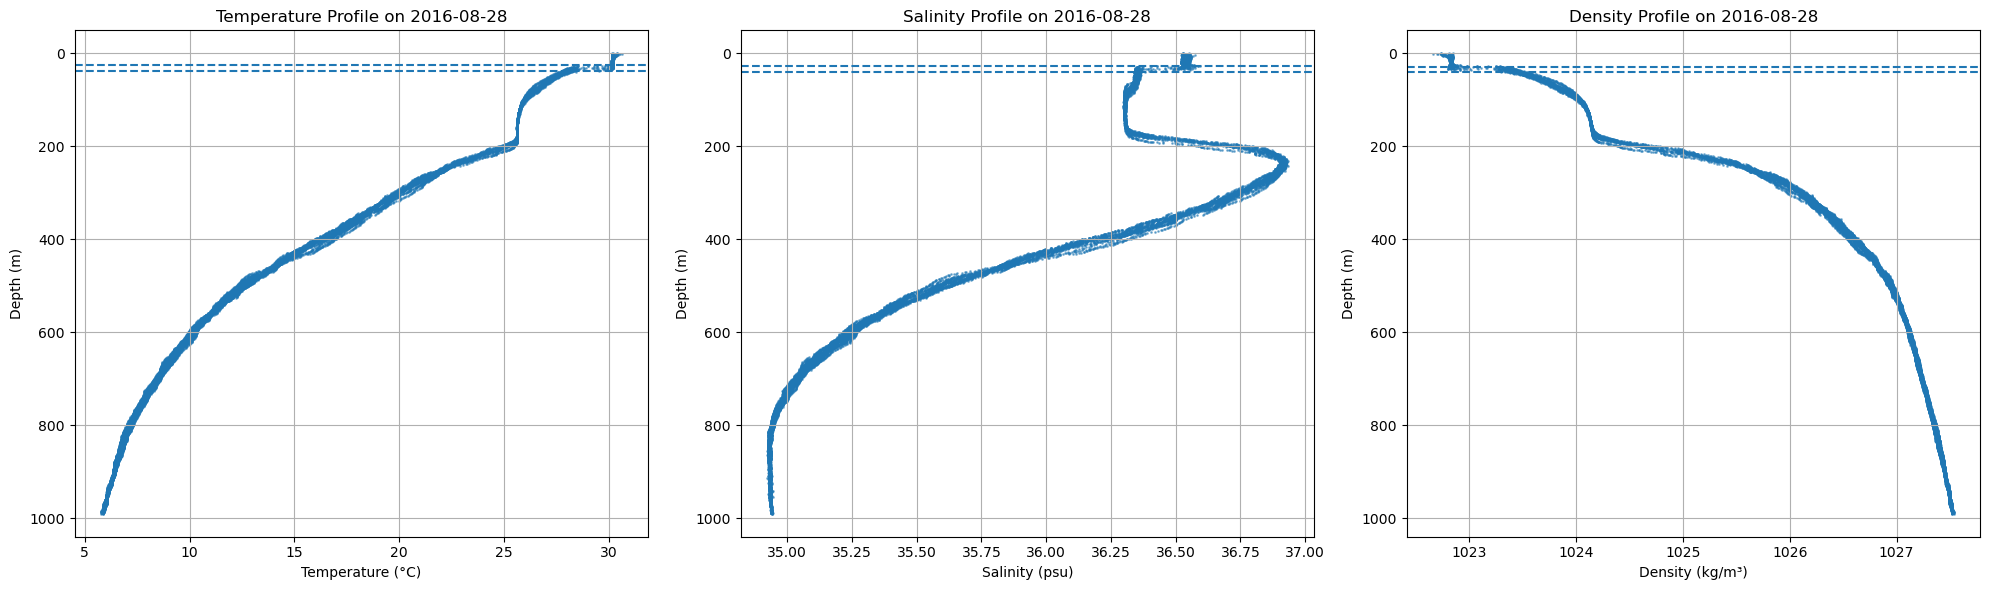

Closest time index: 28
_show_var_names = True


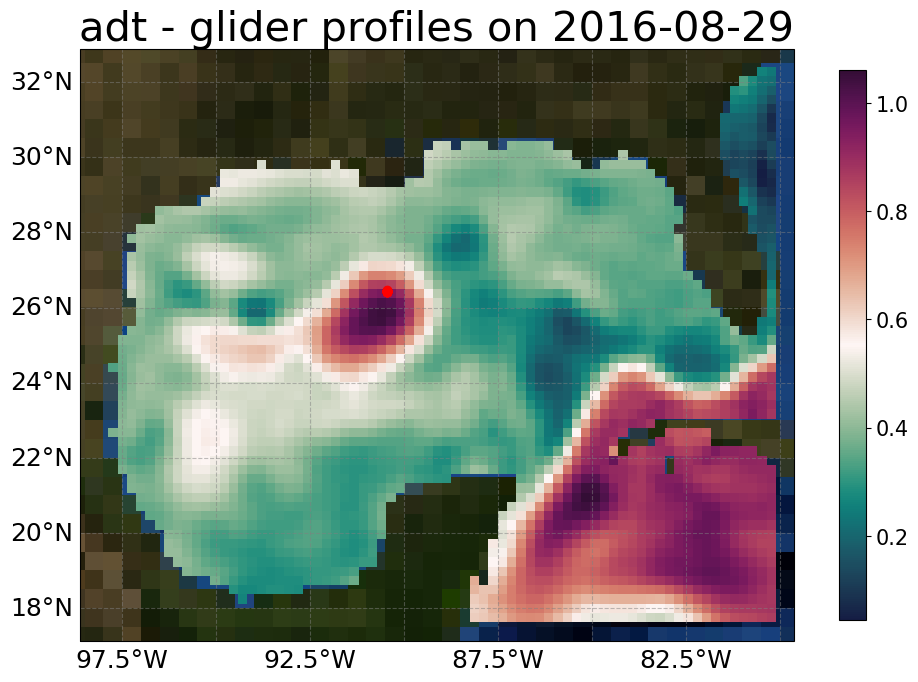

date		lat			lon			AVISO SSH
2016-08-29	26.41668227293941	-90.45771096433977	0.9300782001901031
2016-08-29	26.418523775922548	-90.45195542279198	0.9291557250550697
2016-08-29	26.42111980035604	-90.45621850951973	0.9282775020868768
2016-08-29	26.423371992222418	-90.451579675959	0.9272304179268923
2016-08-29	26.42691577026321	-90.45531497903154	0.9259609099373955
2016-08-29	26.43249236657987	-90.45090781060223	0.9236094743669334
2016-08-29	26.436251455919436	-90.4548236715522	0.9222622739275023
2016-08-29	26.439281466434515	-90.45357886945173	0.9210240564515586
2016-08-29	26.44328062693175	-90.4562267252927	0.9195390886595711
2016-08-29	26.42757180186047	-90.45347268473338	0.9256388267741917
2016-08-29	26.430390955660474	-90.45649176472611	0.9246310214414302
2016-08-29	26.45091920016211	-90.45150036325924	0.9163610318208562
2016-08-29	26.452980110906992	-90.45459706327244	0.9156569680972262
2016-08-29	26.445078989863894	-90.45151596260816	0.9186653901011428
2016-08-29	26.448458288101875	-

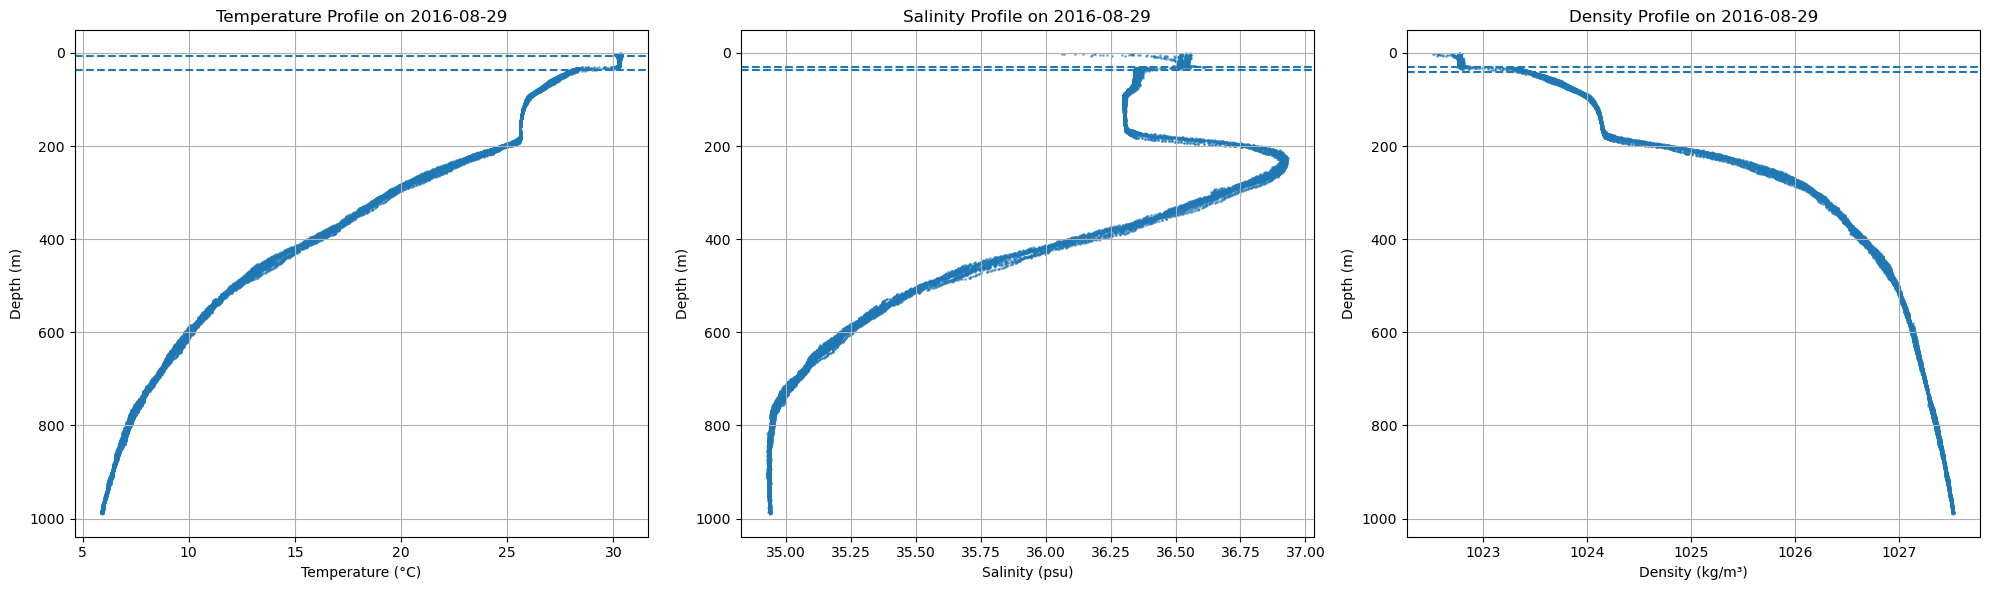

Closest time index: 29
_show_var_names = True


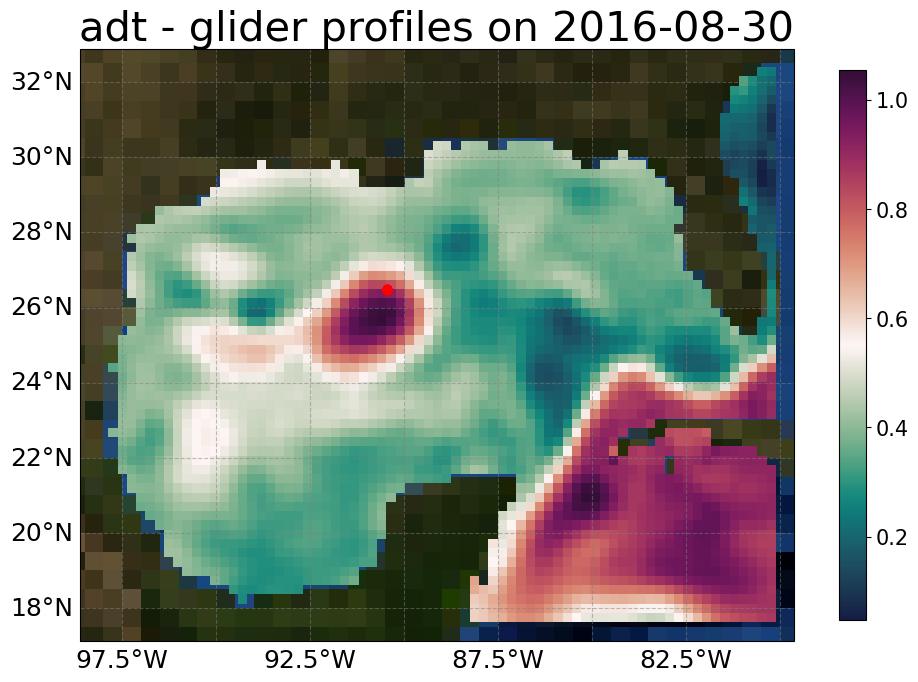

date		lat			lon			AVISO SSH
2016-08-30	26.45650781164109	-90.45427760306731	0.8916150948387414
2016-08-30	26.457622713238518	-90.45115955118574	0.8909648816971119
2016-08-30	26.459390148814084	-90.45607534948311	0.8904896491742107
2016-08-30	26.459802170903384	-90.45122322324413	0.8900397532327015
2016-08-30	26.46146730365216	-90.45667627176971	0.8896399711785574
2016-08-30	26.465377468091827	-90.4530240263377	0.8877672086809776
2016-08-30	26.469295296102185	-90.45626151955985	0.886285846436076
2016-08-30	26.479715345473252	-90.4517173486066	0.8815835599528654
2016-08-30	26.484191456778877	-90.45594869751062	0.8799293076951316
2016-08-30	26.471975860061235	-90.45057956451915	0.8848148425234642
2016-08-30	26.476124450948234	-90.45506224462541	0.8833098518101027
2016-08-30	26.486570222226323	-90.45045792649607	0.8785873485061204
2016-08-30	26.490731243249023	-90.45449019135677	0.8770581856971629
2016-08-30	26.501482736125528	-90.4477765524047	0.8720651029195456
2016-08-30	26.505338745541

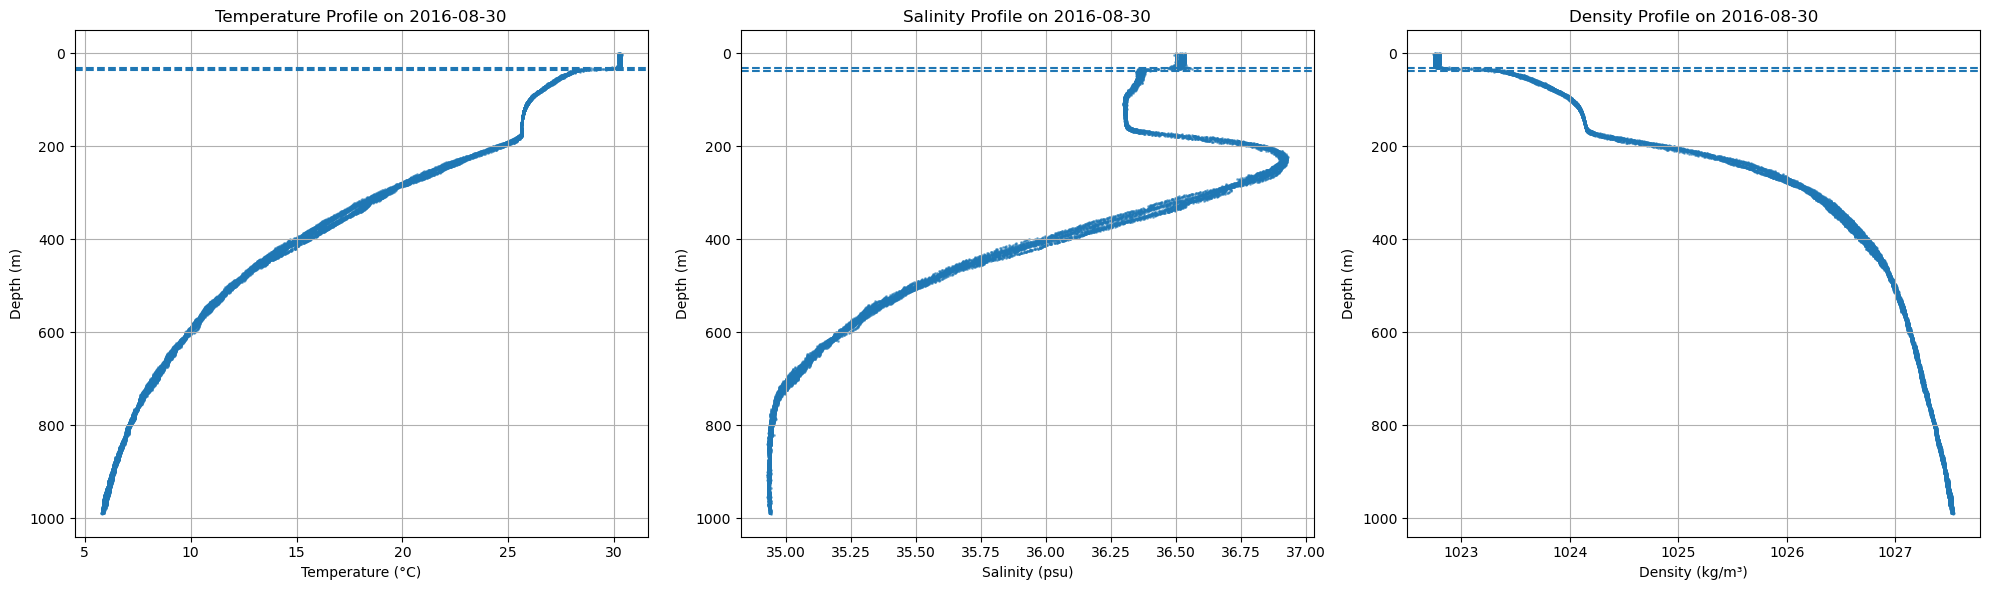

Closest time index: 30
_show_var_names = True


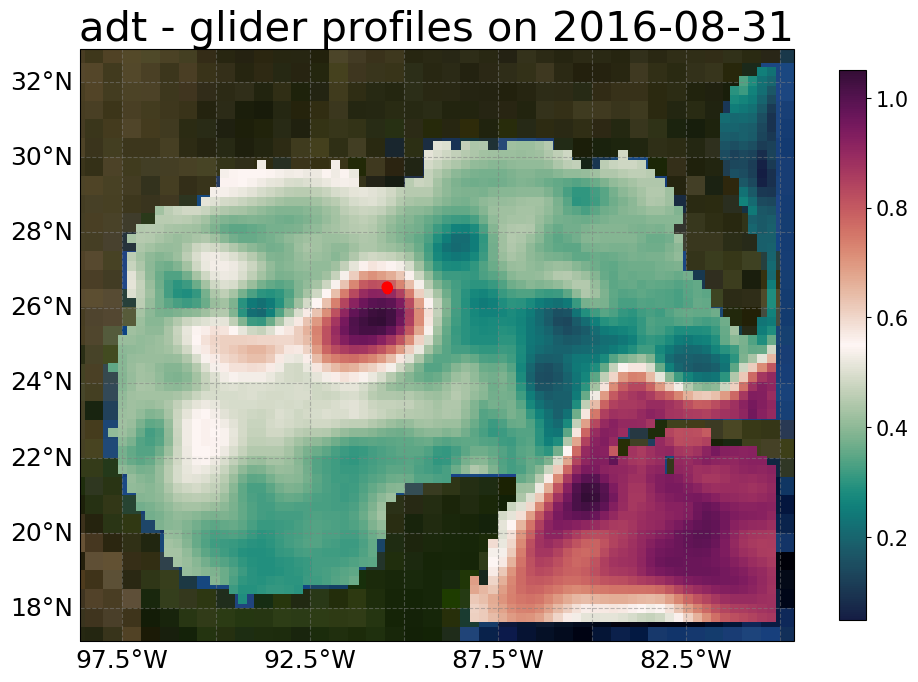

date		lat			lon			AVISO SSH
2016-08-31	26.505338745541305	-90.45207486074779	0.8452685304649734
2016-08-31	26.508586419445944	-90.44953387289434	0.8436540538886035
2016-08-31	26.51326351484237	-90.45424028060393	0.8419981444689456
2016-08-31	26.530627002333127	-90.45652000133333	0.8346423629708781
2016-08-31	26.5343268818424	-90.46116708252138	0.8334191379959616
2016-08-31	26.51625193057203	-90.45115249983033	0.8404509460156555
2016-08-31	26.520103709055906	-90.45624930948195	0.8391894625406058
2016-08-31	26.524389986227504	-90.45481465630255	0.8372114531203447
2016-08-31	26.52736944903229	-90.46018784139176	0.8363566148818049
2016-08-31	26.539562131261384	-90.45704711809634	0.8308066281122337
2016-08-31	26.54265336412383	-90.46429903305834	0.8300687128638593
2016-08-31	26.561705374574657	-90.46339212152138	0.8217343102003276
2016-08-31	26.567884289852948	-90.46798313892235	0.8194499172548088
2016-08-31	26.546997325890832	-90.46203738704358	0.8279966614662511
2016-08-31	26.554206513950

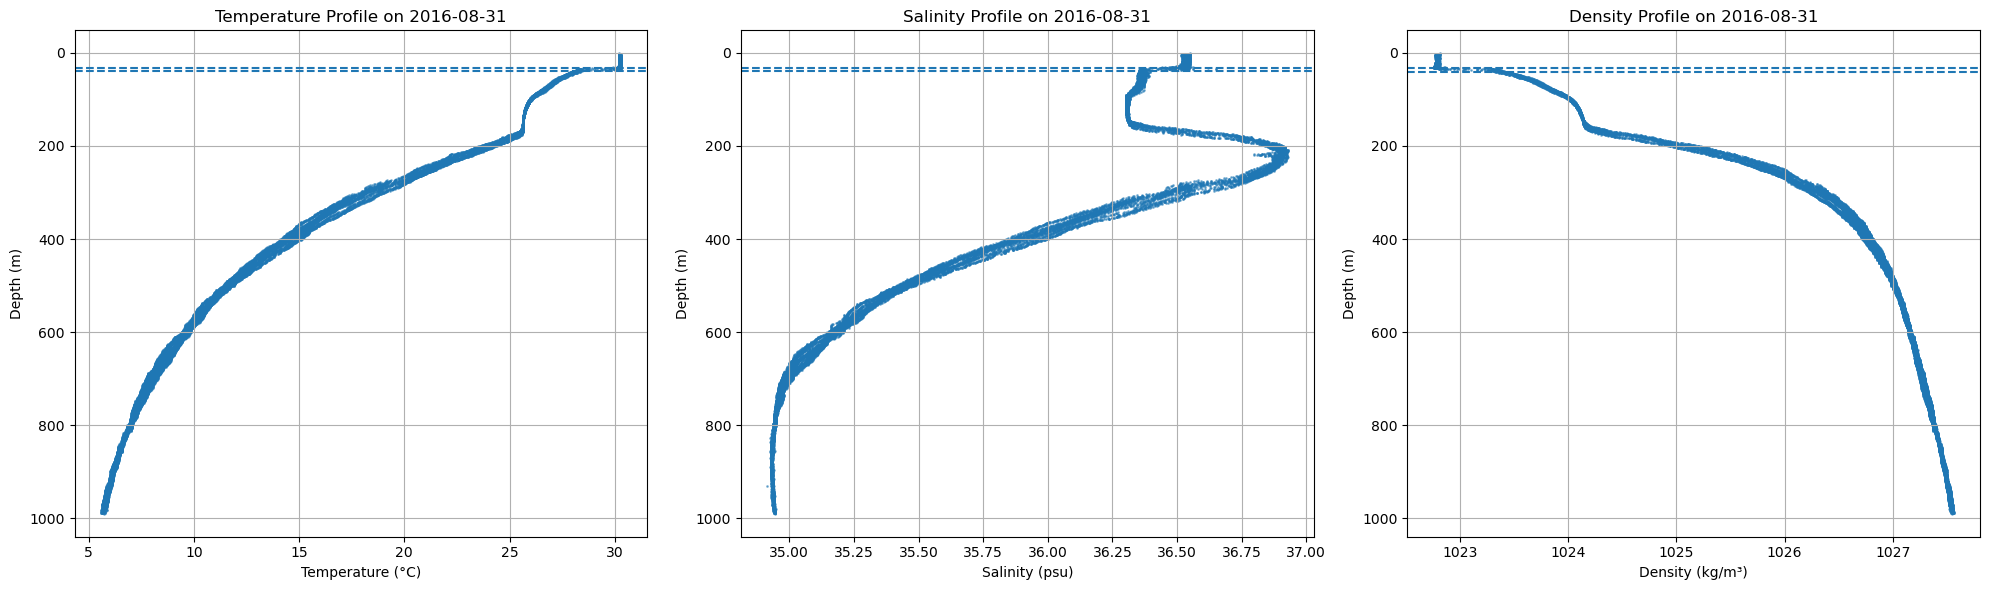

Closest time index: 0
_show_var_names = True


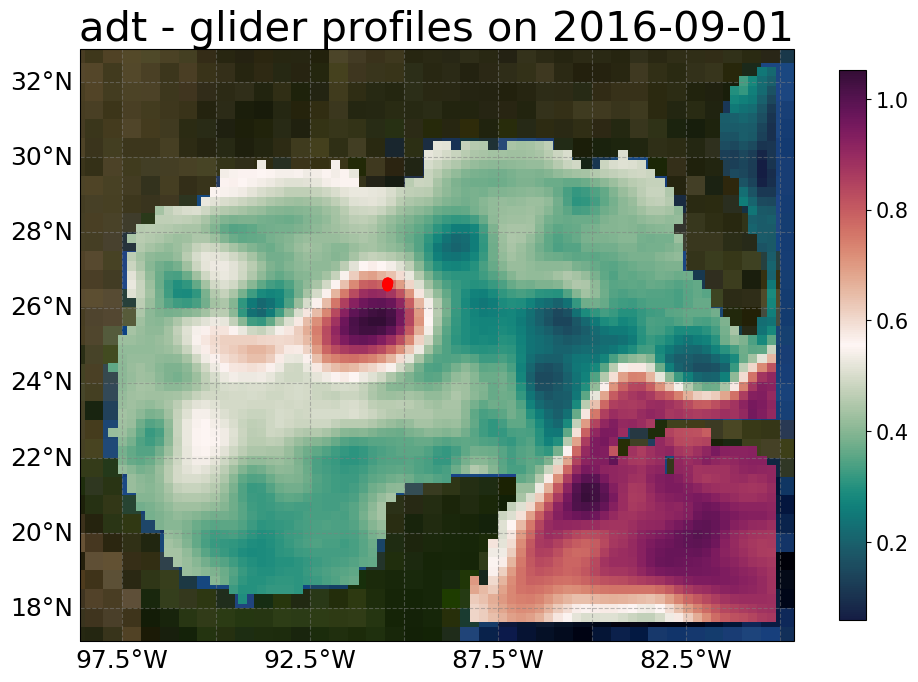

date		lat			lon			AVISO SSH
2016-09-01	26.6013292354286	-90.45679467522805	0.7757420183683967
2016-09-01	26.60797706319732	-90.46042746177172	0.7730908906828122
2016-09-01	26.588060216241402	-90.46048980047217	0.7823103705631131
2016-09-01	26.59562200896599	-90.46409745428701	0.7792310563642137
2016-09-01	26.614929661406492	-90.45342904996537	0.7690468306736334
2016-09-01	26.623025078433287	-90.45712351784981	0.7657362646193902
2016-09-01	26.57344580677258	-90.46267525324595	0.7893173051604324
2016-09-01	26.58072894543378	-90.4664408534782	0.7863801758565919
2016-09-01	26.645754746546974	-90.44784177728235	0.7538499973832062
2016-09-01	26.65275898199666	-90.45077258290713	0.750867945283665
2016-09-01	26.631282033859804	-90.45240275537817	0.7612708233663709
2016-09-01	26.63880352476126	-90.45393436688354	0.7578770566684296
2016-09-01	26.660506456052588	-90.44378236439712	0.7463628720307895
2016-09-01	26.668256353118977	-90.44627898787579	0.7429748435229001
2016-09-01	26.674790431841366	

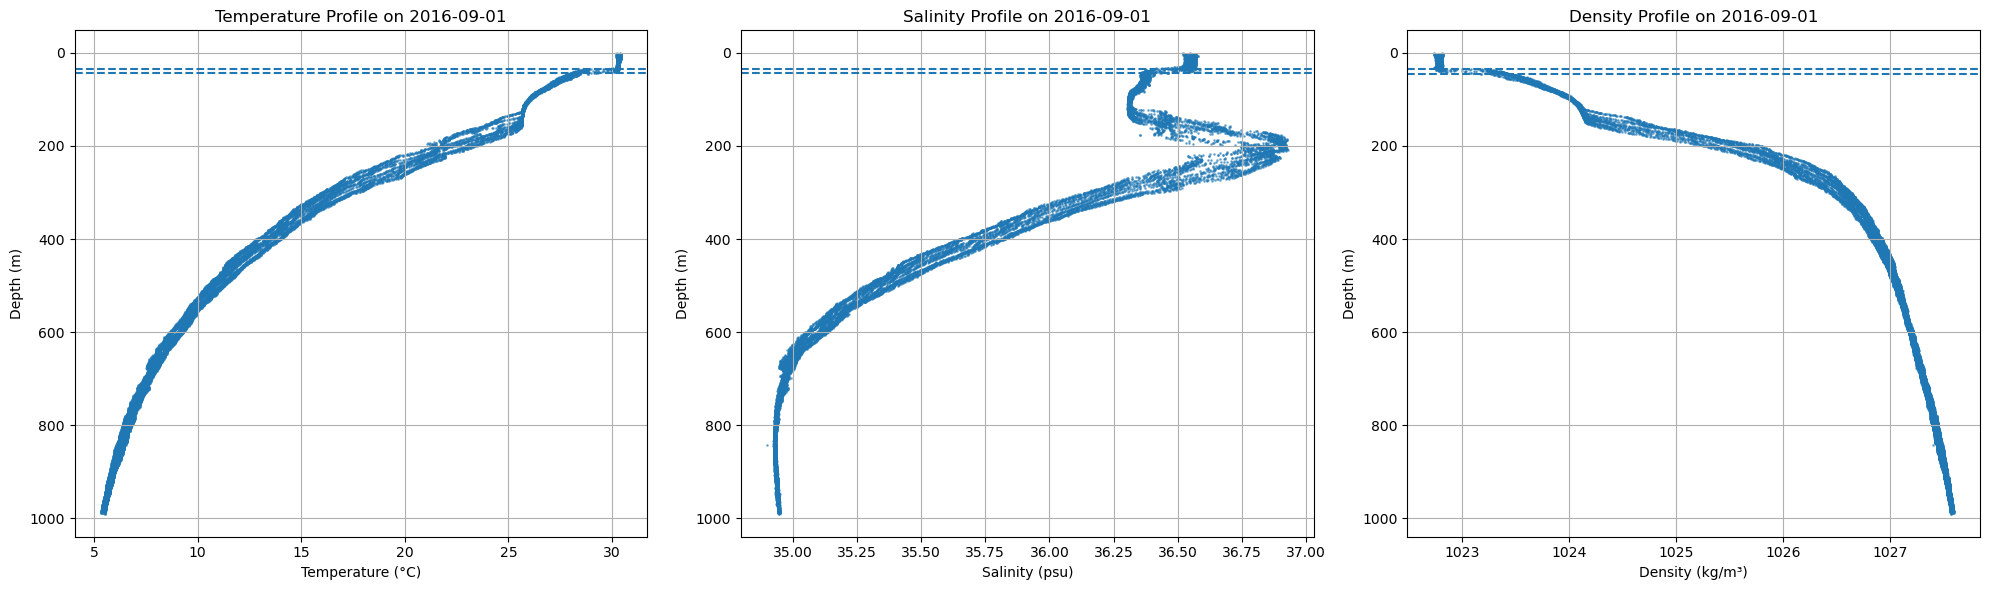

Closest time index: 1
_show_var_names = True


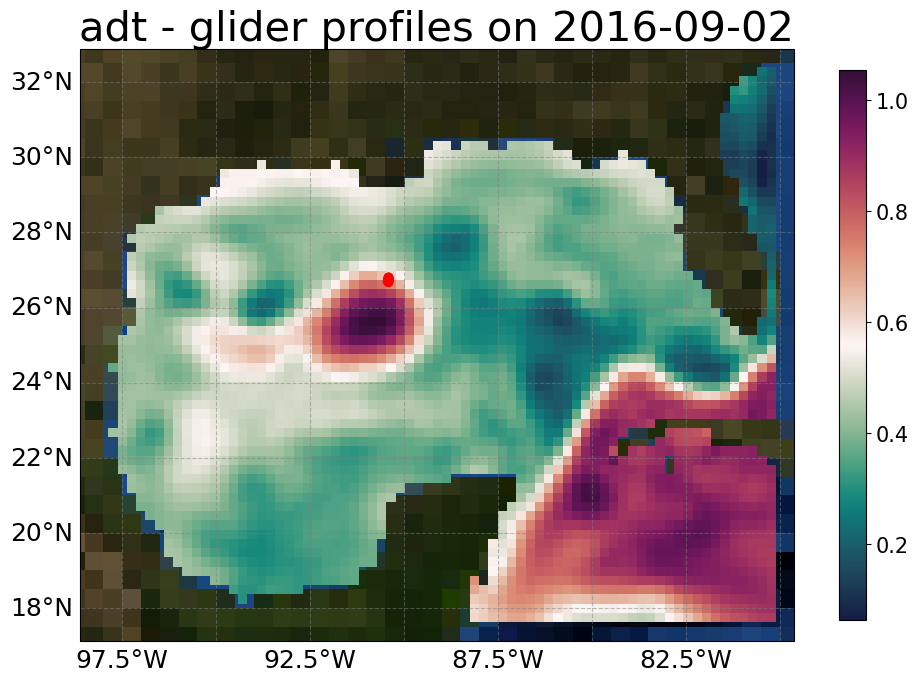

date		lat			lon			AVISO SSH
2016-09-02	26.690588884431346	-90.43676522683167	0.7030527450040974
2016-09-02	26.697113257315554	-90.44133401729049	0.7005992660264546
2016-09-02	26.70488698012651	-90.43554575451326	0.696159127595773
2016-09-02	26.712188890310376	-90.43927615441923	0.6932234771656222
2016-09-02	26.734578984973684	-90.43565306175218	0.6822009680560857
2016-09-02	26.742866458038307	-90.43810246466897	0.678624931221656
2016-09-02	26.7188482561715	-90.43444322207644	0.6894418005144692
2016-09-02	26.725909049732977	-90.43770295439646	0.6865541647764716
2016-09-02	26.783427843586043	-90.42536581064269	0.6578790385412698
2016-09-02	26.792850274637864	-90.43097433203248	0.6541752413937092
2016-09-02	26.765075927657932	-90.42870393449817	0.6669402142103347
2016-09-02	26.774519887783857	-90.43209644186938	0.6629420675239959
2016-09-02	26.751421436030157	-90.42930575559743	0.6734391554582263
2016-09-02	26.757908263633496	-90.43335472252036	0.6709207783293991
2016-09-02	26.80233536297

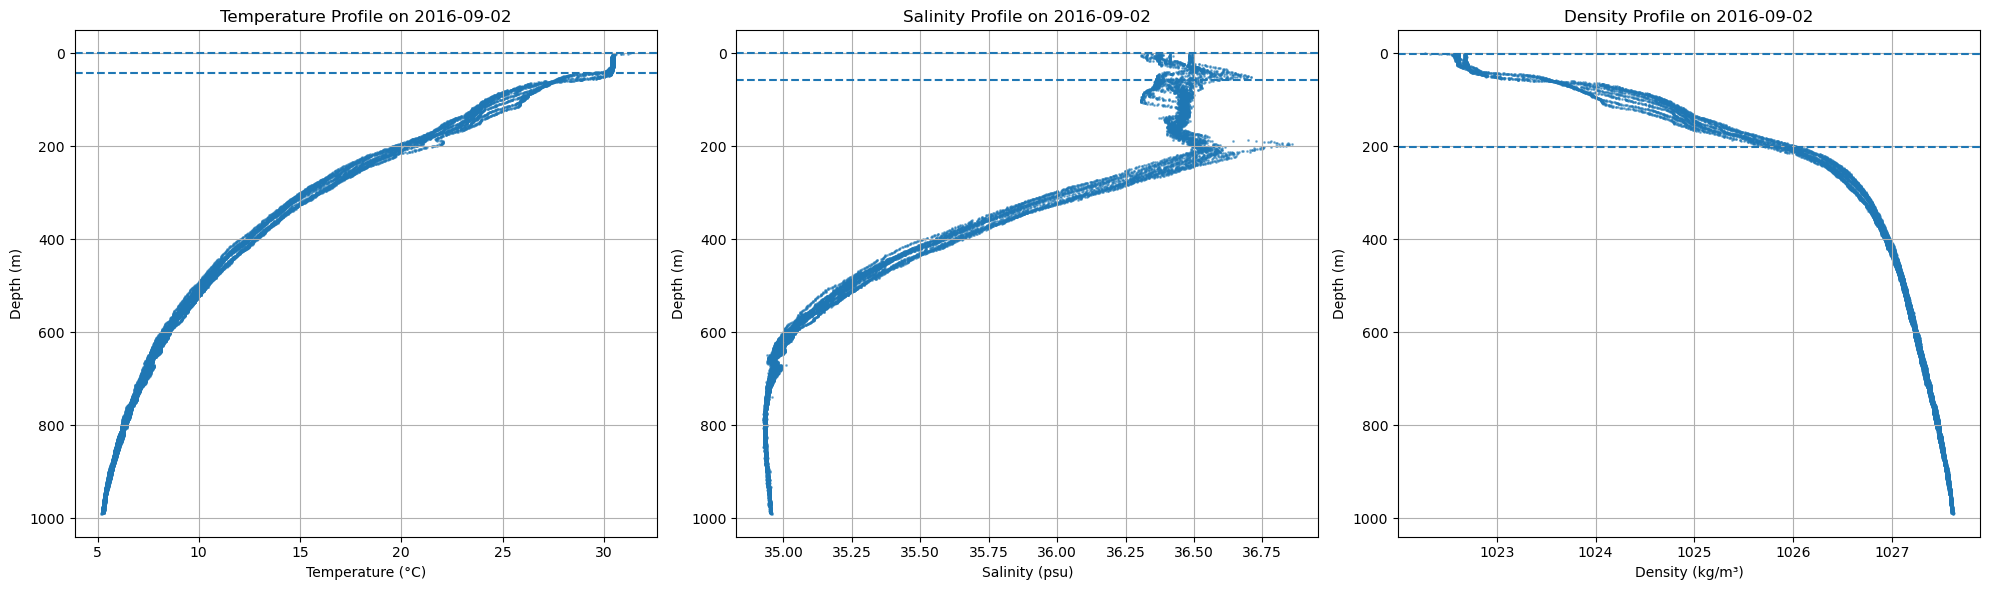

Closest time index: 2
_show_var_names = True


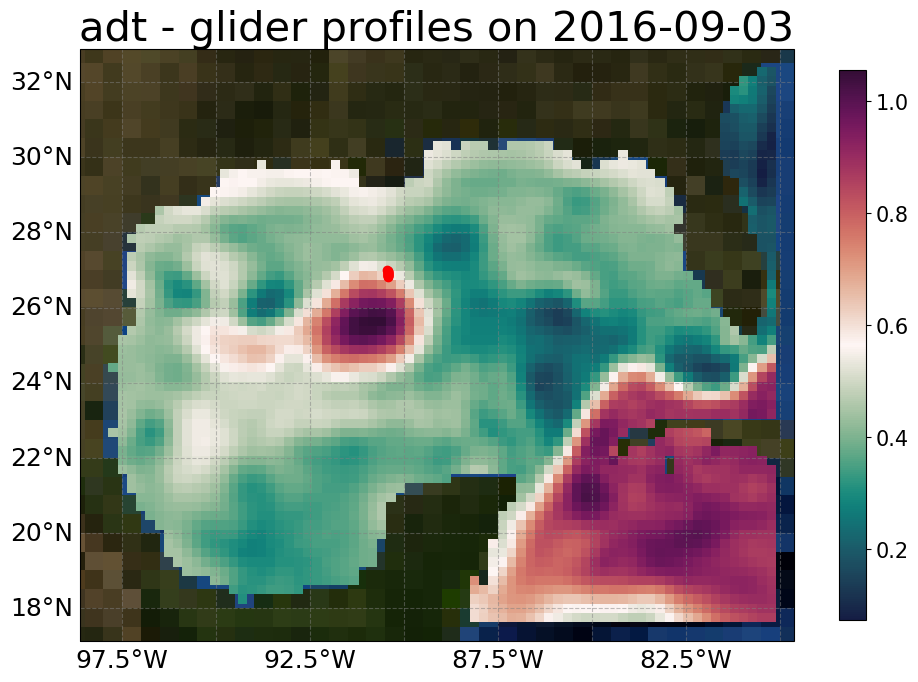

date		lat			lon			AVISO SSH
2016-09-03	26.843569238861857	-90.42280673033756	0.6041698701084783
2016-09-03	26.853075931521865	-90.42727795188495	0.6004959272242752
2016-09-03	26.82376680873639	-90.4242121036392	0.6133409671549661
2016-09-03	26.832781661710698	-90.42782065797469	0.6097746275901161
2016-09-03	26.90628015536588	-90.42553104456752	0.5787141012460147
2016-09-03	26.9175884821875	-90.42944099300998	0.5750289702179235
2016-09-03	26.88221040022114	-90.42372609751659	0.5873920386208906
2016-09-03	26.893116789333646	-90.42811568957009	0.5839445510559792
2016-09-03	26.86303599568967	-90.4204303572848	0.595020827520971
2016-09-03	26.871245485356766	-90.42550287178904	0.5920112527190206
2016-09-03	26.95447361734979	-90.43196129319385	0.5616295795105126
2016-09-03	26.969249362773883	-90.43971422916448	0.5570559743329797
2016-09-03	26.92949124178821	-90.42761859023966	0.5703730159052642
2016-09-03	26.941476035610535	-90.4347094270794	0.5668104528700155
2016-09-03	26.984799619490214	-9

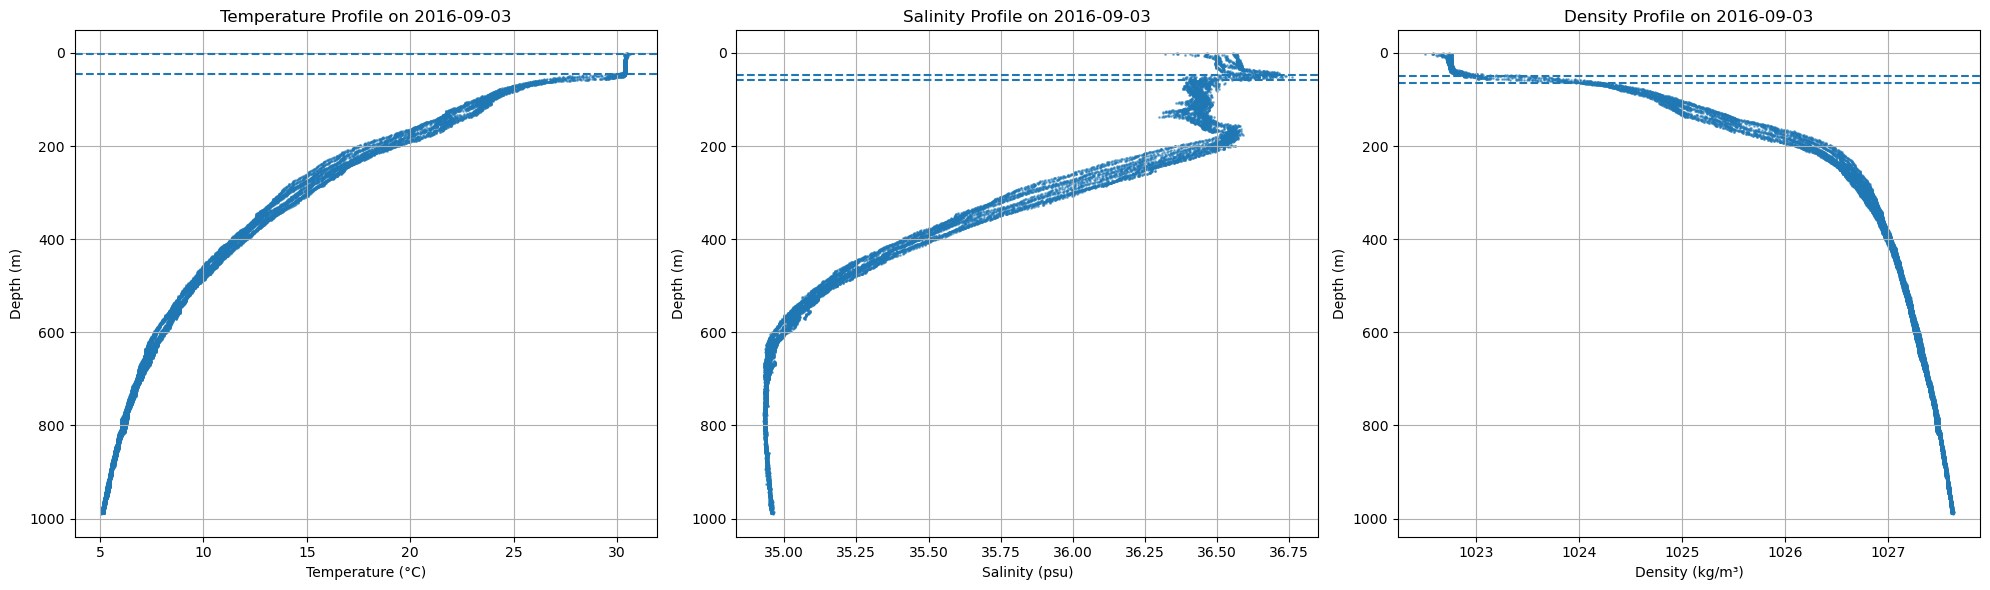

Closest time index: 3
_show_var_names = True


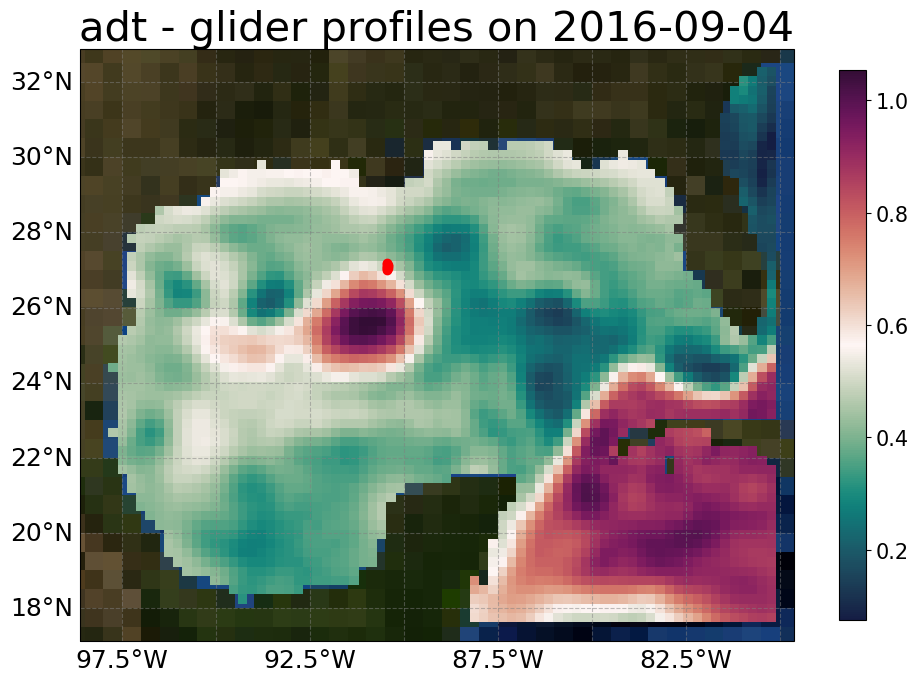

date		lat			lon			AVISO SSH
2016-09-04	27.002358208487767	-90.4438225834173	0.5227725155987735
2016-09-04	27.019643617719932	-90.4423361775116	0.516633932356592
2016-09-04	27.039650154232834	-90.44576722173984	0.5101434640069021
2016-09-04	27.058058923223715	-90.43927832416563	0.5030656417657164
2016-09-04	27.078342962302294	-90.44388712929911	0.4965867869929844
2016-09-04	27.095698198055224	-90.43717476281438	0.4899203214158738
2016-09-04	27.115502085352624	-90.44141821978914	0.4835380819385269
2016-09-04	27.173623686001456	-90.44047629068949	0.46875115361508146
2016-09-04	27.133568378123275	-90.43659115908814	0.477803047975991
2016-09-04	27.15417968706273	-90.44359686407479	0.4736082131954468


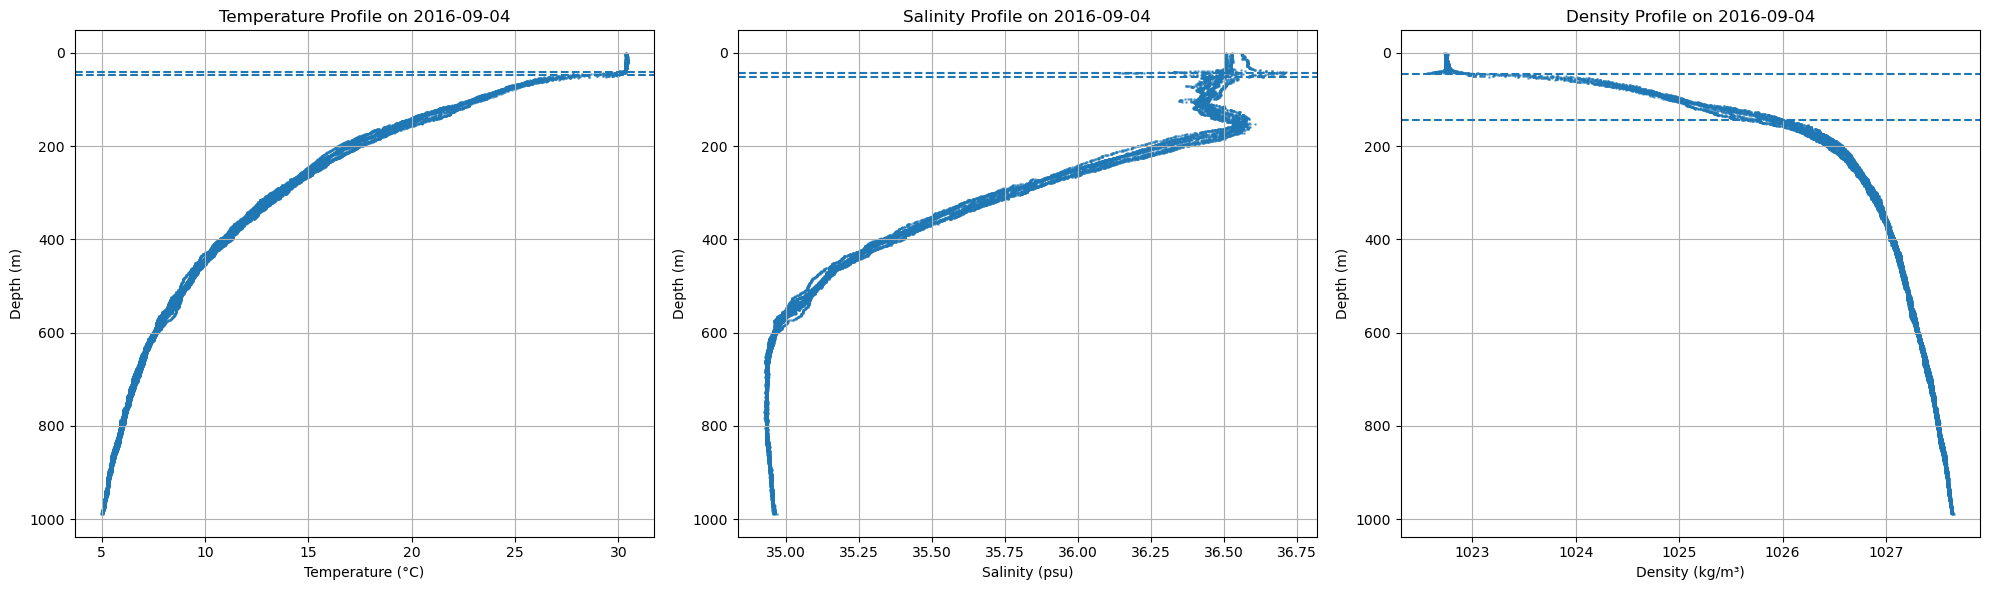

Closest time index: 4
_show_var_names = True


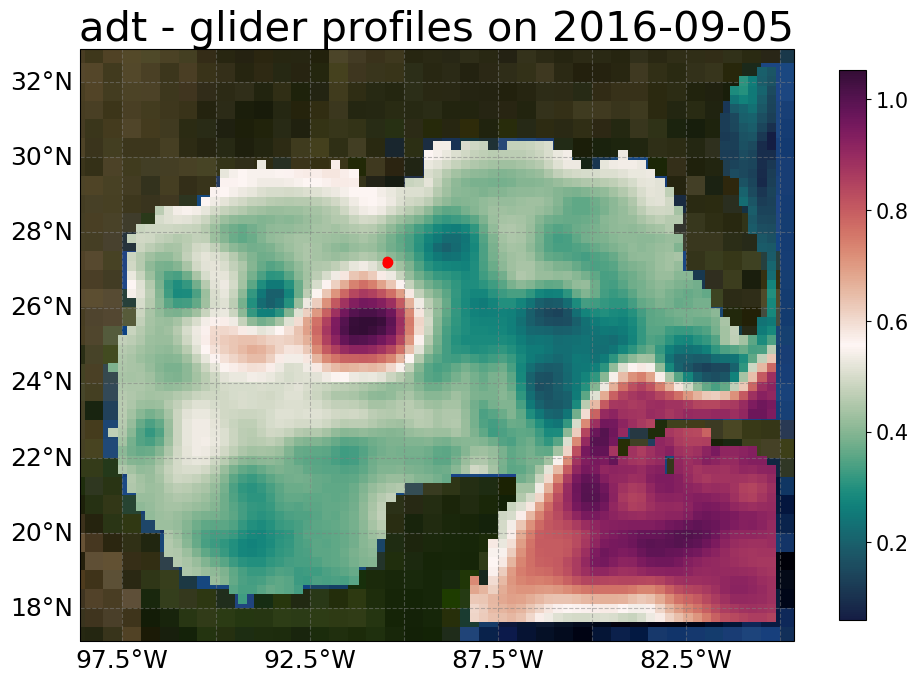

date		lat			lon			AVISO SSH
2016-09-05	27.173623686001456	-90.44047629068949	0.45411346995992774
2016-09-05	27.197087633855645	-90.44258870737536	0.4493097493084613
2016-09-05	27.215796827066082	-90.43832660395292	0.44494497555007423
2016-09-05	27.238977001392822	-90.44238140218503	0.4403663308845094


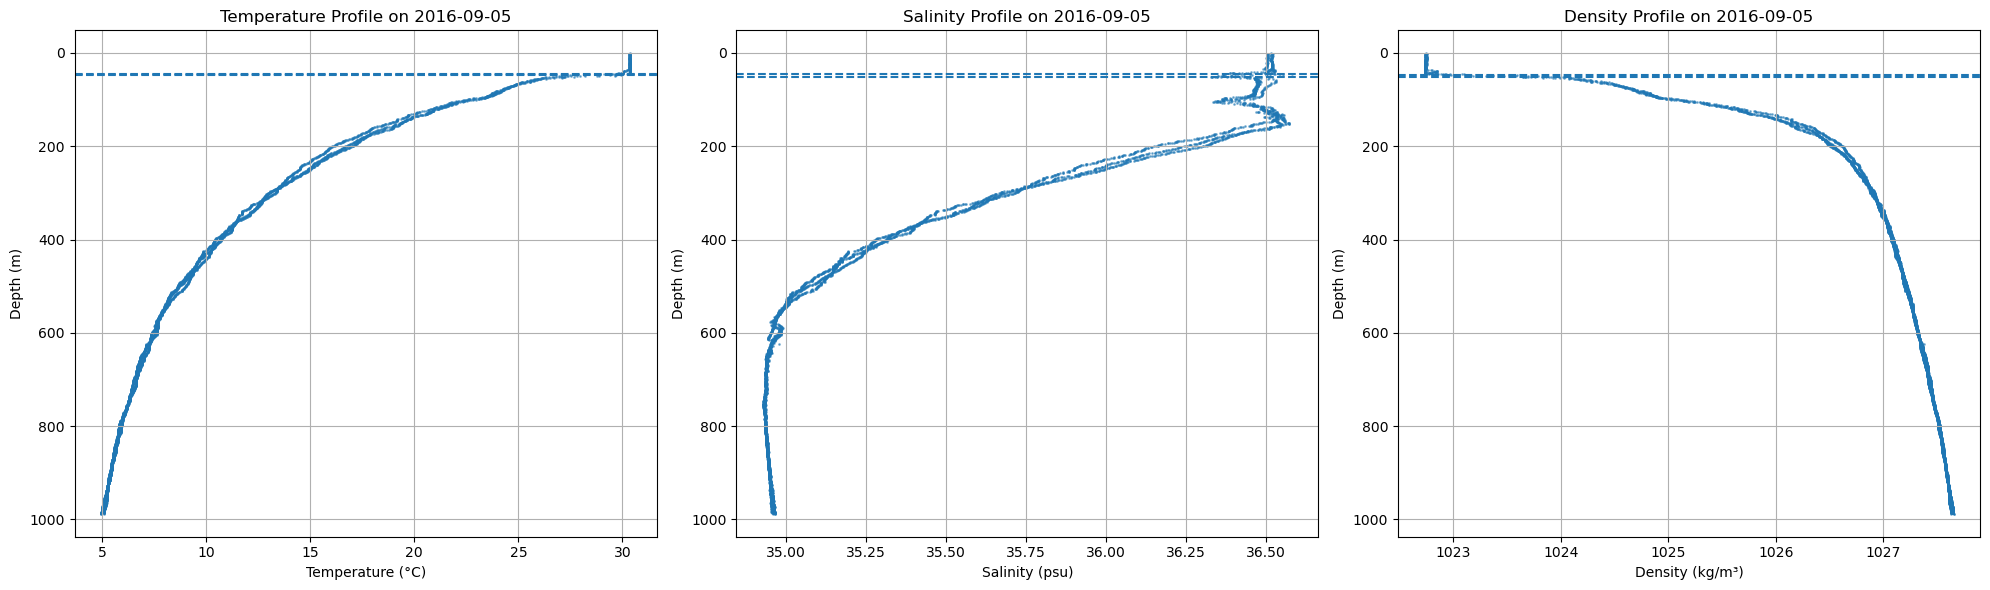

In [5]:
# Get AVISO, plot daily profiles
date_of_interest = start_date
# Initialize an empty DataFrame to store additional data
additional_data = []

while date_of_interest <= end_date:
    date_string = date_of_interest.strftime("%Y-%m-%d")
    aviso_data, grid_lats, grid_lons = get_aviso_by_date(aviso_folder, date_of_interest, bbox)
    profiles_on_date = ds[ds['date'] == date_of_interest.date()]['profile_id'].unique()
    position_on_date = position.loc[profiles_on_date]
    viz_obj = EOAImageVisualizer(lats=grid_lats, lons=grid_lons, disp_images=True, output_folder="outputs", show_var_names=True)
    prof_lat = position_on_date['lat'].values
    prof_lon = position_on_date['lon'].values
    profile_ssh = get_prof_ssh_from_aviso(prof_lat, prof_lon, aviso_data.adt, grid_lats, grid_lons)
    
    plot_points = [Point(lon, lat) for lat, lon in zip(prof_lat, prof_lon)]
    viz_obj.__setattr__('additional_polygons', plot_points)
    viz_obj.plot_2d_data_np(aviso_data.adt, ['adt'], f'- glider profiles on {date_string}', 'filepref')
   
    print("date\t\tlat\t\t\tlon\t\t\tAVISO SSH")
    for lat, lon, altimetry_value in zip(prof_lat, prof_lon, profile_ssh):
        print(f"{date_string}\t{lat}\t{lon}\t{altimetry_value}")
    plot_profiles(ds, date_of_interest.date())
    
     # TODO THESE VALUES ARE BEING SAVED AS NANs
     # Create a temporary DataFrame with profile_id, lat, lon, and AVISO SSH
    temp_data = pd.DataFrame({
        'profile_id': profiles_on_date,
        'lat_position': prof_lat,
        'lon_position': prof_lon,
        'AVISO_SSH': profile_ssh
    })

    for lat, lon, ssh, profile_id in zip(prof_lat, prof_lon, profile_ssh, profiles_on_date):
        additional_data.append({
            'profile_id': profile_id,
            'lat_position': lat,
            'lon_position': lon,
            'AVISO_SSH': ssh
        })
    
    date_of_interest += delta

In [6]:
if not processed:
    additional_data_df = pd.DataFrame(additional_data)
    # Merge with ds using profile_id as the key
    ds = pd.merge(ds, additional_data_df, on='profile_id', how='left')
    ds = pd.merge(ds, mld_table, on='profile_id', how='left')
    # Save processed data
    ds.to_pickle(pickle_folder)
    processed = True